In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow import keras
import os
import datetime

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2023-09-08 00:26:49.064415: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-08 00:26:49.290546: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 00:26:50.135659: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# 리눅스 한글 설정
plt.rc('font', family = 'NanumGothic')

In [3]:
file = '2013~2023 한국 기온,습도,풍속.csv'
file2 = '한국기후 평균 최고 최저.csv'

In [4]:
df = pd.read_csv(file, encoding = 'cp949')
df1 = pd.read_csv(file2, encoding = 'cp949', header = 0)
df1.head()

\t\t지점번호 지점명          일시  평균기온(℃)  최고기온(℃)  최저기온(℃)
0       105  강릉  1970-01-01      3.2     10.3     -0.5
1       105  강릉  1970-01-02      1.8      5.1     -0.2
2       105  강릉  1970-01-03     -0.3      4.8     -2.2
3       105  강릉  1970-01-04     -5.9     -1.7    -12.6
4       105  강릉  1970-01-05     -7.9     -0.8    -14.7

In [5]:
df1.columns = ['지점번호', '지점명', '일시', '평균기온(℃)', '최고기온(℃)', '최저기온(℃)']
df1 = df1.iloc[:, 2:]
df1.head()

일시  평균기온(℃)  최고기온(℃)  최저기온(℃)
0  1970-01-01      3.2     10.3     -0.5
1  1970-01-02      1.8      5.1     -0.2
2  1970-01-03     -0.3      4.8     -2.2
3  1970-01-04     -5.9     -1.7    -12.6
4  1970-01-05     -7.9     -0.8    -14.7

In [6]:
df_korea = df.drop(['지점번호', '지점명'], axis = 1).groupby(['일시']).mean()
df_temp = df1.groupby(['일시']).mean()
df_korea.head(10)

평균기온(℃)  최고기온(℃)   최저기온(℃)  평균습도(%rh)  평균풍속(m/s)
일시                                                          
2013-01-01 -0.76250  4.43750  -6.21250   73.10000    2.33125
2013-01-02 -4.70000  0.54375  -8.98125   53.29375    3.58750
2013-01-03 -8.09375 -3.99375 -11.26250   48.90000    3.40625
2013-01-04 -6.74375 -1.15000 -11.61875   50.25000    2.03125
2013-01-05 -3.81250  1.75625  -9.41875   57.06250    2.28125
2013-01-06 -2.32500  2.52500  -5.73750   57.04375    1.96875
2013-01-07 -2.00625  3.35000  -6.72500   49.62500    1.95000
2013-01-08 -1.22500  3.76875  -5.28750   50.66250    2.15625
2013-01-09 -4.01875 -0.80625  -7.14375   45.38125    3.41250
2013-01-10 -4.78125  0.14375  -8.91250   42.67500    2.61875

In [7]:
filter1 = df_temp['최고기온(℃)'].isna() == True
df_temp['최고기온(℃)'][filter1] = 20.7875

In [8]:
filter2 = df_temp['최저기온(℃)'].isna() == True
df_temp['최저기온(℃)'][filter2] = 7.15625

In [9]:
df_korea = df_korea.reset_index()

In [10]:
df_korea['일시']  = pd.to_datetime(df_korea['일시'])
df_korea.set_index('일시', inplace = True)

In [11]:
dataset = df_temp.iloc[:, :]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape

(19585, 3)

In [12]:
train_size = int(len(data)*0.8)
test_size = len(data) - train_size
print('Train Size :', train_size, 'Test Size : ', test_size)

Train Size : 15668 Test Size :  3917


In [13]:
scaler = MinMaxScaler(feature_range = (0 , 1))
scaled_data = scaler.fit_transform(np.array(data))

In [14]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(15668, 3)

In [15]:
x_train = []
y_train = []
time_step = 65
n_col = 3

for i in range(time_step, len(scaled_data)):
    print(time_step, i)
    x_train.append(scaled_data[i-time_step:i, :n_col])
    y_train.append(scaled_data[i, :n_col])
    if i <= time_step:
        print('x_train : ', x_train)
        print('y_train : ', y_train)

65 65
x_train :  [array([[0.28644888, 0.31922063, 0.28660807],
       [0.29945554, 0.29607384, 0.3198272 ],
       [0.25937689, 0.25388222, 0.26530612],
       [0.10027223, 0.10108409, 0.08580366],
       [0.02510587, 0.04731907, 0.        ],
       [0.24319419, 0.25754468, 0.20527335],
       [0.22837266, 0.23513038, 0.23596008],
       [0.23835451, 0.25388222, 0.23447043],
       [0.17211131, 0.16319953, 0.18948309],
       [0.20220811, 0.21432757, 0.19603754],
       [0.23275862, 0.25212423, 0.2215105 ],
       [0.33318209, 0.35159684, 0.2919708 ],
       [0.15366001, 0.17096396, 0.17488455],
       [0.09195402, 0.10225608, 0.10859526],
       [0.06488203, 0.05288602, 0.09742291],
       [0.05792498, 0.08980369, 0.04856249],
       [0.0738052 , 0.09449165, 0.07239684],
       [0.12885662, 0.18678582, 0.1084463 ],
       [0.17029643, 0.20773513, 0.16803218],
       [0.1822444 , 0.22121301, 0.17116043],
       [0.22081065, 0.27175505, 0.194101  ],
       [0.28055051, 0.32390858, 0.248

65 3253
65 3254
65 3255
65 3256
65 3257
65 3258
65 3259
65 3260
65 3261
65 3262
65 3263
65 3264
65 3265
65 3266
65 3267
65 3268
65 3269
65 3270
65 3271
65 3272
65 3273
65 3274
65 3275
65 3276
65 3277
65 3278
65 3279
65 3280
65 3281
65 3282
65 3283
65 3284
65 3285
65 3286
65 3287
65 3288
65 3289
65 3290
65 3291
65 3292
65 3293
65 3294
65 3295
65 3296
65 3297
65 3298
65 3299
65 3300
65 3301
65 3302
65 3303
65 3304
65 3305
65 3306
65 3307
65 3308
65 3309
65 3310
65 3311
65 3312
65 3313
65 3314
65 3315
65 3316
65 3317
65 3318
65 3319
65 3320
65 3321
65 3322
65 3323
65 3324
65 3325
65 3326
65 3327
65 3328
65 3329
65 3330
65 3331
65 3332
65 3333
65 3334
65 3335
65 3336
65 3337
65 3338
65 3339
65 3340
65 3341
65 3342
65 3343
65 3344
65 3345
65 3346
65 3347
65 3348
65 3349
65 3350
65 3351
65 3352
65 3353
65 3354
65 3355
65 3356
65 3357
65 3358
65 3359
65 3360
65 3361
65 3362
65 3363
65 3364
65 3365
65 3366
65 3367
65 3368
65 3369
65 3370
65 3371
65 3372
65 3373
65 3374
65 3375
65 3376
65 3377


65 6003
65 6004
65 6005
65 6006
65 6007
65 6008
65 6009
65 6010
65 6011
65 6012
65 6013
65 6014
65 6015
65 6016
65 6017
65 6018
65 6019
65 6020
65 6021
65 6022
65 6023
65 6024
65 6025
65 6026
65 6027
65 6028
65 6029
65 6030
65 6031
65 6032
65 6033
65 6034
65 6035
65 6036
65 6037
65 6038
65 6039
65 6040
65 6041
65 6042
65 6043
65 6044
65 6045
65 6046
65 6047
65 6048
65 6049
65 6050
65 6051
65 6052
65 6053
65 6054
65 6055
65 6056
65 6057
65 6058
65 6059
65 6060
65 6061
65 6062
65 6063
65 6064
65 6065
65 6066
65 6067
65 6068
65 6069
65 6070
65 6071
65 6072
65 6073
65 6074
65 6075
65 6076
65 6077
65 6078
65 6079
65 6080
65 6081
65 6082
65 6083
65 6084
65 6085
65 6086
65 6087
65 6088
65 6089
65 6090
65 6091
65 6092
65 6093
65 6094
65 6095
65 6096
65 6097
65 6098
65 6099
65 6100
65 6101
65 6102
65 6103
65 6104
65 6105
65 6106
65 6107
65 6108
65 6109
65 6110
65 6111
65 6112
65 6113
65 6114
65 6115
65 6116
65 6117
65 6118
65 6119
65 6120
65 6121
65 6122
65 6123
65 6124
65 6125
65 6126
65 6127


65 9788
65 9789
65 9790
65 9791
65 9792
65 9793
65 9794
65 9795
65 9796
65 9797
65 9798
65 9799
65 9800
65 9801
65 9802
65 9803
65 9804
65 9805
65 9806
65 9807
65 9808
65 9809
65 9810
65 9811
65 9812
65 9813
65 9814
65 9815
65 9816
65 9817
65 9818
65 9819
65 9820
65 9821
65 9822
65 9823
65 9824
65 9825
65 9826
65 9827
65 9828
65 9829
65 9830
65 9831
65 9832
65 9833
65 9834
65 9835
65 9836
65 9837
65 9838
65 9839
65 9840
65 9841
65 9842
65 9843
65 9844
65 9845
65 9846
65 9847
65 9848
65 9849
65 9850
65 9851
65 9852
65 9853
65 9854
65 9855
65 9856
65 9857
65 9858
65 9859
65 9860
65 9861
65 9862
65 9863
65 9864
65 9865
65 9866
65 9867
65 9868
65 9869
65 9870
65 9871
65 9872
65 9873
65 9874
65 9875
65 9876
65 9877
65 9878
65 9879
65 9880
65 9881
65 9882
65 9883
65 9884
65 9885
65 9886
65 9887
65 9888
65 9889
65 9890
65 9891
65 9892
65 9893
65 9894
65 9895
65 9896
65 9897
65 9898
65 9899
65 9900
65 9901
65 9902
65 9903
65 9904
65 9905
65 9906
65 9907
65 9908
65 9909
65 9910
65 9911
65 9912


65 13249
65 13250
65 13251
65 13252
65 13253
65 13254
65 13255
65 13256
65 13257
65 13258
65 13259
65 13260
65 13261
65 13262
65 13263
65 13264
65 13265
65 13266
65 13267
65 13268
65 13269
65 13270
65 13271
65 13272
65 13273
65 13274
65 13275
65 13276
65 13277
65 13278
65 13279
65 13280
65 13281
65 13282
65 13283
65 13284
65 13285
65 13286
65 13287
65 13288
65 13289
65 13290
65 13291
65 13292
65 13293
65 13294
65 13295
65 13296
65 13297
65 13298
65 13299
65 13300
65 13301
65 13302
65 13303
65 13304
65 13305
65 13306
65 13307
65 13308
65 13309
65 13310
65 13311
65 13312
65 13313
65 13314
65 13315
65 13316
65 13317
65 13318
65 13319
65 13320
65 13321
65 13322
65 13323
65 13324
65 13325
65 13326
65 13327
65 13328
65 13329
65 13330
65 13331
65 13332
65 13333
65 13334
65 13335
65 13336
65 13337
65 13338
65 13339
65 13340
65 13341
65 13342
65 13343
65 13344
65 13345
65 13346
65 13347
65 13348
65 13349
65 13350
65 13351
65 13352
65 13353
65 13354
65 13355
65 13356
65 13357
65 13358
65 13359
6

65 15240
65 15241
65 15242
65 15243
65 15244
65 15245
65 15246
65 15247
65 15248
65 15249
65 15250
65 15251
65 15252
65 15253
65 15254
65 15255
65 15256
65 15257
65 15258
65 15259
65 15260
65 15261
65 15262
65 15263
65 15264
65 15265
65 15266
65 15267
65 15268
65 15269
65 15270
65 15271
65 15272
65 15273
65 15274
65 15275
65 15276
65 15277
65 15278
65 15279
65 15280
65 15281
65 15282
65 15283
65 15284
65 15285
65 15286
65 15287
65 15288
65 15289
65 15290
65 15291
65 15292
65 15293
65 15294
65 15295
65 15296
65 15297
65 15298
65 15299
65 15300
65 15301
65 15302
65 15303
65 15304
65 15305
65 15306
65 15307
65 15308
65 15309
65 15310
65 15311
65 15312
65 15313
65 15314
65 15315
65 15316
65 15317
65 15318
65 15319
65 15320
65 15321
65 15322
65 15323
65 15324
65 15325
65 15326
65 15327
65 15328
65 15329
65 15330
65 15331
65 15332
65 15333
65 15334
65 15335
65 15336
65 15337
65 15338
65 15339
65 15340
65 15341
65 15342
65 15343
65 15344
65 15345
65 15346
65 15347
65 15348
65 15349
65 15350
6

65 18649
65 18650
65 18651
65 18652
65 18653
65 18654
65 18655
65 18656
65 18657
65 18658
65 18659
65 18660
65 18661
65 18662
65 18663
65 18664
65 18665
65 18666
65 18667
65 18668
65 18669
65 18670
65 18671
65 18672
65 18673
65 18674
65 18675
65 18676
65 18677
65 18678
65 18679
65 18680
65 18681
65 18682
65 18683
65 18684
65 18685
65 18686
65 18687
65 18688
65 18689
65 18690
65 18691
65 18692
65 18693
65 18694
65 18695
65 18696
65 18697
65 18698
65 18699
65 18700
65 18701
65 18702
65 18703
65 18704
65 18705
65 18706
65 18707
65 18708
65 18709
65 18710
65 18711
65 18712
65 18713
65 18714
65 18715
65 18716
65 18717
65 18718
65 18719
65 18720
65 18721
65 18722
65 18723
65 18724
65 18725
65 18726
65 18727
65 18728
65 18729
65 18730
65 18731
65 18732
65 18733
65 18734
65 18735
65 18736
65 18737
65 18738
65 18739
65 18740
65 18741
65 18742
65 18743
65 18744
65 18745
65 18746
65 18747
65 18748
65 18749
65 18750
65 18751
65 18752
65 18753
65 18754
65 18755
65 18756
65 18757
65 18758
65 18759
6

In [16]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_col))

In [18]:
x_train.shape, y_train.shape

((19520, 65, 3), (19520, 3))

In [19]:
m_lstm = keras.Sequential([
    keras.layers.LSTM(50, input_shape=(x_train.shape[1], n_col),
                       activation = 'relu',return_sequences = True),
    keras.layers.LSTM(64, return_sequences = False, activation = 'relu'),
    #keras.layers.LSTM(50, return_sequences = True, activation = 'relu'),
    #keras.layers.LSTM(64, return_sequences = False, activation = 'relu'),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dense(n_col)
])

m_lstm.summary()
#kernel_regularizer="l2"
#kernel_regularizer = keras.regularizers.l2(0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 65, 50)            10800     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 42,899
Trainable params: 42,899
Non-trainable params: 0
_________________________________________________________________


2023-09-08 00:26:55.583987: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [20]:
m_lstm.compile(optimizer = tf.optimizers.RMSprop(learning_rate = 0.001),
             loss = keras.losses.MeanSquaredError(),
             metrics = ['mae'])

In [21]:
h = m_lstm.fit(x_train, y_train, epochs = 30, shuffle=False, batch_size = 32)

Epoch 1/30
610/610 [==============================] - 12s 18ms/step - loss: 0.0876 - mae: 0.1250
Epoch 2/30
610/610 [==============================] - 11s 18ms/step - loss: 0.0157 - mae: 0.0640
Epoch 3/30
610/610 [==============================] - 11s 18ms/step - loss: 1.9686 - mae: 0.0917
Epoch 4/30
610/610 [==============================] - 11s 18ms/step - loss: 0.0050 - mae: 0.0558
Epoch 5/30
610/610 [==============================] - 11s 18ms/step - loss: 0.0045 - mae: 0.0527
Epoch 6/30
610/610 [==============================] - 11s 18ms/step - loss: 0.0040 - mae: 0.0494
Epoch 7/30
610/610 [==============================] - 11s 18ms/step - loss: 0.0036 - mae: 0.0466
Epoch 8/30
610/610 [==============================] - 11s 18ms/step - loss: 0.0032 - mae: 0.0442
Epoch 9/30
610/610 [==============================] - 11s 18ms/step - loss: 0.0029 - mae: 0.0418
Epoch 10/30
610/610 [==============================] - 11s 18ms/step - loss: 0.0027 - mae: 0.0403
Epoch 11/30
610/610 [========

Text(0, 0.5, 'Losses')

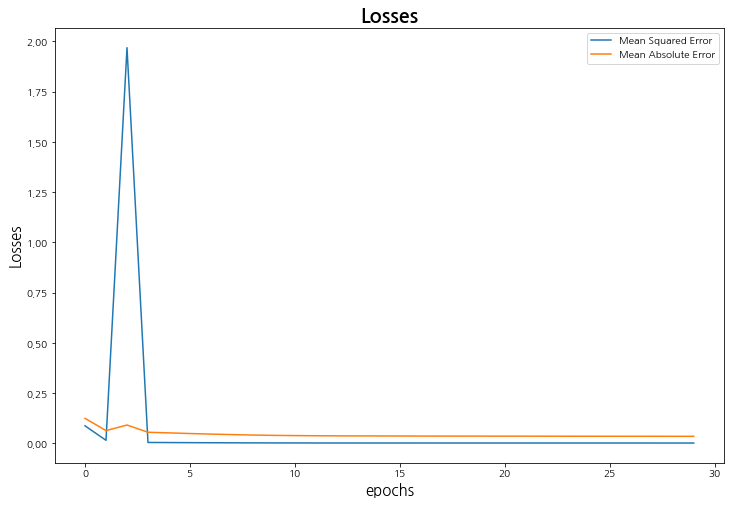

In [22]:
fig, axe = plt.subplots(figsize = (12, 8))
axe.plot(h.history['loss'])
axe.plot(h.history['mae'])
axe.legend(['Mean Squared Error', 'Mean Absolute Error'])
axe.set_title('Losses', size = 20, weight = 'bold')
axe.set_xlabel('epochs', size = 15)
axe.set_ylabel('Losses', size = 15)

In [23]:
#8/30
m_lstm.save('m7_lstm_RMSprop.h5')

In [24]:
m_lstm_RMSprop = tf.keras.models.load_model('m7_lstm_RMSprop.h5')

In [25]:
test_data = scaled_data[train_size - time_step:, :]

x_test = []
y_test = []

for i in range(time_step, len(test_data)):
    #print(time_step, i)
    x_test.append(test_data[i-time_step:i, 0:n_col])
    y_test.append(test_data[i, 0:n_col])
    
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_col))

x_test

array([[[0.74153055, 0.75124524, 0.72441531],
        [0.73623714, 0.73849985, 0.72918218],
        [0.74001815, 0.75197773, 0.71875466],
        ...,
        [0.39398064, 0.40375037, 0.36317593],
        [0.44570478, 0.46103135, 0.42633696],
        [0.42105263, 0.3997949 , 0.45404439]],

       [[0.73623714, 0.73849985, 0.72918218],
        [0.74001815, 0.75197773, 0.71875466],
        [0.74894132, 0.7666276 , 0.72396842],
        ...,
        [0.44570478, 0.46103135, 0.42633696],
        [0.42105263, 0.3997949 , 0.45404439],
        [0.36448881, 0.37591562, 0.37583793]],

       [[0.74001815, 0.75197773, 0.71875466],
        [0.74894132, 0.7666276 , 0.72396842],
        [0.74863884, 0.76779959, 0.72605393],
        ...,
        [0.42105263, 0.3997949 , 0.45404439],
        [0.36448881, 0.37591562, 0.37583793],
        [0.3761343 , 0.3891005 , 0.34693878]],

       ...,

       [[0.7993043 , 0.80383827, 0.78370326],
        [0.81019359, 0.82346909, 0.80560107],
        [0.79748941, 0

In [26]:
m_lstm_RMSprop.evaluate(x_test, y_test)

123/123 [==============================] - 1s 7ms/step - loss: 0.0021 - mae: 0.0335


[0.002052660332992673, 0.033461011946201324]

In [27]:
pred = m_lstm_RMSprop.predict(x_test)
pred

123/123 [==============================] - 1s 7ms/step


array([[0.37786326, 0.38958716, 0.36992761],
       [0.35152712, 0.36376607, 0.34485495],
       [0.37495112, 0.38717407, 0.36754018],
       ...,
       [0.87698555, 0.85379374, 0.89642894],
       [0.90454113, 0.88399935, 0.9215894 ],
       [0.91103864, 0.8915382 , 0.92780304]], dtype=float32)

In [28]:
pred = scaler.inverse_transform(pred)
print(pred.shape)
pred

(3917, 3)


array([[ 5.108949  ,  9.870762  ,  0.95827544],
       [ 4.0206084 ,  8.76917   , -0.09367947],
       [ 4.988605  ,  9.767814  ,  0.8581077 ],
       ...,
       [25.735178  , 29.674976  , 23.048296  ],
       [26.873913  , 30.963623  , 24.103933  ],
       [27.142422  , 31.28525   , 24.364635  ]], dtype=float32)

In [29]:
y_test = scaler.inverse_transform(y_test)
y_test

array([[ 4.556250e+00,  9.287500e+00,  1.206250e+00],
       [ 5.037500e+00,  9.850000e+00, -6.250000e-03],
       [ 4.600000e+00,  8.412500e+00,  1.768750e+00],
       ...,
       [ 2.688750e+01,  3.100625e+01,  2.351875e+01],
       [ 2.740000e+01,  3.166250e+01,  2.434375e+01],
       [ 2.723750e+01,  3.121250e+01,  2.421250e+01]])

In [30]:
pred = pd.DataFrame(pred)
y_test = pd.DataFrame(y_test)

In [31]:
pred.columns = ['예측평균기온', '예측최고기온', '예측최저기온']
y_test.columns = ['실제평균기온', '실제최고기온', '실제최저기온']

In [32]:
df_pred = pd.concat((pred, y_test), axis = 1)
df_pred = df_pred[['예측평균기온', '실제평균기온', '예측최고기온', '실제최고기온', '예측최저기온', '실제최저기온']]
#df_pred = df_pred[['예측평균기온', '실제평균기온', '예측최고기온', '실제최고기온']]
df_pred

예측평균기온    실제평균기온     예측최고기온    실제최고기온     예측최저기온    실제최저기온
0      5.108949   4.55625   9.870762   9.28750   0.958275   1.20625
1      4.020608   5.03750   8.769170   9.85000  -0.093679  -0.00625
2      4.988605   4.60000   9.767814   8.41250   0.858108   1.76875
3      3.677282   3.42500   8.435594   8.21875  -0.406363  -0.63750
4      3.293503   7.72500   8.062754  13.74375  -0.771684   1.75000
...         ...       ...        ...       ...        ...       ...
3912  24.384783  26.24375  28.072470  29.97500  21.846813  22.85625
3913  26.772079  25.86250  30.789244  29.23125  24.055273  23.14375
3914  25.735178  26.88750  29.674976  31.00625  23.048296  23.51875
3915  26.873913  27.40000  30.963623  31.66250  24.103933  24.34375
3916  27.142422  27.23750  31.285250  31.21250  24.364635  24.21250

[3917 rows x 6 columns]

Text(0.5, 1.0, '실제 및 예측 평균 기온 비교')

/usr/lib/python3/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


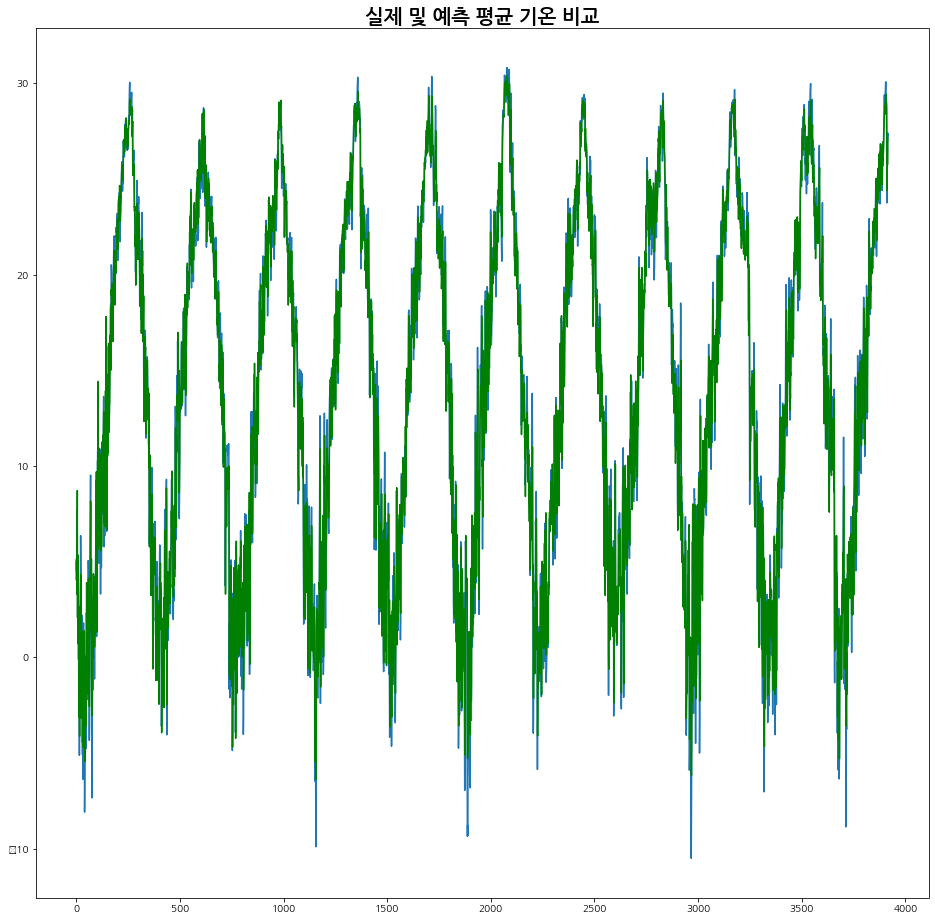

In [33]:
fig, axe = plt.subplots(figsize = (16, 16))
axe.plot(df_pred['실제평균기온'])
axe.plot(df_pred['예측평균기온'], c = 'g')

axe.set_title('실제 및 예측 평균 기온 비교', size = 20, weight = 'bold')
#axe.legend(['actual', 'predict'])

Text(0.5, 1.0, '실제 및 예측 평균 기온 비교')

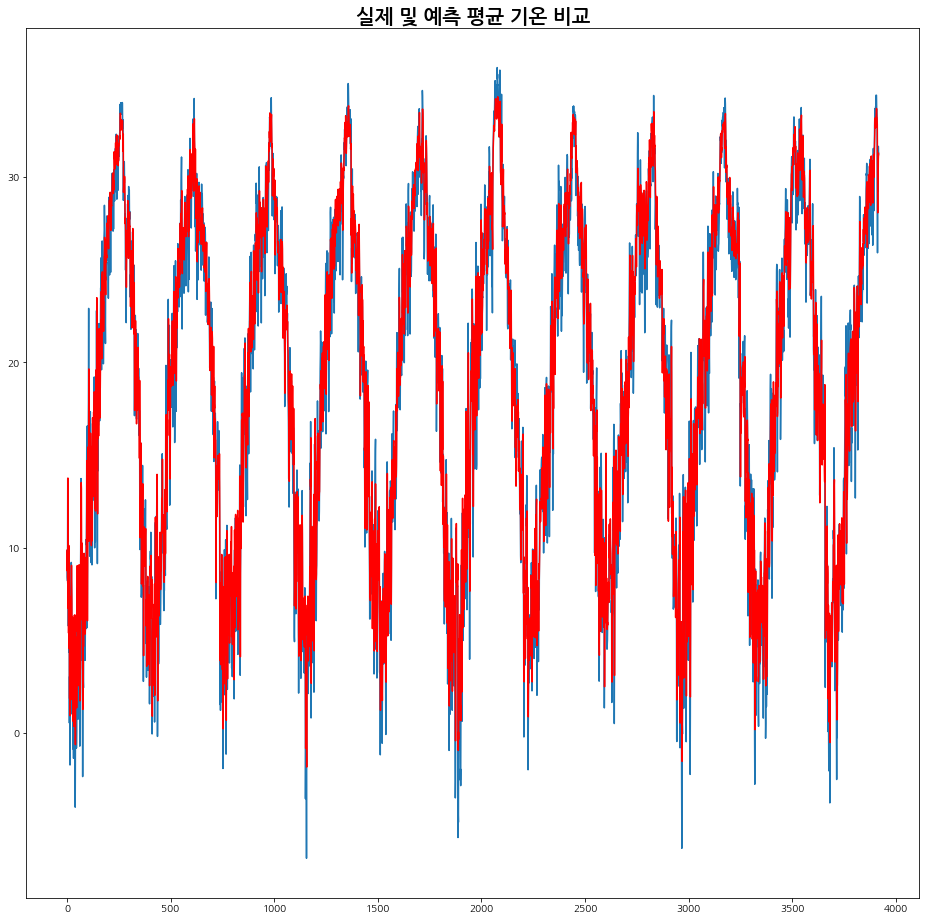

In [34]:
fig, axe = plt.subplots(figsize = (16, 16))
axe.plot(df_pred['실제최고기온'])
axe.plot(df_pred['예측최고기온'], c = 'r')

axe.set_title('실제 및 예측 평균 기온 비교', size = 20, weight = 'bold')
#axe.legend(['actual', 'predict'])

Text(0.5, 1.0, '실제 및 예측 평균 기온 비교')

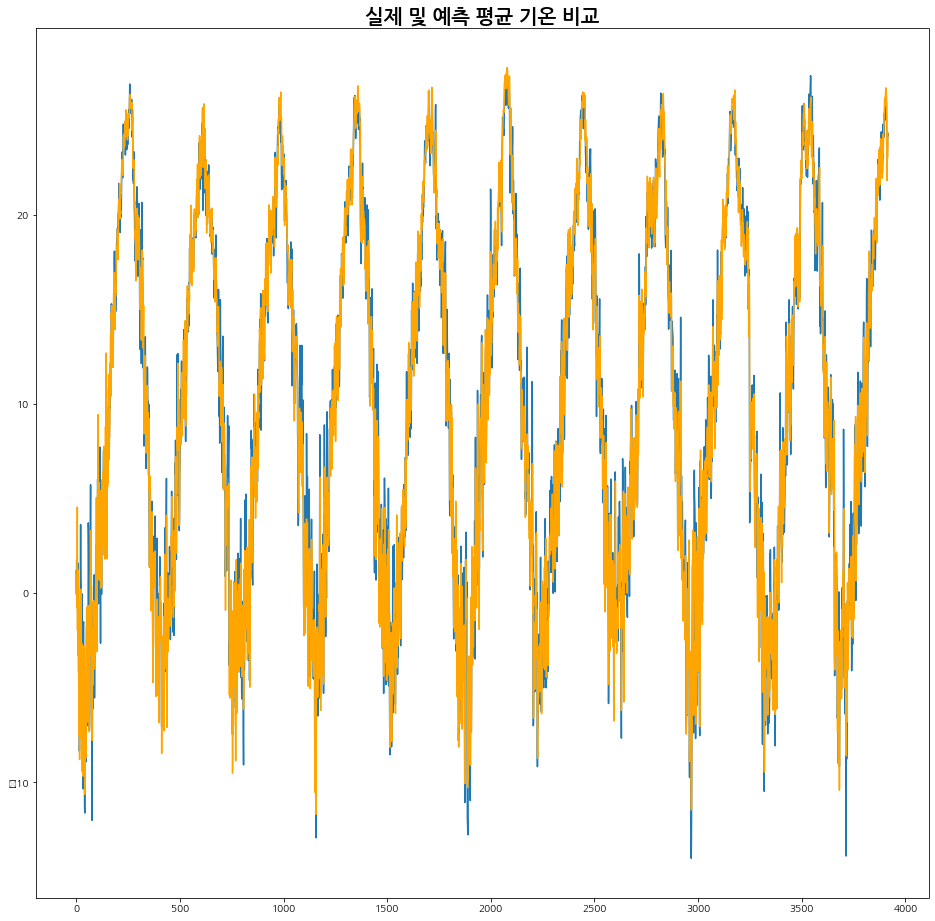

In [35]:
fig, axe = plt.subplots(figsize = (16, 16))
axe.plot(df_pred['실제최저기온'])
axe.plot(df_pred['예측최저기온'], c = 'orange')

axe.set_title('실제 및 예측 평균 기온 비교', size = 20, weight = 'bold')
#axe.legend(['actual', 'predict'])

In [36]:
start_date = datetime.date(2023, 8, 16)
#print('언제의 대한민국 평균 기온을 알고 싶으신가요? (Ex. 2040-01-01, 형태로 적어주세요)')
year, month, day = map(int, input().split('-'))
target_date = datetime.date(year, month, day)

d_day = (target_date - start_date).days
print(d_day)

2026-08-15
1095


In [37]:
list(x_test[-1][0])

[0.7974894131881426, 0.7981248168766482, 0.799791449426486]

In [38]:
last_array = []
for i in range(len(x_test[-1])):
    last_array.append(list(x_test[-1][i]))
len(last_array)
np.array(last_array)

array([[0.79748941, 0.79812482, 0.79979145],
       [0.78750756, 0.78523293, 0.79055564],
       [0.78871748, 0.77717551, 0.79413079],
       [0.77208106, 0.77234105, 0.7729778 ],
       [0.77283727, 0.77658951, 0.75495308],
       [0.82320024, 0.8448579 , 0.77387159],
       [0.84664247, 0.86595371, 0.81438999],
       [0.85012099, 0.86346323, 0.84120363],
       [0.85904416, 0.87884559, 0.8286906 ],
       [0.81261343, 0.77981248, 0.82809474],
       [0.76149425, 0.70216818, 0.80470728],
       [0.80490018, 0.7890419 , 0.80902726],
       [0.82698125, 0.82127161, 0.82064651],
       [0.8399879 , 0.84207442, 0.83345747],
       [0.84497883, 0.83899795, 0.83837331],
       [0.83514822, 0.77131556, 0.85282288],
       [0.87008469, 0.84837386, 0.87308208],
       [0.84694495, 0.81380018, 0.85297185],
       [0.85344828, 0.78757691, 0.89423507],
       [0.82879613, 0.777322  , 0.87546551],
       [0.86358137, 0.85701729, 0.86757039],
       [0.88384755, 0.87503662, 0.88559511],
       [0.

In [39]:
for i in range(time_step, d_day+ time_step):
    print(time_step, i)
    last_ar = np.array(last_array)[i-time_step:i, 0:n_col]
    print(last_ar)
    array = np.reshape(last_ar, (1, last_ar.shape[0], n_col))
    print(array.shape)
    last_array.append(list(m_lstm_RMSprop.predict(array)[0]))
    print(len(last_array))

65 65
[[0.79748941 0.79812482 0.79979145]
 [0.78750756 0.78523293 0.79055564]
 [0.78871748 0.77717551 0.79413079]
 [0.77208106 0.77234105 0.7729778 ]
 [0.77283727 0.77658951 0.75495308]
 [0.82320024 0.8448579  0.77387159]
 [0.84664247 0.86595371 0.81438999]
 [0.85012099 0.86346323 0.84120363]
 [0.85904416 0.87884559 0.8286906 ]
 [0.81261343 0.77981248 0.82809474]
 [0.76149425 0.70216818 0.80470728]
 [0.80490018 0.7890419  0.80902726]
 [0.82698125 0.82127161 0.82064651]
 [0.8399879  0.84207442 0.83345747]
 [0.84497883 0.83899795 0.83837331]
 [0.83514822 0.77131556 0.85282288]
 [0.87008469 0.84837386 0.87308208]
 [0.84694495 0.81380018 0.85297185]
 [0.85344828 0.78757691 0.89423507]
 [0.82879613 0.777322   0.87546551]
 [0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.8070612

1/1 [==============================] - 0s 14ms/step
69
65 69
[[0.77283727 0.77658951 0.75495308]
 [0.82320024 0.8448579  0.77387159]
 [0.84664247 0.86595371 0.81438999]
 [0.85012099 0.86346323 0.84120363]
 [0.85904416 0.87884559 0.8286906 ]
 [0.81261343 0.77981248 0.82809474]
 [0.76149425 0.70216818 0.80470728]
 [0.80490018 0.7890419  0.80902726]
 [0.82698125 0.82127161 0.82064651]
 [0.8399879  0.84207442 0.83345747]
 [0.84497883 0.83899795 0.83837331]
 [0.83514822 0.77131556 0.85282288]
 [0.87008469 0.84837386 0.87308208]
 [0.84694495 0.81380018 0.85297185]
 [0.85344828 0.78757691 0.89423507]
 [0.82879613 0.777322   0.87546551]
 [0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0

1/1 [==============================] - 0s 15ms/step
73
65 73
[[0.85904416 0.87884559 0.8286906 ]
 [0.81261343 0.77981248 0.82809474]
 [0.76149425 0.70216818 0.80470728]
 [0.80490018 0.7890419  0.80902726]
 [0.82698125 0.82127161 0.82064651]
 [0.8399879  0.84207442 0.83345747]
 [0.84497883 0.83899795 0.83837331]
 [0.83514822 0.77131556 0.85282288]
 [0.87008469 0.84837386 0.87308208]
 [0.84694495 0.81380018 0.85297185]
 [0.85344828 0.78757691 0.89423507]
 [0.82879613 0.777322   0.87546551]
 [0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0

1/1 [==============================] - 0s 14ms/step
77
65 77
[[0.82698125 0.82127161 0.82064651]
 [0.8399879  0.84207442 0.83345747]
 [0.84497883 0.83899795 0.83837331]
 [0.83514822 0.77131556 0.85282288]
 [0.87008469 0.84837386 0.87308208]
 [0.84694495 0.81380018 0.85297185]
 [0.85344828 0.78757691 0.89423507]
 [0.82879613 0.777322   0.87546551]
 [0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0

1/1 [==============================] - 0s 14ms/step
81
65 81
[[0.87008469 0.84837386 0.87308208]
 [0.84694495 0.81380018 0.85297185]
 [0.85344828 0.78757691 0.89423507]
 [0.82879613 0.777322   0.87546551]
 [0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0

1/1 [==============================] - 0s 15ms/step
85
65 85
[[0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0

1/1 [==============================] - 0s 15ms/step
89
65 89
[[0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0

1/1 [==============================] - 0s 17ms/step
93
65 93
[[0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0

1/1 [==============================] - 0s 17ms/step
97
65 97
[[0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0

1/1 [==============================] - 0s 16ms/step
101
65 101
[[0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 

1/1 [==============================] - 0s 15ms/step
105
65 105
[[0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.91103864 0.8915382  0.92780304]
 

1/1 [==============================] - 0s 14ms/step
109
65 109
[[0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.91103864 0.8915382  0.92780304]
 [0.90456843 0.88497561 0.92179036]
 [0.89977384 0.88056749 0.91727257]
 [0.89604223 0.87695318 0.91345382]
 [0.89243495 0.87349594 0.90945017]
 

1/1 [==============================] - 0s 16ms/step
113
65 113
[[0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.91103864 0.8915382  0.92780304]
 [0.90456843 0.88497561 0.92179036]
 [0.89977384 0.88056749 0.91727257]
 [0.89604223 0.87695318 0.91345382]
 [0.89243495 0.87349594 0.90945017]
 [0.88837826 0.86976409 0.90499163]
 [0.88420343 0.86580676 0.90063024]
 [0.88019991 0.86188972 0.89645255]
 [0.8764497  0.85821611 0.89251328]
 

1/1 [==============================] - 0s 15ms/step
117
65 117
[[0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.91103864 0.8915382  0.92780304]
 [0.90456843 0.88497561 0.92179036]
 [0.89977384 0.88056749 0.91727257]
 [0.89604223 0.87695318 0.91345382]
 [0.89243495 0.87349594 0.90945017]
 [0.88837826 0.86976409 0.90499163]
 [0.88420343 0.86580676 0.90063024]
 [0.88019991 0.86188972 0.89645255]
 [0.8764497  0.85821611 0.89251328]
 [0.87334776 0.85493565 0.88931727]
 [0.8702848  0.85202062 0.88601232]
 [0.86648834 0.84894121 0.88181996]
 [0.86247957 0.84538311 0.87755573]
 

1/1 [==============================] - 0s 15ms/step
121
65 121
[[0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.91103864 0.8915382  0.92780304]
 [0.90456843 0.88497561 0.92179036]
 [0.89977384 0.88056749 0.91727257]
 [0.89604223 0.87695318 0.91345382]
 [0.89243495 0.87349594 0.90945017]
 [0.88837826 0.86976409 0.90499163]
 [0.88420343 0.86580676 0.90063024]
 [0.88019991 0.86188972 0.89645255]
 [0.8764497  0.85821611 0.89251328]
 [0.87334776 0.85493565 0.88931727]
 [0.8702848  0.85202062 0.88601232]
 [0.86648834 0.84894121 0.88181996]
 [0.86247957 0.84538311 0.87755573]
 [0.85857141 0.84180856 0.87343025]
 [0.85484993 0.83833957 0.86949956]
 [0.85138988 0.83501899 0.86585629]
 [0.84766436 0.83176661 0.86187458]
 

1/1 [==============================] - 0s 18ms/step
125
65 125
[[0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.91103864 0.8915382  0.92780304]
 [0.90456843 0.88497561 0.92179036]
 [0.89977384 0.88056749 0.91727257]
 [0.89604223 0.87695318 0.91345382]
 [0.89243495 0.87349594 0.90945017]
 [0.88837826 0.86976409 0.90499163]
 [0.88420343 0.86580676 0.90063024]
 [0.88019991 0.86188972 0.89645255]
 [0.8764497  0.85821611 0.89251328]
 [0.87334776 0.85493565 0.88931727]
 [0.8702848  0.85202062 0.88601232]
 [0.86648834 0.84894121 0.88181996]
 [0.86247957 0.84538311 0.87755573]
 [0.85857141 0.84180856 0.87343025]
 [0.85484993 0.83833957 0.86949956]
 [0.85138988 0.83501899 0.86585629]
 [0.84766436 0.83176661 0.86187458]
 [0.84413195 0.82840174 0.85817564]
 [0.84014916 0.8252756  0.85442746]
 [0.83603668 0.82203585 0.85055113]
 [0.83166289 0.81856692 0.84634125]
 

1/1 [==============================] - 0s 16ms/step
129
65 129
[[0.91727163 0.9003809  0.92730523]
 [0.91103864 0.8915382  0.92780304]
 [0.90456843 0.88497561 0.92179036]
 [0.89977384 0.88056749 0.91727257]
 [0.89604223 0.87695318 0.91345382]
 [0.89243495 0.87349594 0.90945017]
 [0.88837826 0.86976409 0.90499163]
 [0.88420343 0.86580676 0.90063024]
 [0.88019991 0.86188972 0.89645255]
 [0.8764497  0.85821611 0.89251328]
 [0.87334776 0.85493565 0.88931727]
 [0.8702848  0.85202062 0.88601232]
 [0.86648834 0.84894121 0.88181996]
 [0.86247957 0.84538311 0.87755573]
 [0.85857141 0.84180856 0.87343025]
 [0.85484993 0.83833957 0.86949956]
 [0.85138988 0.83501899 0.86585629]
 [0.84766436 0.83176661 0.86187458]
 [0.84413195 0.82840174 0.85817564]
 [0.84014916 0.8252756  0.85442746]
 [0.83603668 0.82203585 0.85055113]
 [0.83166289 0.81856692 0.84634125]
 [0.82738268 0.81510925 0.84234393]
 [0.82323802 0.81180662 0.83845329]
 [0.81894112 0.80878723 0.83355474]
 [0.81416333 0.80529618 0.82828856]
 

1/1 [==============================] - 0s 16ms/step
133
65 133
[[0.89604223 0.87695318 0.91345382]
 [0.89243495 0.87349594 0.90945017]
 [0.88837826 0.86976409 0.90499163]
 [0.88420343 0.86580676 0.90063024]
 [0.88019991 0.86188972 0.89645255]
 [0.8764497  0.85821611 0.89251328]
 [0.87334776 0.85493565 0.88931727]
 [0.8702848  0.85202062 0.88601232]
 [0.86648834 0.84894121 0.88181996]
 [0.86247957 0.84538311 0.87755573]
 [0.85857141 0.84180856 0.87343025]
 [0.85484993 0.83833957 0.86949956]
 [0.85138988 0.83501899 0.86585629]
 [0.84766436 0.83176661 0.86187458]
 [0.84413195 0.82840174 0.85817564]
 [0.84014916 0.8252756  0.85442746]
 [0.83603668 0.82203585 0.85055113]
 [0.83166289 0.81856692 0.84634125]
 [0.82738268 0.81510925 0.84234393]
 [0.82323802 0.81180662 0.83845329]
 [0.81894112 0.80878723 0.83355474]
 [0.81416333 0.80529618 0.82828856]
 [0.80912912 0.80155182 0.82276917]
 [0.80404103 0.79775858 0.81711721]
 [0.79851878 0.79354966 0.81116569]
 [0.7926414  0.78897589 0.80478334]
 

1/1 [==============================] - 0s 16ms/step
137
65 137
[[0.88019991 0.86188972 0.89645255]
 [0.8764497  0.85821611 0.89251328]
 [0.87334776 0.85493565 0.88931727]
 [0.8702848  0.85202062 0.88601232]
 [0.86648834 0.84894121 0.88181996]
 [0.86247957 0.84538311 0.87755573]
 [0.85857141 0.84180856 0.87343025]
 [0.85484993 0.83833957 0.86949956]
 [0.85138988 0.83501899 0.86585629]
 [0.84766436 0.83176661 0.86187458]
 [0.84413195 0.82840174 0.85817564]
 [0.84014916 0.8252756  0.85442746]
 [0.83603668 0.82203585 0.85055113]
 [0.83166289 0.81856692 0.84634125]
 [0.82738268 0.81510925 0.84234393]
 [0.82323802 0.81180662 0.83845329]
 [0.81894112 0.80878723 0.83355474]
 [0.81416333 0.80529618 0.82828856]
 [0.80912912 0.80155182 0.82276917]
 [0.80404103 0.79775858 0.81711721]
 [0.79851878 0.79354966 0.81116569]
 [0.7926414  0.78897589 0.80478334]
 [0.78654122 0.78422076 0.79810655]
 [0.78041077 0.77958775 0.79138887]
 [0.77419746 0.77478296 0.78455746]
 [0.76792109 0.76999456 0.77766514]
 

1/1 [==============================] - 0s 19ms/step
141
65 141
[[0.86648834 0.84894121 0.88181996]
 [0.86247957 0.84538311 0.87755573]
 [0.85857141 0.84180856 0.87343025]
 [0.85484993 0.83833957 0.86949956]
 [0.85138988 0.83501899 0.86585629]
 [0.84766436 0.83176661 0.86187458]
 [0.84413195 0.82840174 0.85817564]
 [0.84014916 0.8252756  0.85442746]
 [0.83603668 0.82203585 0.85055113]
 [0.83166289 0.81856692 0.84634125]
 [0.82738268 0.81510925 0.84234393]
 [0.82323802 0.81180662 0.83845329]
 [0.81894112 0.80878723 0.83355474]
 [0.81416333 0.80529618 0.82828856]
 [0.80912912 0.80155182 0.82276917]
 [0.80404103 0.79775858 0.81711721]
 [0.79851878 0.79354966 0.81116569]
 [0.7926414  0.78897589 0.80478334]
 [0.78654122 0.78422076 0.79810655]
 [0.78041077 0.77958775 0.79138887]
 [0.77419746 0.77478296 0.78455746]
 [0.76792109 0.76999456 0.77766514]
 [0.76156723 0.76509488 0.77067149]
 [0.75507009 0.76008576 0.76353872]
 [0.74848831 0.75498426 0.75633681]
 [0.74134731 0.74925059 0.74857247]
 

1/1 [==============================] - 0s 16ms/step
145
65 145
[[0.85138988 0.83501899 0.86585629]
 [0.84766436 0.83176661 0.86187458]
 [0.84413195 0.82840174 0.85817564]
 [0.84014916 0.8252756  0.85442746]
 [0.83603668 0.82203585 0.85055113]
 [0.83166289 0.81856692 0.84634125]
 [0.82738268 0.81510925 0.84234393]
 [0.82323802 0.81180662 0.83845329]
 [0.81894112 0.80878723 0.83355474]
 [0.81416333 0.80529618 0.82828856]
 [0.80912912 0.80155182 0.82276917]
 [0.80404103 0.79775858 0.81711721]
 [0.79851878 0.79354966 0.81116569]
 [0.7926414  0.78897589 0.80478334]
 [0.78654122 0.78422076 0.79810655]
 [0.78041077 0.77958775 0.79138887]
 [0.77419746 0.77478296 0.78455746]
 [0.76792109 0.76999456 0.77766514]
 [0.76156723 0.76509488 0.77067149]
 [0.75507009 0.76008576 0.76353872]
 [0.74848831 0.75498426 0.75633681]
 [0.74134731 0.74925059 0.74857247]
 [0.73352683 0.74284816 0.74018955]
 [0.72543526 0.73581326 0.73155463]
 [0.71712172 0.7286278  0.72272182]
 [0.70867407 0.72126925 0.71375358]
 

1/1 [==============================] - 0s 15ms/step
149
65 149
[[0.83603668 0.82203585 0.85055113]
 [0.83166289 0.81856692 0.84634125]
 [0.82738268 0.81510925 0.84234393]
 [0.82323802 0.81180662 0.83845329]
 [0.81894112 0.80878723 0.83355474]
 [0.81416333 0.80529618 0.82828856]
 [0.80912912 0.80155182 0.82276917]
 [0.80404103 0.79775858 0.81711721]
 [0.79851878 0.79354966 0.81116569]
 [0.7926414  0.78897589 0.80478334]
 [0.78654122 0.78422076 0.79810655]
 [0.78041077 0.77958775 0.79138887]
 [0.77419746 0.77478296 0.78455746]
 [0.76792109 0.76999456 0.77766514]
 [0.76156723 0.76509488 0.77067149]
 [0.75507009 0.76008576 0.76353872]
 [0.74848831 0.75498426 0.75633681]
 [0.74134731 0.74925059 0.74857247]
 [0.73352683 0.74284816 0.74018955]
 [0.72543526 0.73581326 0.73155463]
 [0.71712172 0.7286278  0.72272182]
 [0.70867407 0.72126925 0.71375358]
 [0.70008123 0.71377045 0.70468807]
 [0.69142163 0.70606691 0.69553924]
 [0.68293142 0.69850612 0.68655586]
 [0.6745168  0.69093543 0.67770219]
 

1/1 [==============================] - 0s 18ms/step
153
65 153
[[0.81894112 0.80878723 0.83355474]
 [0.81416333 0.80529618 0.82828856]
 [0.80912912 0.80155182 0.82276917]
 [0.80404103 0.79775858 0.81711721]
 [0.79851878 0.79354966 0.81116569]
 [0.7926414  0.78897589 0.80478334]
 [0.78654122 0.78422076 0.79810655]
 [0.78041077 0.77958775 0.79138887]
 [0.77419746 0.77478296 0.78455746]
 [0.76792109 0.76999456 0.77766514]
 [0.76156723 0.76509488 0.77067149]
 [0.75507009 0.76008576 0.76353872]
 [0.74848831 0.75498426 0.75633681]
 [0.74134731 0.74925059 0.74857247]
 [0.73352683 0.74284816 0.74018955]
 [0.72543526 0.73581326 0.73155463]
 [0.71712172 0.7286278  0.72272182]
 [0.70867407 0.72126925 0.71375358]
 [0.70008123 0.71377045 0.70468807]
 [0.69142163 0.70606691 0.69553924]
 [0.68293142 0.69850612 0.68655586]
 [0.6745168  0.69093543 0.67770219]
 [0.66601908 0.68328989 0.66874743]
 [0.65735781 0.67536944 0.65893412]
 [0.64830065 0.66700923 0.64870775]
 [0.63915682 0.65854841 0.63823175]
 

1/1 [==============================] - 0s 17ms/step
157
65 157
[[0.79851878 0.79354966 0.81116569]
 [0.7926414  0.78897589 0.80478334]
 [0.78654122 0.78422076 0.79810655]
 [0.78041077 0.77958775 0.79138887]
 [0.77419746 0.77478296 0.78455746]
 [0.76792109 0.76999456 0.77766514]
 [0.76156723 0.76509488 0.77067149]
 [0.75507009 0.76008576 0.76353872]
 [0.74848831 0.75498426 0.75633681]
 [0.74134731 0.74925059 0.74857247]
 [0.73352683 0.74284816 0.74018955]
 [0.72543526 0.73581326 0.73155463]
 [0.71712172 0.7286278  0.72272182]
 [0.70867407 0.72126925 0.71375358]
 [0.70008123 0.71377045 0.70468807]
 [0.69142163 0.70606691 0.69553924]
 [0.68293142 0.69850612 0.68655586]
 [0.6745168  0.69093543 0.67770219]
 [0.66601908 0.68328989 0.66874743]
 [0.65735781 0.67536944 0.65893412]
 [0.64830065 0.66700923 0.64870775]
 [0.63915682 0.65854841 0.63823175]
 [0.63003433 0.65008146 0.62764561]
 [0.62082469 0.64145255 0.61693847]
 [0.611449   0.63258106 0.60624039]
 [0.60197419 0.62356383 0.5953657 ]
 

1/1 [==============================] - 0s 19ms/step
161
65 161
[[0.77419746 0.77478296 0.78455746]
 [0.76792109 0.76999456 0.77766514]
 [0.76156723 0.76509488 0.77067149]
 [0.75507009 0.76008576 0.76353872]
 [0.74848831 0.75498426 0.75633681]
 [0.74134731 0.74925059 0.74857247]
 [0.73352683 0.74284816 0.74018955]
 [0.72543526 0.73581326 0.73155463]
 [0.71712172 0.7286278  0.72272182]
 [0.70867407 0.72126925 0.71375358]
 [0.70008123 0.71377045 0.70468807]
 [0.69142163 0.70606691 0.69553924]
 [0.68293142 0.69850612 0.68655586]
 [0.6745168  0.69093543 0.67770219]
 [0.66601908 0.68328989 0.66874743]
 [0.65735781 0.67536944 0.65893412]
 [0.64830065 0.66700923 0.64870775]
 [0.63915682 0.65854841 0.63823175]
 [0.63003433 0.65008146 0.62764561]
 [0.62082469 0.64145255 0.61693847]
 [0.611449   0.63258106 0.60624039]
 [0.60197419 0.62356383 0.5953657 ]
 [0.59268159 0.6146518  0.58458561]
 [0.58365721 0.60576934 0.57447767]
 [0.57500273 0.59708798 0.56485558]
 [0.5667944  0.58875692 0.55590218]
 

1/1 [==============================] - 0s 14ms/step
165
65 165
[[0.74848831 0.75498426 0.75633681]
 [0.74134731 0.74925059 0.74857247]
 [0.73352683 0.74284816 0.74018955]
 [0.72543526 0.73581326 0.73155463]
 [0.71712172 0.7286278  0.72272182]
 [0.70867407 0.72126925 0.71375358]
 [0.70008123 0.71377045 0.70468807]
 [0.69142163 0.70606691 0.69553924]
 [0.68293142 0.69850612 0.68655586]
 [0.6745168  0.69093543 0.67770219]
 [0.66601908 0.68328989 0.66874743]
 [0.65735781 0.67536944 0.65893412]
 [0.64830065 0.66700923 0.64870775]
 [0.63915682 0.65854841 0.63823175]
 [0.63003433 0.65008146 0.62764561]
 [0.62082469 0.64145255 0.61693847]
 [0.611449   0.63258106 0.60624039]
 [0.60197419 0.62356383 0.5953657 ]
 [0.59268159 0.6146518  0.58458561]
 [0.58365721 0.60576934 0.57447767]
 [0.57500273 0.59708798 0.56485558]
 [0.5667944  0.58875692 0.55590218]
 [0.5590201  0.58081603 0.54747367]
 [0.55177867 0.57321405 0.53991222]
 [0.54522884 0.5661518  0.53301096]
 [0.53865296 0.55920649 0.52617955]
 

1/1 [==============================] - 0s 18ms/step
169
65 169
[[0.71712172 0.7286278  0.72272182]
 [0.70867407 0.72126925 0.71375358]
 [0.70008123 0.71377045 0.70468807]
 [0.69142163 0.70606691 0.69553924]
 [0.68293142 0.69850612 0.68655586]
 [0.6745168  0.69093543 0.67770219]
 [0.66601908 0.68328989 0.66874743]
 [0.65735781 0.67536944 0.65893412]
 [0.64830065 0.66700923 0.64870775]
 [0.63915682 0.65854841 0.63823175]
 [0.63003433 0.65008146 0.62764561]
 [0.62082469 0.64145255 0.61693847]
 [0.611449   0.63258106 0.60624039]
 [0.60197419 0.62356383 0.5953657 ]
 [0.59268159 0.6146518  0.58458561]
 [0.58365721 0.60576934 0.57447767]
 [0.57500273 0.59708798 0.56485558]
 [0.5667944  0.58875692 0.55590218]
 [0.5590201  0.58081603 0.54747367]
 [0.55177867 0.57321405 0.53991222]
 [0.54522884 0.5661518  0.53301096]
 [0.53865296 0.55920649 0.52617955]
 [0.53108394 0.55144614 0.5185532 ]
 [0.52337521 0.54333633 0.51072347]
 [0.51554769 0.53518593 0.50285566]
 [0.507653   0.5265525  0.49486423]
 

1/1 [==============================] - 0s 14ms/step
173
65 173
[[0.68293142 0.69850612 0.68655586]
 [0.6745168  0.69093543 0.67770219]
 [0.66601908 0.68328989 0.66874743]
 [0.65735781 0.67536944 0.65893412]
 [0.64830065 0.66700923 0.64870775]
 [0.63915682 0.65854841 0.63823175]
 [0.63003433 0.65008146 0.62764561]
 [0.62082469 0.64145255 0.61693847]
 [0.611449   0.63258106 0.60624039]
 [0.60197419 0.62356383 0.5953657 ]
 [0.59268159 0.6146518  0.58458561]
 [0.58365721 0.60576934 0.57447767]
 [0.57500273 0.59708798 0.56485558]
 [0.5667944  0.58875692 0.55590218]
 [0.5590201  0.58081603 0.54747367]
 [0.55177867 0.57321405 0.53991222]
 [0.54522884 0.5661518  0.53301096]
 [0.53865296 0.55920649 0.52617955]
 [0.53108394 0.55144614 0.5185532 ]
 [0.52337521 0.54333633 0.51072347]
 [0.51554769 0.53518593 0.50285566]
 [0.507653   0.5265525  0.49486423]
 [0.49966344 0.51760805 0.48677966]
 [0.49157447 0.50859761 0.47862303]
 [0.48342273 0.49958083 0.47043309]
 [0.47523761 0.49056962 0.46223161]
 

1/1 [==============================] - 0s 17ms/step
177
65 177
[[0.64830065 0.66700923 0.64870775]
 [0.63915682 0.65854841 0.63823175]
 [0.63003433 0.65008146 0.62764561]
 [0.62082469 0.64145255 0.61693847]
 [0.611449   0.63258106 0.60624039]
 [0.60197419 0.62356383 0.5953657 ]
 [0.59268159 0.6146518  0.58458561]
 [0.58365721 0.60576934 0.57447767]
 [0.57500273 0.59708798 0.56485558]
 [0.5667944  0.58875692 0.55590218]
 [0.5590201  0.58081603 0.54747367]
 [0.55177867 0.57321405 0.53991222]
 [0.54522884 0.5661518  0.53301096]
 [0.53865296 0.55920649 0.52617955]
 [0.53108394 0.55144614 0.5185532 ]
 [0.52337521 0.54333633 0.51072347]
 [0.51554769 0.53518593 0.50285566]
 [0.507653   0.5265525  0.49486423]
 [0.49966344 0.51760805 0.48677966]
 [0.49157447 0.50859761 0.47862303]
 [0.48342273 0.49958083 0.47043309]
 [0.47523761 0.49056962 0.46223161]
 [0.46703959 0.48157015 0.45404151]
 [0.45884511 0.47259876 0.4458884 ]
 [0.45055979 0.46374479 0.43774518]
 [0.44197685 0.45527148 0.42959458]
 

1/1 [==============================] - 0s 16ms/step
181
65 181
[[0.611449   0.63258106 0.60624039]
 [0.60197419 0.62356383 0.5953657 ]
 [0.59268159 0.6146518  0.58458561]
 [0.58365721 0.60576934 0.57447767]
 [0.57500273 0.59708798 0.56485558]
 [0.5667944  0.58875692 0.55590218]
 [0.5590201  0.58081603 0.54747367]
 [0.55177867 0.57321405 0.53991222]
 [0.54522884 0.5661518  0.53301096]
 [0.53865296 0.55920649 0.52617955]
 [0.53108394 0.55144614 0.5185532 ]
 [0.52337521 0.54333633 0.51072347]
 [0.51554769 0.53518593 0.50285566]
 [0.507653   0.5265525  0.49486423]
 [0.49966344 0.51760805 0.48677966]
 [0.49157447 0.50859761 0.47862303]
 [0.48342273 0.49958083 0.47043309]
 [0.47523761 0.49056962 0.46223161]
 [0.46703959 0.48157015 0.45404151]
 [0.45884511 0.47259876 0.4458884 ]
 [0.45055979 0.46374479 0.43774518]
 [0.44197685 0.45527148 0.42959458]
 [0.43349975 0.44691709 0.42157456]
 [0.42552    0.43905735 0.41406405]
 [0.41799012 0.43162328 0.40699768]
 [0.4107078  0.42441425 0.4001832 ]
 

1/1 [==============================] - 0s 16ms/step
185
65 185
[[0.57500273 0.59708798 0.56485558]
 [0.5667944  0.58875692 0.55590218]
 [0.5590201  0.58081603 0.54747367]
 [0.55177867 0.57321405 0.53991222]
 [0.54522884 0.5661518  0.53301096]
 [0.53865296 0.55920649 0.52617955]
 [0.53108394 0.55144614 0.5185532 ]
 [0.52337521 0.54333633 0.51072347]
 [0.51554769 0.53518593 0.50285566]
 [0.507653   0.5265525  0.49486423]
 [0.49966344 0.51760805 0.48677966]
 [0.49157447 0.50859761 0.47862303]
 [0.48342273 0.49958083 0.47043309]
 [0.47523761 0.49056962 0.46223161]
 [0.46703959 0.48157015 0.45404151]
 [0.45884511 0.47259876 0.4458884 ]
 [0.45055979 0.46374479 0.43774518]
 [0.44197685 0.45527148 0.42959458]
 [0.43349975 0.44691709 0.42157456]
 [0.42552    0.43905735 0.41406405]
 [0.41799012 0.43162328 0.40699768]
 [0.4107078  0.42441425 0.4001832 ]
 [0.40355062 0.4173145  0.39350641]
 [0.39645648 0.41026658 0.38690287]
 [0.38940376 0.4032546  0.38035712]
 [0.38240385 0.39629325 0.37387073]
 

1/1 [==============================] - 0s 16ms/step
189
65 189
[[0.54522884 0.5661518  0.53301096]
 [0.53865296 0.55920649 0.52617955]
 [0.53108394 0.55144614 0.5185532 ]
 [0.52337521 0.54333633 0.51072347]
 [0.51554769 0.53518593 0.50285566]
 [0.507653   0.5265525  0.49486423]
 [0.49966344 0.51760805 0.48677966]
 [0.49157447 0.50859761 0.47862303]
 [0.48342273 0.49958083 0.47043309]
 [0.47523761 0.49056962 0.46223161]
 [0.46703959 0.48157015 0.45404151]
 [0.45884511 0.47259876 0.4458884 ]
 [0.45055979 0.46374479 0.43774518]
 [0.44197685 0.45527148 0.42959458]
 [0.43349975 0.44691709 0.42157456]
 [0.42552    0.43905735 0.41406405]
 [0.41799012 0.43162328 0.40699768]
 [0.4107078  0.42441425 0.4001832 ]
 [0.40355062 0.4173145  0.39350641]
 [0.39645648 0.41026658 0.38690287]
 [0.38940376 0.4032546  0.38035712]
 [0.38240385 0.39629325 0.37387073]
 [0.37545192 0.38939199 0.36745518]
 [0.36858314 0.38251352 0.36112198]
 [0.36174959 0.37566274 0.35482931]
 [0.35498005 0.36888587 0.34861213]
 

1/1 [==============================] - 0s 15ms/step
193
65 193
[[0.51554769 0.53518593 0.50285566]
 [0.507653   0.5265525  0.49486423]
 [0.49966344 0.51760805 0.48677966]
 [0.49157447 0.50859761 0.47862303]
 [0.48342273 0.49958083 0.47043309]
 [0.47523761 0.49056962 0.46223161]
 [0.46703959 0.48157015 0.45404151]
 [0.45884511 0.47259876 0.4458884 ]
 [0.45055979 0.46374479 0.43774518]
 [0.44197685 0.45527148 0.42959458]
 [0.43349975 0.44691709 0.42157456]
 [0.42552    0.43905735 0.41406405]
 [0.41799012 0.43162328 0.40699768]
 [0.4107078  0.42441425 0.4001832 ]
 [0.40355062 0.4173145  0.39350641]
 [0.39645648 0.41026658 0.38690287]
 [0.38940376 0.4032546  0.38035712]
 [0.38240385 0.39629325 0.37387073]
 [0.37545192 0.38939199 0.36745518]
 [0.36858314 0.38251352 0.36112198]
 [0.36174959 0.37566274 0.35482931]
 [0.35498005 0.36888587 0.34861213]
 [0.34834906 0.36223647 0.34251818]
 [0.34189844 0.35574365 0.33659926]
 [0.33562839 0.34942934 0.3308427 ]
 [0.32952869 0.34327155 0.32521793]
 

1/1 [==============================] - 0s 17ms/step
197
65 197
[[0.48342273 0.49958083 0.47043309]
 [0.47523761 0.49056962 0.46223161]
 [0.46703959 0.48157015 0.45404151]
 [0.45884511 0.47259876 0.4458884 ]
 [0.45055979 0.46374479 0.43774518]
 [0.44197685 0.45527148 0.42959458]
 [0.43349975 0.44691709 0.42157456]
 [0.42552    0.43905735 0.41406405]
 [0.41799012 0.43162328 0.40699768]
 [0.4107078  0.42441425 0.4001832 ]
 [0.40355062 0.4173145  0.39350641]
 [0.39645648 0.41026658 0.38690287]
 [0.38940376 0.4032546  0.38035712]
 [0.38240385 0.39629325 0.37387073]
 [0.37545192 0.38939199 0.36745518]
 [0.36858314 0.38251352 0.36112198]
 [0.36174959 0.37566274 0.35482931]
 [0.35498005 0.36888587 0.34861213]
 [0.34834906 0.36223647 0.34251818]
 [0.34189844 0.35574365 0.33659926]
 [0.33562839 0.34942934 0.3308427 ]
 [0.32952869 0.34327155 0.32521793]
 [0.32365447 0.33735973 0.31976777]
 [0.31806058 0.33177423 0.31455916]
 [0.31280446 0.32655671 0.30965587]
 [0.30791718 0.32170355 0.30509186]
 

1/1 [==============================] - 0s 15ms/step
201
65 201
[[0.45055979 0.46374479 0.43774518]
 [0.44197685 0.45527148 0.42959458]
 [0.43349975 0.44691709 0.42157456]
 [0.42552    0.43905735 0.41406405]
 [0.41799012 0.43162328 0.40699768]
 [0.4107078  0.42441425 0.4001832 ]
 [0.40355062 0.4173145  0.39350641]
 [0.39645648 0.41026658 0.38690287]
 [0.38940376 0.4032546  0.38035712]
 [0.38240385 0.39629325 0.37387073]
 [0.37545192 0.38939199 0.36745518]
 [0.36858314 0.38251352 0.36112198]
 [0.36174959 0.37566274 0.35482931]
 [0.35498005 0.36888587 0.34861213]
 [0.34834906 0.36223647 0.34251818]
 [0.34189844 0.35574365 0.33659926]
 [0.33562839 0.34942934 0.3308427 ]
 [0.32952869 0.34327155 0.32521793]
 [0.32365447 0.33735973 0.31976777]
 [0.31806058 0.33177423 0.31455916]
 [0.31280446 0.32655671 0.30965587]
 [0.30791718 0.32170355 0.30509186]
 [0.30340454 0.31722358 0.30085152]
 [0.29923782 0.31309518 0.296922  ]
 [0.29539213 0.30926535 0.29329693]
 [0.29182711 0.30571461 0.28993487]
 

1/1 [==============================] - 0s 16ms/step
205
65 205
[[0.41799012 0.43162328 0.40699768]
 [0.4107078  0.42441425 0.4001832 ]
 [0.40355062 0.4173145  0.39350641]
 [0.39645648 0.41026658 0.38690287]
 [0.38940376 0.4032546  0.38035712]
 [0.38240385 0.39629325 0.37387073]
 [0.37545192 0.38939199 0.36745518]
 [0.36858314 0.38251352 0.36112198]
 [0.36174959 0.37566274 0.35482931]
 [0.35498005 0.36888587 0.34861213]
 [0.34834906 0.36223647 0.34251818]
 [0.34189844 0.35574365 0.33659926]
 [0.33562839 0.34942934 0.3308427 ]
 [0.32952869 0.34327155 0.32521793]
 [0.32365447 0.33735973 0.31976777]
 [0.31806058 0.33177423 0.31455916]
 [0.31280446 0.32655671 0.30965587]
 [0.30791718 0.32170355 0.30509186]
 [0.30340454 0.31722358 0.30085152]
 [0.29923782 0.31309518 0.296922  ]
 [0.29539213 0.30926535 0.29329693]
 [0.29182711 0.30571461 0.28993487]
 [0.2885102  0.30240718 0.28680626]
 [0.28541613 0.29931715 0.28388968]
 [0.28254357 0.29643622 0.28116885]
 [0.28021938 0.29415861 0.27840272]
 

1/1 [==============================] - 0s 16ms/step
209
65 209
[[0.38940376 0.4032546  0.38035712]
 [0.38240385 0.39629325 0.37387073]
 [0.37545192 0.38939199 0.36745518]
 [0.36858314 0.38251352 0.36112198]
 [0.36174959 0.37566274 0.35482931]
 [0.35498005 0.36888587 0.34861213]
 [0.34834906 0.36223647 0.34251818]
 [0.34189844 0.35574365 0.33659926]
 [0.33562839 0.34942934 0.3308427 ]
 [0.32952869 0.34327155 0.32521793]
 [0.32365447 0.33735973 0.31976777]
 [0.31806058 0.33177423 0.31455916]
 [0.31280446 0.32655671 0.30965587]
 [0.30791718 0.32170355 0.30509186]
 [0.30340454 0.31722358 0.30085152]
 [0.29923782 0.31309518 0.296922  ]
 [0.29539213 0.30926535 0.29329693]
 [0.29182711 0.30571461 0.28993487]
 [0.2885102  0.30240718 0.28680626]
 [0.28541613 0.29931715 0.28388968]
 [0.28254357 0.29643622 0.28116885]
 [0.28021938 0.29415861 0.27840272]
 [0.27848637 0.29249257 0.27617556]
 [0.27723718 0.29128528 0.27448183]
 [0.27634069 0.29042548 0.27322519]
 [0.27571231 0.28981572 0.27232546]
 

1/1 [==============================] - 0s 18ms/step
213
65 213
[[0.36174959 0.37566274 0.35482931]
 [0.35498005 0.36888587 0.34861213]
 [0.34834906 0.36223647 0.34251818]
 [0.34189844 0.35574365 0.33659926]
 [0.33562839 0.34942934 0.3308427 ]
 [0.32952869 0.34327155 0.32521793]
 [0.32365447 0.33735973 0.31976777]
 [0.31806058 0.33177423 0.31455916]
 [0.31280446 0.32655671 0.30965587]
 [0.30791718 0.32170355 0.30509186]
 [0.30340454 0.31722358 0.30085152]
 [0.29923782 0.31309518 0.296922  ]
 [0.29539213 0.30926535 0.29329693]
 [0.29182711 0.30571461 0.28993487]
 [0.2885102  0.30240718 0.28680626]
 [0.28541613 0.29931715 0.28388968]
 [0.28254357 0.29643622 0.28116885]
 [0.28021938 0.29415861 0.27840272]
 [0.27848637 0.29249257 0.27617556]
 [0.27723718 0.29128528 0.27448183]
 [0.27634069 0.29042548 0.27322519]
 [0.27571231 0.28981572 0.27232546]
 [0.27534378 0.28943473 0.27173454]
 [0.27518141 0.28924009 0.27140948]
 [0.27520883 0.28922144 0.27136132]
 [0.27540794 0.28935561 0.27152464]
 

1/1 [==============================] - 0s 18ms/step
217
65 217
[[0.33562839 0.34942934 0.3308427 ]
 [0.32952869 0.34327155 0.32521793]
 [0.32365447 0.33735973 0.31976777]
 [0.31806058 0.33177423 0.31455916]
 [0.31280446 0.32655671 0.30965587]
 [0.30791718 0.32170355 0.30509186]
 [0.30340454 0.31722358 0.30085152]
 [0.29923782 0.31309518 0.296922  ]
 [0.29539213 0.30926535 0.29329693]
 [0.29182711 0.30571461 0.28993487]
 [0.2885102  0.30240718 0.28680626]
 [0.28541613 0.29931715 0.28388968]
 [0.28254357 0.29643622 0.28116885]
 [0.28021938 0.29415861 0.27840272]
 [0.27848637 0.29249257 0.27617556]
 [0.27723718 0.29128528 0.27448183]
 [0.27634069 0.29042548 0.27322519]
 [0.27571231 0.28981572 0.27232546]
 [0.27534378 0.28943473 0.27173454]
 [0.27518141 0.28924009 0.27140948]
 [0.27520883 0.28922144 0.27136132]
 [0.27540794 0.28935561 0.27152464]
 [0.27558765 0.28983563 0.27169922]
 [0.27596349 0.29055774 0.27214444]
 [0.27653253 0.29141909 0.27282727]
 [0.27720034 0.29236835 0.27365726]
 

1/1 [==============================] - 0s 16ms/step
221
65 221
[[0.31280446 0.32655671 0.30965587]
 [0.30791718 0.32170355 0.30509186]
 [0.30340454 0.31722358 0.30085152]
 [0.29923782 0.31309518 0.296922  ]
 [0.29539213 0.30926535 0.29329693]
 [0.29182711 0.30571461 0.28993487]
 [0.2885102  0.30240718 0.28680626]
 [0.28541613 0.29931715 0.28388968]
 [0.28254357 0.29643622 0.28116885]
 [0.28021938 0.29415861 0.27840272]
 [0.27848637 0.29249257 0.27617556]
 [0.27723718 0.29128528 0.27448183]
 [0.27634069 0.29042548 0.27322519]
 [0.27571231 0.28981572 0.27232546]
 [0.27534378 0.28943473 0.27173454]
 [0.27518141 0.28924009 0.27140948]
 [0.27520883 0.28922144 0.27136132]
 [0.27540794 0.28935561 0.27152464]
 [0.27558765 0.28983563 0.27169922]
 [0.27596349 0.29055774 0.27214444]
 [0.27653253 0.29141909 0.27282727]
 [0.27720034 0.29236835 0.27365726]
 [0.27795604 0.29340571 0.27463308]
 [0.27879521 0.29449487 0.27572322]
 [0.27967066 0.29560295 0.27687961]
 [0.28056693 0.29674602 0.27810448]
 

1/1 [==============================] - 0s 15ms/step
225
65 225
[[0.29539213 0.30926535 0.29329693]
 [0.29182711 0.30571461 0.28993487]
 [0.2885102  0.30240718 0.28680626]
 [0.28541613 0.29931715 0.28388968]
 [0.28254357 0.29643622 0.28116885]
 [0.28021938 0.29415861 0.27840272]
 [0.27848637 0.29249257 0.27617556]
 [0.27723718 0.29128528 0.27448183]
 [0.27634069 0.29042548 0.27322519]
 [0.27571231 0.28981572 0.27232546]
 [0.27534378 0.28943473 0.27173454]
 [0.27518141 0.28924009 0.27140948]
 [0.27520883 0.28922144 0.27136132]
 [0.27540794 0.28935561 0.27152464]
 [0.27558765 0.28983563 0.27169922]
 [0.27596349 0.29055774 0.27214444]
 [0.27653253 0.29141909 0.27282727]
 [0.27720034 0.29236835 0.27365726]
 [0.27795604 0.29340571 0.27463308]
 [0.27879521 0.29449487 0.27572322]
 [0.27967066 0.29560295 0.27687961]
 [0.28056693 0.29674602 0.27810448]
 [0.28157783 0.29800713 0.27932459]
 [0.28285104 0.29950771 0.28050816]
 [0.2843664  0.30121359 0.28191546]
 [0.28603318 0.30303332 0.28346369]
 

1/1 [==============================] - 0s 14ms/step
229
65 229
[[0.28254357 0.29643622 0.28116885]
 [0.28021938 0.29415861 0.27840272]
 [0.27848637 0.29249257 0.27617556]
 [0.27723718 0.29128528 0.27448183]
 [0.27634069 0.29042548 0.27322519]
 [0.27571231 0.28981572 0.27232546]
 [0.27534378 0.28943473 0.27173454]
 [0.27518141 0.28924009 0.27140948]
 [0.27520883 0.28922144 0.27136132]
 [0.27540794 0.28935561 0.27152464]
 [0.27558765 0.28983563 0.27169922]
 [0.27596349 0.29055774 0.27214444]
 [0.27653253 0.29141909 0.27282727]
 [0.27720034 0.29236835 0.27365726]
 [0.27795604 0.29340571 0.27463308]
 [0.27879521 0.29449487 0.27572322]
 [0.27967066 0.29560295 0.27687961]
 [0.28056693 0.29674602 0.27810448]
 [0.28157783 0.29800713 0.27932459]
 [0.28285104 0.29950771 0.28050816]
 [0.2843664  0.30121359 0.28191546]
 [0.28603318 0.30303332 0.28346369]
 [0.28776765 0.30490467 0.2850793 ]
 [0.28958237 0.30684361 0.28676906]
 [0.29149303 0.30886212 0.28854656]
 [0.29348585 0.31096131 0.29038662]
 

1/1 [==============================] - 0s 16ms/step
233
65 233
[[0.27634069 0.29042548 0.27322519]
 [0.27571231 0.28981572 0.27232546]
 [0.27534378 0.28943473 0.27173454]
 [0.27518141 0.28924009 0.27140948]
 [0.27520883 0.28922144 0.27136132]
 [0.27540794 0.28935561 0.27152464]
 [0.27558765 0.28983563 0.27169922]
 [0.27596349 0.29055774 0.27214444]
 [0.27653253 0.29141909 0.27282727]
 [0.27720034 0.29236835 0.27365726]
 [0.27795604 0.29340571 0.27463308]
 [0.27879521 0.29449487 0.27572322]
 [0.27967066 0.29560295 0.27687961]
 [0.28056693 0.29674602 0.27810448]
 [0.28157783 0.29800713 0.27932459]
 [0.28285104 0.29950771 0.28050816]
 [0.2843664  0.30121359 0.28191546]
 [0.28603318 0.30303332 0.28346369]
 [0.28776765 0.30490467 0.2850793 ]
 [0.28958237 0.30684361 0.28676906]
 [0.29149303 0.30886212 0.28854656]
 [0.29348585 0.31096131 0.29038662]
 [0.29554346 0.31312388 0.29221326]
 [0.297719   0.31543791 0.29414147]
 [0.30006936 0.3179346  0.29620624]
 [0.30347234 0.32118392 0.29860759]
 

1/1 [==============================] - 0s 16ms/step
237
65 237
[[0.27520883 0.28922144 0.27136132]
 [0.27540794 0.28935561 0.27152464]
 [0.27558765 0.28983563 0.27169922]
 [0.27596349 0.29055774 0.27214444]
 [0.27653253 0.29141909 0.27282727]
 [0.27720034 0.29236835 0.27365726]
 [0.27795604 0.29340571 0.27463308]
 [0.27879521 0.29449487 0.27572322]
 [0.27967066 0.29560295 0.27687961]
 [0.28056693 0.29674602 0.27810448]
 [0.28157783 0.29800713 0.27932459]
 [0.28285104 0.29950771 0.28050816]
 [0.2843664  0.30121359 0.28191546]
 [0.28603318 0.30303332 0.28346369]
 [0.28776765 0.30490467 0.2850793 ]
 [0.28958237 0.30684361 0.28676906]
 [0.29149303 0.30886212 0.28854656]
 [0.29348585 0.31096131 0.29038662]
 [0.29554346 0.31312388 0.29221326]
 [0.297719   0.31543791 0.29414147]
 [0.30006936 0.3179346  0.29620624]
 [0.30347234 0.32118392 0.29860759]
 [0.30801758 0.32526571 0.30181193]
 [0.31330854 0.32995719 0.30569786]
 [0.31933561 0.33528823 0.31014454]
 [0.32579845 0.34160125 0.31529135]
 

1/1 [==============================] - 0s 15ms/step
241
65 241
[[0.27653253 0.29141909 0.27282727]
 [0.27720034 0.29236835 0.27365726]
 [0.27795604 0.29340571 0.27463308]
 [0.27879521 0.29449487 0.27572322]
 [0.27967066 0.29560295 0.27687961]
 [0.28056693 0.29674602 0.27810448]
 [0.28157783 0.29800713 0.27932459]
 [0.28285104 0.29950771 0.28050816]
 [0.2843664  0.30121359 0.28191546]
 [0.28603318 0.30303332 0.28346369]
 [0.28776765 0.30490467 0.2850793 ]
 [0.28958237 0.30684361 0.28676906]
 [0.29149303 0.30886212 0.28854656]
 [0.29348585 0.31096131 0.29038662]
 [0.29554346 0.31312388 0.29221326]
 [0.297719   0.31543791 0.29414147]
 [0.30006936 0.3179346  0.29620624]
 [0.30347234 0.32118392 0.29860759]
 [0.30801758 0.32526571 0.30181193]
 [0.31330854 0.32995719 0.30569786]
 [0.31933561 0.33528823 0.31014454]
 [0.32579845 0.34160125 0.31529135]
 [0.33278483 0.34921351 0.32135251]
 [0.34044838 0.3574428  0.32814515]
 [0.34828541 0.36566931 0.33516395]
 [0.35574126 0.37331441 0.34194317]
 

1/1 [==============================] - 0s 15ms/step
245
65 245
[[0.27967066 0.29560295 0.27687961]
 [0.28056693 0.29674602 0.27810448]
 [0.28157783 0.29800713 0.27932459]
 [0.28285104 0.29950771 0.28050816]
 [0.2843664  0.30121359 0.28191546]
 [0.28603318 0.30303332 0.28346369]
 [0.28776765 0.30490467 0.2850793 ]
 [0.28958237 0.30684361 0.28676906]
 [0.29149303 0.30886212 0.28854656]
 [0.29348585 0.31096131 0.29038662]
 [0.29554346 0.31312388 0.29221326]
 [0.297719   0.31543791 0.29414147]
 [0.30006936 0.3179346  0.29620624]
 [0.30347234 0.32118392 0.29860759]
 [0.30801758 0.32526571 0.30181193]
 [0.31330854 0.32995719 0.30569786]
 [0.31933561 0.33528823 0.31014454]
 [0.32579845 0.34160125 0.31529135]
 [0.33278483 0.34921351 0.32135251]
 [0.34044838 0.3574428  0.32814515]
 [0.34828541 0.36566931 0.33516395]
 [0.35574126 0.37331441 0.34194317]
 [0.36251605 0.3801685  0.34817004]
 [0.3687225  0.38644466 0.35388118]
 [0.37458581 0.39237204 0.35928577]
 [0.38023973 0.39808208 0.3645086 ]
 

1/1 [==============================] - 0s 16ms/step
249
65 249
[[0.2843664  0.30121359 0.28191546]
 [0.28603318 0.30303332 0.28346369]
 [0.28776765 0.30490467 0.2850793 ]
 [0.28958237 0.30684361 0.28676906]
 [0.29149303 0.30886212 0.28854656]
 [0.29348585 0.31096131 0.29038662]
 [0.29554346 0.31312388 0.29221326]
 [0.297719   0.31543791 0.29414147]
 [0.30006936 0.3179346  0.29620624]
 [0.30347234 0.32118392 0.29860759]
 [0.30801758 0.32526571 0.30181193]
 [0.31330854 0.32995719 0.30569786]
 [0.31933561 0.33528823 0.31014454]
 [0.32579845 0.34160125 0.31529135]
 [0.33278483 0.34921351 0.32135251]
 [0.34044838 0.3574428  0.32814515]
 [0.34828541 0.36566931 0.33516395]
 [0.35574126 0.37331441 0.34194317]
 [0.36251605 0.3801685  0.34817004]
 [0.3687225  0.38644466 0.35388118]
 [0.37458581 0.39237204 0.35928577]
 [0.38023973 0.39808208 0.3645086 ]
 [0.3857384  0.40362591 0.36959919]
 [0.39109284 0.40901327 0.37456912]
 [0.39626652 0.41423318 0.37935519]
 [0.40127099 0.41930047 0.3839708 ]
 

1/1 [==============================] - 0s 15ms/step
253
65 253
[[0.29149303 0.30886212 0.28854656]
 [0.29348585 0.31096131 0.29038662]
 [0.29554346 0.31312388 0.29221326]
 [0.297719   0.31543791 0.29414147]
 [0.30006936 0.3179346  0.29620624]
 [0.30347234 0.32118392 0.29860759]
 [0.30801758 0.32526571 0.30181193]
 [0.31330854 0.32995719 0.30569786]
 [0.31933561 0.33528823 0.31014454]
 [0.32579845 0.34160125 0.31529135]
 [0.33278483 0.34921351 0.32135251]
 [0.34044838 0.3574428  0.32814515]
 [0.34828541 0.36566931 0.33516395]
 [0.35574126 0.37331441 0.34194317]
 [0.36251605 0.3801685  0.34817004]
 [0.3687225  0.38644466 0.35388118]
 [0.37458581 0.39237204 0.35928577]
 [0.38023973 0.39808208 0.3645086 ]
 [0.3857384  0.40362591 0.36959919]
 [0.39109284 0.40901327 0.37456912]
 [0.39626652 0.41423318 0.37935519]
 [0.40127099 0.41930047 0.3839708 ]
 [0.40589568 0.42410633 0.38821435]
 [0.41010153 0.42858523 0.39203912]
 [0.4140867  0.43286419 0.39563346]
 [0.41801554 0.43711588 0.39914674]
 

1/1 [==============================] - 0s 17ms/step
257
65 257
[[0.30006936 0.3179346  0.29620624]
 [0.30347234 0.32118392 0.29860759]
 [0.30801758 0.32526571 0.30181193]
 [0.31330854 0.32995719 0.30569786]
 [0.31933561 0.33528823 0.31014454]
 [0.32579845 0.34160125 0.31529135]
 [0.33278483 0.34921351 0.32135251]
 [0.34044838 0.3574428  0.32814515]
 [0.34828541 0.36566931 0.33516395]
 [0.35574126 0.37331441 0.34194317]
 [0.36251605 0.3801685  0.34817004]
 [0.3687225  0.38644466 0.35388118]
 [0.37458581 0.39237204 0.35928577]
 [0.38023973 0.39808208 0.3645086 ]
 [0.3857384  0.40362591 0.36959919]
 [0.39109284 0.40901327 0.37456912]
 [0.39626652 0.41423318 0.37935519]
 [0.40127099 0.41930047 0.3839708 ]
 [0.40589568 0.42410633 0.38821435]
 [0.41010153 0.42858523 0.39203912]
 [0.4140867  0.43286419 0.39563346]
 [0.41801554 0.43711588 0.39914674]
 [0.42196497 0.44140446 0.40265846]
 [0.42594782 0.44573939 0.40618071]
 [0.42995954 0.45011246 0.40970877]
 [0.43399501 0.45452079 0.41323483]
 

1/1 [==============================] - 0s 16ms/step
261
65 261
[[0.31933561 0.33528823 0.31014454]
 [0.32579845 0.34160125 0.31529135]
 [0.33278483 0.34921351 0.32135251]
 [0.34044838 0.3574428  0.32814515]
 [0.34828541 0.36566931 0.33516395]
 [0.35574126 0.37331441 0.34194317]
 [0.36251605 0.3801685  0.34817004]
 [0.3687225  0.38644466 0.35388118]
 [0.37458581 0.39237204 0.35928577]
 [0.38023973 0.39808208 0.3645086 ]
 [0.3857384  0.40362591 0.36959919]
 [0.39109284 0.40901327 0.37456912]
 [0.39626652 0.41423318 0.37935519]
 [0.40127099 0.41930047 0.3839708 ]
 [0.40589568 0.42410633 0.38821435]
 [0.41010153 0.42858523 0.39203912]
 [0.4140867  0.43286419 0.39563346]
 [0.41801554 0.43711588 0.39914674]
 [0.42196497 0.44140446 0.40265846]
 [0.42594782 0.44573939 0.40618071]
 [0.42995954 0.45011246 0.40970877]
 [0.43399501 0.45452079 0.41323483]
 [0.4380239  0.45890898 0.41674849]
 [0.44204152 0.46329612 0.42022949]
 [0.44606486 0.46769285 0.42369789]
 [0.45010892 0.47212133 0.42716208]
 

1/1 [==============================] - 0s 16ms/step
265
65 265
[[0.34828541 0.36566931 0.33516395]
 [0.35574126 0.37331441 0.34194317]
 [0.36251605 0.3801685  0.34817004]
 [0.3687225  0.38644466 0.35388118]
 [0.37458581 0.39237204 0.35928577]
 [0.38023973 0.39808208 0.3645086 ]
 [0.3857384  0.40362591 0.36959919]
 [0.39109284 0.40901327 0.37456912]
 [0.39626652 0.41423318 0.37935519]
 [0.40127099 0.41930047 0.3839708 ]
 [0.40589568 0.42410633 0.38821435]
 [0.41010153 0.42858523 0.39203912]
 [0.4140867  0.43286419 0.39563346]
 [0.41801554 0.43711588 0.39914674]
 [0.42196497 0.44140446 0.40265846]
 [0.42594782 0.44573939 0.40618071]
 [0.42995954 0.45011246 0.40970877]
 [0.43399501 0.45452079 0.41323483]
 [0.4380239  0.45890898 0.41674849]
 [0.44204152 0.46329612 0.42022949]
 [0.44606486 0.46769285 0.42369789]
 [0.45010892 0.47212133 0.42716208]
 [0.45421317 0.47661284 0.43065849]
 [0.45831731 0.48109391 0.43412942]
 [0.46235126 0.48550311 0.43750641]
 [0.46633363 0.48985279 0.44083947]
 

1/1 [==============================] - 0s 18ms/step
269
65 269
[[0.37458581 0.39237204 0.35928577]
 [0.38023973 0.39808208 0.3645086 ]
 [0.3857384  0.40362591 0.36959919]
 [0.39109284 0.40901327 0.37456912]
 [0.39626652 0.41423318 0.37935519]
 [0.40127099 0.41930047 0.3839708 ]
 [0.40589568 0.42410633 0.38821435]
 [0.41010153 0.42858523 0.39203912]
 [0.4140867  0.43286419 0.39563346]
 [0.41801554 0.43711588 0.39914674]
 [0.42196497 0.44140446 0.40265846]
 [0.42594782 0.44573939 0.40618071]
 [0.42995954 0.45011246 0.40970877]
 [0.43399501 0.45452079 0.41323483]
 [0.4380239  0.45890898 0.41674849]
 [0.44204152 0.46329612 0.42022949]
 [0.44606486 0.46769285 0.42369789]
 [0.45010892 0.47212133 0.42716208]
 [0.45421317 0.47661284 0.43065849]
 [0.45831731 0.48109391 0.43412942]
 [0.46235126 0.48550311 0.43750641]
 [0.46633363 0.48985279 0.44083947]
 [0.47029948 0.49411577 0.44425499]
 [0.47425288 0.49837548 0.44764447]
 [0.47823149 0.50266737 0.45104605]
 [0.48225784 0.50701231 0.45448285]
 

1/1 [==============================] - 0s 16ms/step
273
65 273
[[0.39626652 0.41423318 0.37935519]
 [0.40127099 0.41930047 0.3839708 ]
 [0.40589568 0.42410633 0.38821435]
 [0.41010153 0.42858523 0.39203912]
 [0.4140867  0.43286419 0.39563346]
 [0.41801554 0.43711588 0.39914674]
 [0.42196497 0.44140446 0.40265846]
 [0.42594782 0.44573939 0.40618071]
 [0.42995954 0.45011246 0.40970877]
 [0.43399501 0.45452079 0.41323483]
 [0.4380239  0.45890898 0.41674849]
 [0.44204152 0.46329612 0.42022949]
 [0.44606486 0.46769285 0.42369789]
 [0.45010892 0.47212133 0.42716208]
 [0.45421317 0.47661284 0.43065849]
 [0.45831731 0.48109391 0.43412942]
 [0.46235126 0.48550311 0.43750641]
 [0.46633363 0.48985279 0.44083947]
 [0.47029948 0.49411577 0.44425499]
 [0.47425288 0.49837548 0.44764447]
 [0.47823149 0.50266737 0.45104605]
 [0.48225784 0.50701231 0.45448285]
 [0.48634693 0.51142597 0.45796844]
 [0.49052066 0.51591933 0.46156907]
 [0.49475229 0.52031821 0.46573085]
 [0.4989993  0.5247097  0.47000962]
 

1/1 [==============================] - 0s 16ms/step
277
65 277
[[0.4140867  0.43286419 0.39563346]
 [0.41801554 0.43711588 0.39914674]
 [0.42196497 0.44140446 0.40265846]
 [0.42594782 0.44573939 0.40618071]
 [0.42995954 0.45011246 0.40970877]
 [0.43399501 0.45452079 0.41323483]
 [0.4380239  0.45890898 0.41674849]
 [0.44204152 0.46329612 0.42022949]
 [0.44606486 0.46769285 0.42369789]
 [0.45010892 0.47212133 0.42716208]
 [0.45421317 0.47661284 0.43065849]
 [0.45831731 0.48109391 0.43412942]
 [0.46235126 0.48550311 0.43750641]
 [0.46633363 0.48985279 0.44083947]
 [0.47029948 0.49411577 0.44425499]
 [0.47425288 0.49837548 0.44764447]
 [0.47823149 0.50266737 0.45104605]
 [0.48225784 0.50701231 0.45448285]
 [0.48634693 0.51142597 0.45796844]
 [0.49052066 0.51591933 0.46156907]
 [0.49475229 0.52031821 0.46573085]
 [0.4989993  0.5247097  0.47000962]
 [0.50328612 0.52914041 0.47432932]
 [0.50764322 0.53363508 0.47872102]
 [0.51220751 0.53831929 0.48331022]
 [0.51707906 0.54327691 0.4881855 ]
 

1/1 [==============================] - 0s 17ms/step
281
65 281
[[0.42995954 0.45011246 0.40970877]
 [0.43399501 0.45452079 0.41323483]
 [0.4380239  0.45890898 0.41674849]
 [0.44204152 0.46329612 0.42022949]
 [0.44606486 0.46769285 0.42369789]
 [0.45010892 0.47212133 0.42716208]
 [0.45421317 0.47661284 0.43065849]
 [0.45831731 0.48109391 0.43412942]
 [0.46235126 0.48550311 0.43750641]
 [0.46633363 0.48985279 0.44083947]
 [0.47029948 0.49411577 0.44425499]
 [0.47425288 0.49837548 0.44764447]
 [0.47823149 0.50266737 0.45104605]
 [0.48225784 0.50701231 0.45448285]
 [0.48634693 0.51142597 0.45796844]
 [0.49052066 0.51591933 0.46156907]
 [0.49475229 0.52031821 0.46573085]
 [0.4989993  0.5247097  0.47000962]
 [0.50328612 0.52914041 0.47432932]
 [0.50764322 0.53363508 0.47872102]
 [0.51220751 0.53831929 0.48331022]
 [0.51707906 0.54327691 0.4881855 ]
 [0.52220213 0.54843915 0.49329233]
 [0.52752352 0.55374831 0.49858263]
 [0.53301477 0.55917531 0.50402808]
 [0.53864837 0.56469011 0.50960195]
 

1/1 [==============================] - 0s 14ms/step
285
65 285
[[0.44606486 0.46769285 0.42369789]
 [0.45010892 0.47212133 0.42716208]
 [0.45421317 0.47661284 0.43065849]
 [0.45831731 0.48109391 0.43412942]
 [0.46235126 0.48550311 0.43750641]
 [0.46633363 0.48985279 0.44083947]
 [0.47029948 0.49411577 0.44425499]
 [0.47425288 0.49837548 0.44764447]
 [0.47823149 0.50266737 0.45104605]
 [0.48225784 0.50701231 0.45448285]
 [0.48634693 0.51142597 0.45796844]
 [0.49052066 0.51591933 0.46156907]
 [0.49475229 0.52031821 0.46573085]
 [0.4989993  0.5247097  0.47000962]
 [0.50328612 0.52914041 0.47432932]
 [0.50764322 0.53363508 0.47872102]
 [0.51220751 0.53831929 0.48331022]
 [0.51707906 0.54327691 0.4881855 ]
 [0.52220213 0.54843915 0.49329233]
 [0.52752352 0.55374831 0.49858263]
 [0.53301477 0.55917531 0.50402808]
 [0.53864837 0.56469011 0.50960195]
 [0.54440182 0.57026953 0.51527894]
 [0.55026275 0.57589215 0.52104187]
 [0.5562073  0.58149952 0.5268482 ]
 [0.56219864 0.58701825 0.53263628]
 

1/1 [==============================] - 0s 16ms/step
289
65 289
[[0.46235126 0.48550311 0.43750641]
 [0.46633363 0.48985279 0.44083947]
 [0.47029948 0.49411577 0.44425499]
 [0.47425288 0.49837548 0.44764447]
 [0.47823149 0.50266737 0.45104605]
 [0.48225784 0.50701231 0.45448285]
 [0.48634693 0.51142597 0.45796844]
 [0.49052066 0.51591933 0.46156907]
 [0.49475229 0.52031821 0.46573085]
 [0.4989993  0.5247097  0.47000962]
 [0.50328612 0.52914041 0.47432932]
 [0.50764322 0.53363508 0.47872102]
 [0.51220751 0.53831929 0.48331022]
 [0.51707906 0.54327691 0.4881855 ]
 [0.52220213 0.54843915 0.49329233]
 [0.52752352 0.55374831 0.49858263]
 [0.53301477 0.55917531 0.50402808]
 [0.53864837 0.56469011 0.50960195]
 [0.54440182 0.57026953 0.51527894]
 [0.55026275 0.57589215 0.52104187]
 [0.5562073  0.58149952 0.5268482 ]
 [0.56219864 0.58701825 0.53263628]
 [0.56768322 0.59245133 0.53829765]
 [0.57288694 0.597709   0.54377639]
 [0.57796359 0.60282582 0.54918891]
 [0.58311278 0.60781807 0.55455184]
 

1/1 [==============================] - 0s 16ms/step
293
65 293
[[0.47823149 0.50266737 0.45104605]
 [0.48225784 0.50701231 0.45448285]
 [0.48634693 0.51142597 0.45796844]
 [0.49052066 0.51591933 0.46156907]
 [0.49475229 0.52031821 0.46573085]
 [0.4989993  0.5247097  0.47000962]
 [0.50328612 0.52914041 0.47432932]
 [0.50764322 0.53363508 0.47872102]
 [0.51220751 0.53831929 0.48331022]
 [0.51707906 0.54327691 0.4881855 ]
 [0.52220213 0.54843915 0.49329233]
 [0.52752352 0.55374831 0.49858263]
 [0.53301477 0.55917531 0.50402808]
 [0.53864837 0.56469011 0.50960195]
 [0.54440182 0.57026953 0.51527894]
 [0.55026275 0.57589215 0.52104187]
 [0.5562073  0.58149952 0.5268482 ]
 [0.56219864 0.58701825 0.53263628]
 [0.56768322 0.59245133 0.53829765]
 [0.57288694 0.597709   0.54377639]
 [0.57796359 0.60282582 0.54918891]
 [0.58311278 0.60781807 0.55455184]
 [0.58821756 0.61271399 0.55986714]
 [0.59324169 0.61752146 0.56513572]
 [0.59821153 0.62227982 0.57036495]
 [0.60316414 0.62702477 0.57558489]
 

1/1 [==============================] - 0s 15ms/step
297
65 297
[[0.49475229 0.52031821 0.46573085]
 [0.4989993  0.5247097  0.47000962]
 [0.50328612 0.52914041 0.47432932]
 [0.50764322 0.53363508 0.47872102]
 [0.51220751 0.53831929 0.48331022]
 [0.51707906 0.54327691 0.4881855 ]
 [0.52220213 0.54843915 0.49329233]
 [0.52752352 0.55374831 0.49858263]
 [0.53301477 0.55917531 0.50402808]
 [0.53864837 0.56469011 0.50960195]
 [0.54440182 0.57026953 0.51527894]
 [0.55026275 0.57589215 0.52104187]
 [0.5562073  0.58149952 0.5268482 ]
 [0.56219864 0.58701825 0.53263628]
 [0.56768322 0.59245133 0.53829765]
 [0.57288694 0.597709   0.54377639]
 [0.57796359 0.60282582 0.54918891]
 [0.58311278 0.60781807 0.55455184]
 [0.58821756 0.61271399 0.55986714]
 [0.59324169 0.61752146 0.56513572]
 [0.59821153 0.62227982 0.57036495]
 [0.60316414 0.62702477 0.57558489]
 [0.60812104 0.63177651 0.58081412]
 [0.61310446 0.63656586 0.58606946]
 [0.6181348  0.64140242 0.59137619]
 [0.62322384 0.64630318 0.59674203]
 

1/1 [==============================] - 0s 17ms/step
301
65 301
[[0.51220751 0.53831929 0.48331022]
 [0.51707906 0.54327691 0.4881855 ]
 [0.52220213 0.54843915 0.49329233]
 [0.52752352 0.55374831 0.49858263]
 [0.53301477 0.55917531 0.50402808]
 [0.53864837 0.56469011 0.50960195]
 [0.54440182 0.57026953 0.51527894]
 [0.55026275 0.57589215 0.52104187]
 [0.5562073  0.58149952 0.5268482 ]
 [0.56219864 0.58701825 0.53263628]
 [0.56768322 0.59245133 0.53829765]
 [0.57288694 0.597709   0.54377639]
 [0.57796359 0.60282582 0.54918891]
 [0.58311278 0.60781807 0.55455184]
 [0.58821756 0.61271399 0.55986714]
 [0.59324169 0.61752146 0.56513572]
 [0.59821153 0.62227982 0.57036495]
 [0.60316414 0.62702477 0.57558489]
 [0.60812104 0.63177651 0.58081412]
 [0.61310446 0.63656586 0.58606946]
 [0.6181348  0.64140242 0.59137619]
 [0.62322384 0.64630318 0.59674203]
 [0.62838393 0.65127254 0.60218459]
 [0.63319522 0.65574819 0.6072762 ]
 [0.63746172 0.65960741 0.61181307]
 [0.64136219 0.6630969  0.61596751]
 

1/1 [==============================] - 0s 17ms/step
305
65 305
[[0.53301477 0.55917531 0.50402808]
 [0.53864837 0.56469011 0.50960195]
 [0.54440182 0.57026953 0.51527894]
 [0.55026275 0.57589215 0.52104187]
 [0.5562073  0.58149952 0.5268482 ]
 [0.56219864 0.58701825 0.53263628]
 [0.56768322 0.59245133 0.53829765]
 [0.57288694 0.597709   0.54377639]
 [0.57796359 0.60282582 0.54918891]
 [0.58311278 0.60781807 0.55455184]
 [0.58821756 0.61271399 0.55986714]
 [0.59324169 0.61752146 0.56513572]
 [0.59821153 0.62227982 0.57036495]
 [0.60316414 0.62702477 0.57558489]
 [0.60812104 0.63177651 0.58081412]
 [0.61310446 0.63656586 0.58606946]
 [0.6181348  0.64140242 0.59137619]
 [0.62322384 0.64630318 0.59674203]
 [0.62838393 0.65127254 0.60218459]
 [0.63319522 0.65574819 0.6072762 ]
 [0.63746172 0.65960741 0.61181307]
 [0.64136219 0.6630969  0.61596751]
 [0.64507651 0.6663956  0.6199438 ]
 [0.64870346 0.66963488 0.62382823]
 [0.65230644 0.672885   0.62768626]
 [0.65592062 0.67618304 0.63155293]
 

1/1 [==============================] - 0s 17ms/step
309
65 309
[[0.5562073  0.58149952 0.5268482 ]
 [0.56219864 0.58701825 0.53263628]
 [0.56768322 0.59245133 0.53829765]
 [0.57288694 0.597709   0.54377639]
 [0.57796359 0.60282582 0.54918891]
 [0.58311278 0.60781807 0.55455184]
 [0.58821756 0.61271399 0.55986714]
 [0.59324169 0.61752146 0.56513572]
 [0.59821153 0.62227982 0.57036495]
 [0.60316414 0.62702477 0.57558489]
 [0.60812104 0.63177651 0.58081412]
 [0.61310446 0.63656586 0.58606946]
 [0.6181348  0.64140242 0.59137619]
 [0.62322384 0.64630318 0.59674203]
 [0.62838393 0.65127254 0.60218459]
 [0.63319522 0.65574819 0.6072762 ]
 [0.63746172 0.65960741 0.61181307]
 [0.64136219 0.6630969  0.61596751]
 [0.64507651 0.6663956  0.6199438 ]
 [0.64870346 0.66963488 0.62382823]
 [0.65230644 0.672885   0.62768626]
 [0.65592062 0.67618304 0.63155293]
 [0.65958714 0.67957222 0.63547087]
 [0.66332614 0.68306142 0.63946569]
 [0.66715562 0.68666857 0.64355409]
 [0.67107856 0.69035214 0.64774287]
 

1/1 [==============================] - 0s 17ms/step
313
65 313
[[0.57796359 0.60282582 0.54918891]
 [0.58311278 0.60781807 0.55455184]
 [0.58821756 0.61271399 0.55986714]
 [0.59324169 0.61752146 0.56513572]
 [0.59821153 0.62227982 0.57036495]
 [0.60316414 0.62702477 0.57558489]
 [0.60812104 0.63177651 0.58081412]
 [0.61310446 0.63656586 0.58606946]
 [0.6181348  0.64140242 0.59137619]
 [0.62322384 0.64630318 0.59674203]
 [0.62838393 0.65127254 0.60218459]
 [0.63319522 0.65574819 0.6072762 ]
 [0.63746172 0.65960741 0.61181307]
 [0.64136219 0.6630969  0.61596751]
 [0.64507651 0.6663956  0.6199438 ]
 [0.64870346 0.66963488 0.62382823]
 [0.65230644 0.672885   0.62768626]
 [0.65592062 0.67618304 0.63155293]
 [0.65958714 0.67957222 0.63547087]
 [0.66332614 0.68306142 0.63946569]
 [0.66715562 0.68666857 0.64355409]
 [0.67107856 0.69035214 0.64774287]
 [0.67508304 0.69411319 0.65202582]
 [0.67918468 0.69796997 0.65642214]
 [0.68341017 0.70194101 0.6609658 ]
 [0.68776941 0.70603585 0.66566455]
 

1/1 [==============================] - 0s 15ms/step
317
65 317
[[0.59821153 0.62227982 0.57036495]
 [0.60316414 0.62702477 0.57558489]
 [0.60812104 0.63177651 0.58081412]
 [0.61310446 0.63656586 0.58606946]
 [0.6181348  0.64140242 0.59137619]
 [0.62322384 0.64630318 0.59674203]
 [0.62838393 0.65127254 0.60218459]
 [0.63319522 0.65574819 0.6072762 ]
 [0.63746172 0.65960741 0.61181307]
 [0.64136219 0.6630969  0.61596751]
 [0.64507651 0.6663956  0.6199438 ]
 [0.64870346 0.66963488 0.62382823]
 [0.65230644 0.672885   0.62768626]
 [0.65592062 0.67618304 0.63155293]
 [0.65958714 0.67957222 0.63547087]
 [0.66332614 0.68306142 0.63946569]
 [0.66715562 0.68666857 0.64355409]
 [0.67107856 0.69035214 0.64774287]
 [0.67508304 0.69411319 0.65202582]
 [0.67918468 0.69796997 0.65642214]
 [0.68341017 0.70194101 0.6609658 ]
 [0.68776941 0.70603585 0.66566455]
 [0.69227004 0.71025354 0.67053282]
 [0.69693935 0.71462071 0.67560112]
 [0.70177877 0.71913213 0.68087196]
 [0.70686686 0.72386342 0.68642831]
 

1/1 [==============================] - 0s 15ms/step
321
65 321
[[0.6181348  0.64140242 0.59137619]
 [0.62322384 0.64630318 0.59674203]
 [0.62838393 0.65127254 0.60218459]
 [0.63319522 0.65574819 0.6072762 ]
 [0.63746172 0.65960741 0.61181307]
 [0.64136219 0.6630969  0.61596751]
 [0.64507651 0.6663956  0.6199438 ]
 [0.64870346 0.66963488 0.62382823]
 [0.65230644 0.672885   0.62768626]
 [0.65592062 0.67618304 0.63155293]
 [0.65958714 0.67957222 0.63547087]
 [0.66332614 0.68306142 0.63946569]
 [0.66715562 0.68666857 0.64355409]
 [0.67107856 0.69035214 0.64774287]
 [0.67508304 0.69411319 0.65202582]
 [0.67918468 0.69796997 0.65642214]
 [0.68341017 0.70194101 0.6609658 ]
 [0.68776941 0.70603585 0.66566455]
 [0.69227004 0.71025354 0.67053282]
 [0.69693935 0.71462071 0.67560112]
 [0.70177877 0.71913213 0.68087196]
 [0.70686686 0.72386342 0.68642831]
 [0.71224964 0.7288605  0.69231641]
 [0.71786594 0.73404723 0.69847941]
 [0.72363377 0.73935103 0.70482123]
 [0.72938716 0.74464178 0.71115112]
 

1/1 [==============================] - 0s 16ms/step
325
65 325
[[0.63746172 0.65960741 0.61181307]
 [0.64136219 0.6630969  0.61596751]
 [0.64507651 0.6663956  0.6199438 ]
 [0.64870346 0.66963488 0.62382823]
 [0.65230644 0.672885   0.62768626]
 [0.65592062 0.67618304 0.63155293]
 [0.65958714 0.67957222 0.63547087]
 [0.66332614 0.68306142 0.63946569]
 [0.66715562 0.68666857 0.64355409]
 [0.67107856 0.69035214 0.64774287]
 [0.67508304 0.69411319 0.65202582]
 [0.67918468 0.69796997 0.65642214]
 [0.68341017 0.70194101 0.6609658 ]
 [0.68776941 0.70603585 0.66566455]
 [0.69227004 0.71025354 0.67053282]
 [0.69693935 0.71462071 0.67560112]
 [0.70177877 0.71913213 0.68087196]
 [0.70686686 0.72386342 0.68642831]
 [0.71224964 0.7288605  0.69231641]
 [0.71786594 0.73404723 0.69847941]
 [0.72363377 0.73935103 0.70482123]
 [0.72938716 0.74464178 0.71115112]
 [0.73521996 0.74999481 0.7176075 ]
 [0.74113727 0.755409   0.7242204 ]
 [0.74676895 0.76049072 0.73062408]
 [0.75216651 0.76531821 0.73679399]
 

1/1 [==============================] - 0s 16ms/step
329
65 329
[[0.65230644 0.672885   0.62768626]
 [0.65592062 0.67618304 0.63155293]
 [0.65958714 0.67957222 0.63547087]
 [0.66332614 0.68306142 0.63946569]
 [0.66715562 0.68666857 0.64355409]
 [0.67107856 0.69035214 0.64774287]
 [0.67508304 0.69411319 0.65202582]
 [0.67918468 0.69796997 0.65642214]
 [0.68341017 0.70194101 0.6609658 ]
 [0.68776941 0.70603585 0.66566455]
 [0.69227004 0.71025354 0.67053282]
 [0.69693935 0.71462071 0.67560112]
 [0.70177877 0.71913213 0.68087196]
 [0.70686686 0.72386342 0.68642831]
 [0.71224964 0.7288605  0.69231641]
 [0.71786594 0.73404723 0.69847941]
 [0.72363377 0.73935103 0.70482123]
 [0.72938716 0.74464178 0.71115112]
 [0.73521996 0.74999481 0.7176075 ]
 [0.74113727 0.755409   0.7242204 ]
 [0.74676895 0.76049072 0.73062408]
 [0.75216651 0.76531821 0.73679399]
 [0.75746679 0.77004123 0.74286938]
 [0.76276088 0.77476126 0.74894691]
 [0.76818669 0.77946645 0.7552954 ]
 [0.77381504 0.78414911 0.76211739]
 

1/1 [==============================] - 0s 16ms/step
333
65 333
[[0.66715562 0.68666857 0.64355409]
 [0.67107856 0.69035214 0.64774287]
 [0.67508304 0.69411319 0.65202582]
 [0.67918468 0.69796997 0.65642214]
 [0.68341017 0.70194101 0.6609658 ]
 [0.68776941 0.70603585 0.66566455]
 [0.69227004 0.71025354 0.67053282]
 [0.69693935 0.71462071 0.67560112]
 [0.70177877 0.71913213 0.68087196]
 [0.70686686 0.72386342 0.68642831]
 [0.71224964 0.7288605  0.69231641]
 [0.71786594 0.73404723 0.69847941]
 [0.72363377 0.73935103 0.70482123]
 [0.72938716 0.74464178 0.71115112]
 [0.73521996 0.74999481 0.7176075 ]
 [0.74113727 0.755409   0.7242204 ]
 [0.74676895 0.76049072 0.73062408]
 [0.75216651 0.76531821 0.73679399]
 [0.75746679 0.77004123 0.74286938]
 [0.76276088 0.77476126 0.74894691]
 [0.76818669 0.77946645 0.7552954 ]
 [0.77381504 0.78414911 0.76211739]
 [0.7795161  0.78882819 0.7691288 ]
 [0.78515685 0.79342186 0.77611744]
 [0.791026   0.79821026 0.78338194]
 [0.79711294 0.80315351 0.79090858]
 

1/1 [==============================] - 0s 17ms/step
337
65 337
[[0.68341017 0.70194101 0.6609658 ]
 [0.68776941 0.70603585 0.66566455]
 [0.69227004 0.71025354 0.67053282]
 [0.69693935 0.71462071 0.67560112]
 [0.70177877 0.71913213 0.68087196]
 [0.70686686 0.72386342 0.68642831]
 [0.71224964 0.7288605  0.69231641]
 [0.71786594 0.73404723 0.69847941]
 [0.72363377 0.73935103 0.70482123]
 [0.72938716 0.74464178 0.71115112]
 [0.73521996 0.74999481 0.7176075 ]
 [0.74113727 0.755409   0.7242204 ]
 [0.74676895 0.76049072 0.73062408]
 [0.75216651 0.76531821 0.73679399]
 [0.75746679 0.77004123 0.74286938]
 [0.76276088 0.77476126 0.74894691]
 [0.76818669 0.77946645 0.7552954 ]
 [0.77381504 0.78414911 0.76211739]
 [0.7795161  0.78882819 0.7691288 ]
 [0.78515685 0.79342186 0.77611744]
 [0.791026   0.79821026 0.78338194]
 [0.79711294 0.80315351 0.79090858]
 [0.80337393 0.8082096  0.79866064]
 [0.80976868 0.81330091 0.80660224]
 [0.81634533 0.81846386 0.81478655]
 [0.82309473 0.82372993 0.82319665]
 

1/1 [==============================] - 0s 17ms/step
341
65 341
[[0.70177877 0.71913213 0.68087196]
 [0.70686686 0.72386342 0.68642831]
 [0.71224964 0.7288605  0.69231641]
 [0.71786594 0.73404723 0.69847941]
 [0.72363377 0.73935103 0.70482123]
 [0.72938716 0.74464178 0.71115112]
 [0.73521996 0.74999481 0.7176075 ]
 [0.74113727 0.755409   0.7242204 ]
 [0.74676895 0.76049072 0.73062408]
 [0.75216651 0.76531821 0.73679399]
 [0.75746679 0.77004123 0.74286938]
 [0.76276088 0.77476126 0.74894691]
 [0.76818669 0.77946645 0.7552954 ]
 [0.77381504 0.78414911 0.76211739]
 [0.7795161  0.78882819 0.7691288 ]
 [0.78515685 0.79342186 0.77611744]
 [0.791026   0.79821026 0.78338194]
 [0.79711294 0.80315351 0.79090858]
 [0.80337393 0.8082096  0.79866064]
 [0.80976868 0.81330091 0.80660224]
 [0.81634533 0.81846386 0.81478655]
 [0.82309473 0.82372993 0.82319665]
 [0.83001935 0.82909131 0.83184624]
 [0.83709931 0.83453494 0.84071982]
 [0.84432983 0.84005886 0.84980536]
 [0.85167015 0.84560478 0.85905755]
 

1/1 [==============================] - 0s 16ms/step
345
65 345
[[0.72363377 0.73935103 0.70482123]
 [0.72938716 0.74464178 0.71115112]
 [0.73521996 0.74999481 0.7176075 ]
 [0.74113727 0.755409   0.7242204 ]
 [0.74676895 0.76049072 0.73062408]
 [0.75216651 0.76531821 0.73679399]
 [0.75746679 0.77004123 0.74286938]
 [0.76276088 0.77476126 0.74894691]
 [0.76818669 0.77946645 0.7552954 ]
 [0.77381504 0.78414911 0.76211739]
 [0.7795161  0.78882819 0.7691288 ]
 [0.78515685 0.79342186 0.77611744]
 [0.791026   0.79821026 0.78338194]
 [0.79711294 0.80315351 0.79090858]
 [0.80337393 0.8082096  0.79866064]
 [0.80976868 0.81330091 0.80660224]
 [0.81634533 0.81846386 0.81478655]
 [0.82309473 0.82372993 0.82319665]
 [0.83001935 0.82909131 0.83184624]
 [0.83709931 0.83453494 0.84071982]
 [0.84432983 0.84005886 0.84980536]
 [0.85167015 0.84560478 0.85905755]
 [0.85911894 0.85118294 0.86849344]
 [0.8666451  0.85679108 0.87808168]
 [0.87344861 0.86249113 0.88546228]
 [0.87926579 0.8673057  0.89161742]
 

1/1 [==============================] - 0s 16ms/step
349
65 349
[[0.74676895 0.76049072 0.73062408]
 [0.75216651 0.76531821 0.73679399]
 [0.75746679 0.77004123 0.74286938]
 [0.76276088 0.77476126 0.74894691]
 [0.76818669 0.77946645 0.7552954 ]
 [0.77381504 0.78414911 0.76211739]
 [0.7795161  0.78882819 0.7691288 ]
 [0.78515685 0.79342186 0.77611744]
 [0.791026   0.79821026 0.78338194]
 [0.79711294 0.80315351 0.79090858]
 [0.80337393 0.8082096  0.79866064]
 [0.80976868 0.81330091 0.80660224]
 [0.81634533 0.81846386 0.81478655]
 [0.82309473 0.82372993 0.82319665]
 [0.83001935 0.82909131 0.83184624]
 [0.83709931 0.83453494 0.84071982]
 [0.84432983 0.84005886 0.84980536]
 [0.85167015 0.84560478 0.85905755]
 [0.85911894 0.85118294 0.86849344]
 [0.8666451  0.85679108 0.87808168]
 [0.87344861 0.86249113 0.88546228]
 [0.87926579 0.8673057  0.89161742]
 [0.88434517 0.87135065 0.8970772 ]
 [0.88900113 0.87492001 0.90208983]
 [0.89324176 0.87810796 0.90672994]
 [0.89708138 0.88093656 0.91100192]
 

1/1 [==============================] - 0s 17ms/step
353
65 353
[[0.76818669 0.77946645 0.7552954 ]
 [0.77381504 0.78414911 0.76211739]
 [0.7795161  0.78882819 0.7691288 ]
 [0.78515685 0.79342186 0.77611744]
 [0.791026   0.79821026 0.78338194]
 [0.79711294 0.80315351 0.79090858]
 [0.80337393 0.8082096  0.79866064]
 [0.80976868 0.81330091 0.80660224]
 [0.81634533 0.81846386 0.81478655]
 [0.82309473 0.82372993 0.82319665]
 [0.83001935 0.82909131 0.83184624]
 [0.83709931 0.83453494 0.84071982]
 [0.84432983 0.84005886 0.84980536]
 [0.85167015 0.84560478 0.85905755]
 [0.85911894 0.85118294 0.86849344]
 [0.8666451  0.85679108 0.87808168]
 [0.87344861 0.86249113 0.88546228]
 [0.87926579 0.8673057  0.89161742]
 [0.88434517 0.87135065 0.8970772 ]
 [0.88900113 0.87492001 0.90208983]
 [0.89324176 0.87810796 0.90672994]
 [0.89708138 0.88093656 0.91100192]
 [0.90052795 0.88344175 0.91493928]
 [0.90359581 0.88563949 0.91856062]
 [0.90628839 0.88755423 0.92187989]
 [0.9091754  0.88900161 0.92482162]
 

1/1 [==============================] - 0s 19ms/step
357
65 357
[[0.791026   0.79821026 0.78338194]
 [0.79711294 0.80315351 0.79090858]
 [0.80337393 0.8082096  0.79866064]
 [0.80976868 0.81330091 0.80660224]
 [0.81634533 0.81846386 0.81478655]
 [0.82309473 0.82372993 0.82319665]
 [0.83001935 0.82909131 0.83184624]
 [0.83709931 0.83453494 0.84071982]
 [0.84432983 0.84005886 0.84980536]
 [0.85167015 0.84560478 0.85905755]
 [0.85911894 0.85118294 0.86849344]
 [0.8666451  0.85679108 0.87808168]
 [0.87344861 0.86249113 0.88546228]
 [0.87926579 0.8673057  0.89161742]
 [0.88434517 0.87135065 0.8970772 ]
 [0.88900113 0.87492001 0.90208983]
 [0.89324176 0.87810796 0.90672994]
 [0.89708138 0.88093656 0.91100192]
 [0.90052795 0.88344175 0.91493928]
 [0.90359581 0.88563949 0.91856062]
 [0.90628839 0.88755423 0.92187989]
 [0.9091754  0.88900161 0.92482162]
 [0.91238391 0.89025146 0.92763722]
 [0.91561007 0.89158159 0.93050492]
 [0.91872847 0.89293826 0.93333328]
 [0.92155671 0.894328   0.93607187]
 

1/1 [==============================] - 0s 16ms/step
361
65 361
[[0.81634533 0.81846386 0.81478655]
 [0.82309473 0.82372993 0.82319665]
 [0.83001935 0.82909131 0.83184624]
 [0.83709931 0.83453494 0.84071982]
 [0.84432983 0.84005886 0.84980536]
 [0.85167015 0.84560478 0.85905755]
 [0.85911894 0.85118294 0.86849344]
 [0.8666451  0.85679108 0.87808168]
 [0.87344861 0.86249113 0.88546228]
 [0.87926579 0.8673057  0.89161742]
 [0.88434517 0.87135065 0.8970772 ]
 [0.88900113 0.87492001 0.90208983]
 [0.89324176 0.87810796 0.90672994]
 [0.89708138 0.88093656 0.91100192]
 [0.90052795 0.88344175 0.91493928]
 [0.90359581 0.88563949 0.91856062]
 [0.90628839 0.88755423 0.92187989]
 [0.9091754  0.88900161 0.92482162]
 [0.91238391 0.89025146 0.92763722]
 [0.91561007 0.89158159 0.93050492]
 [0.91872847 0.89293826 0.93333328]
 [0.92155671 0.894328   0.93607187]
 [0.92453277 0.89607877 0.9390626 ]
 [0.92768145 0.89814699 0.94228506]
 [0.93097484 0.90049225 0.94570792]
 [0.93441725 0.90310657 0.94933188]
 

1/1 [==============================] - 0s 17ms/step
365
65 365
[[0.84432983 0.84005886 0.84980536]
 [0.85167015 0.84560478 0.85905755]
 [0.85911894 0.85118294 0.86849344]
 [0.8666451  0.85679108 0.87808168]
 [0.87344861 0.86249113 0.88546228]
 [0.87926579 0.8673057  0.89161742]
 [0.88434517 0.87135065 0.8970772 ]
 [0.88900113 0.87492001 0.90208983]
 [0.89324176 0.87810796 0.90672994]
 [0.89708138 0.88093656 0.91100192]
 [0.90052795 0.88344175 0.91493928]
 [0.90359581 0.88563949 0.91856062]
 [0.90628839 0.88755423 0.92187989]
 [0.9091754  0.88900161 0.92482162]
 [0.91238391 0.89025146 0.92763722]
 [0.91561007 0.89158159 0.93050492]
 [0.91872847 0.89293826 0.93333328]
 [0.92155671 0.894328   0.93607187]
 [0.92453277 0.89607877 0.9390626 ]
 [0.92768145 0.89814699 0.94228506]
 [0.93097484 0.90049225 0.94570792]
 [0.93441725 0.90310657 0.94933188]
 [0.93801725 0.90599763 0.95316517]
 [0.94177818 0.9091782  0.95721185]
 [0.94571769 0.91264248 0.96148002]
 [0.94982314 0.91639322 0.96595562]
 

1/1 [==============================] - 0s 15ms/step
369
65 369
[[0.87344861 0.86249113 0.88546228]
 [0.87926579 0.8673057  0.89161742]
 [0.88434517 0.87135065 0.8970772 ]
 [0.88900113 0.87492001 0.90208983]
 [0.89324176 0.87810796 0.90672994]
 [0.89708138 0.88093656 0.91100192]
 [0.90052795 0.88344175 0.91493928]
 [0.90359581 0.88563949 0.91856062]
 [0.90628839 0.88755423 0.92187989]
 [0.9091754  0.88900161 0.92482162]
 [0.91238391 0.89025146 0.92763722]
 [0.91561007 0.89158159 0.93050492]
 [0.91872847 0.89293826 0.93333328]
 [0.92155671 0.894328   0.93607187]
 [0.92453277 0.89607877 0.9390626 ]
 [0.92768145 0.89814699 0.94228506]
 [0.93097484 0.90049225 0.94570792]
 [0.93441725 0.90310657 0.94933188]
 [0.93801725 0.90599763 0.95316517]
 [0.94177818 0.9091782  0.95721185]
 [0.94571769 0.91264248 0.96148002]
 [0.94982314 0.91639322 0.96595562]
 [0.9537735  0.92013371 0.97040331]
 [0.95711863 0.92344075 0.9743706 ]
 [0.95971334 0.92619485 0.97773385]
 [0.96165752 0.92830575 0.98048472]
 

1/1 [==============================] - 0s 14ms/step
373
65 373
[[0.89324176 0.87810796 0.90672994]
 [0.89708138 0.88093656 0.91100192]
 [0.90052795 0.88344175 0.91493928]
 [0.90359581 0.88563949 0.91856062]
 [0.90628839 0.88755423 0.92187989]
 [0.9091754  0.88900161 0.92482162]
 [0.91238391 0.89025146 0.92763722]
 [0.91561007 0.89158159 0.93050492]
 [0.91872847 0.89293826 0.93333328]
 [0.92155671 0.894328   0.93607187]
 [0.92453277 0.89607877 0.9390626 ]
 [0.92768145 0.89814699 0.94228506]
 [0.93097484 0.90049225 0.94570792]
 [0.93441725 0.90310657 0.94933188]
 [0.93801725 0.90599763 0.95316517]
 [0.94177818 0.9091782  0.95721185]
 [0.94571769 0.91264248 0.96148002]
 [0.94982314 0.91639322 0.96595562]
 [0.9537735  0.92013371 0.97040331]
 [0.95711863 0.92344075 0.9743706 ]
 [0.95971334 0.92619485 0.97773385]
 [0.96165752 0.92830575 0.98048472]
 [0.96281433 0.92924982 0.98220599]
 [0.96283495 0.92876899 0.98270941]
 [0.96168721 0.92702991 0.98197019]
 [0.95954216 0.92452186 0.98029947]
 

1/1 [==============================] - 0s 17ms/step
377
65 377
[[0.90628839 0.88755423 0.92187989]
 [0.9091754  0.88900161 0.92482162]
 [0.91238391 0.89025146 0.92763722]
 [0.91561007 0.89158159 0.93050492]
 [0.91872847 0.89293826 0.93333328]
 [0.92155671 0.894328   0.93607187]
 [0.92453277 0.89607877 0.9390626 ]
 [0.92768145 0.89814699 0.94228506]
 [0.93097484 0.90049225 0.94570792]
 [0.93441725 0.90310657 0.94933188]
 [0.93801725 0.90599763 0.95316517]
 [0.94177818 0.9091782  0.95721185]
 [0.94571769 0.91264248 0.96148002]
 [0.94982314 0.91639322 0.96595562]
 [0.9537735  0.92013371 0.97040331]
 [0.95711863 0.92344075 0.9743706 ]
 [0.95971334 0.92619485 0.97773385]
 [0.96165752 0.92830575 0.98048472]
 [0.96281433 0.92924982 0.98220599]
 [0.96283495 0.92876899 0.98270941]
 [0.96168721 0.92702991 0.98197019]
 [0.95954216 0.92452186 0.98029947]
 [0.95666945 0.92150825 0.97788227]
 [0.95325959 0.91866487 0.97522306]
 [0.94959486 0.91651958 0.97249568]
 [0.94615233 0.91473603 0.96986783]
 

1/1 [==============================] - 0s 16ms/step
381
65 381
[[0.91872847 0.89293826 0.93333328]
 [0.92155671 0.894328   0.93607187]
 [0.92453277 0.89607877 0.9390626 ]
 [0.92768145 0.89814699 0.94228506]
 [0.93097484 0.90049225 0.94570792]
 [0.93441725 0.90310657 0.94933188]
 [0.93801725 0.90599763 0.95316517]
 [0.94177818 0.9091782  0.95721185]
 [0.94571769 0.91264248 0.96148002]
 [0.94982314 0.91639322 0.96595562]
 [0.9537735  0.92013371 0.97040331]
 [0.95711863 0.92344075 0.9743706 ]
 [0.95971334 0.92619485 0.97773385]
 [0.96165752 0.92830575 0.98048472]
 [0.96281433 0.92924982 0.98220599]
 [0.96283495 0.92876899 0.98270941]
 [0.96168721 0.92702991 0.98197019]
 [0.95954216 0.92452186 0.98029947]
 [0.95666945 0.92150825 0.97788227]
 [0.95325959 0.91866487 0.97522306]
 [0.94959486 0.91651958 0.97249568]
 [0.94615233 0.91473603 0.96986783]
 [0.94290066 0.91329598 0.96737647]
 [0.93997586 0.91238374 0.96516192]
 [0.93767846 0.91109771 0.96291363]
 [0.93512082 0.90990204 0.96032274]
 

1/1 [==============================] - 0s 15ms/step
385
65 385
[[0.93097484 0.90049225 0.94570792]
 [0.93441725 0.90310657 0.94933188]
 [0.93801725 0.90599763 0.95316517]
 [0.94177818 0.9091782  0.95721185]
 [0.94571769 0.91264248 0.96148002]
 [0.94982314 0.91639322 0.96595562]
 [0.9537735  0.92013371 0.97040331]
 [0.95711863 0.92344075 0.9743706 ]
 [0.95971334 0.92619485 0.97773385]
 [0.96165752 0.92830575 0.98048472]
 [0.96281433 0.92924982 0.98220599]
 [0.96283495 0.92876899 0.98270941]
 [0.96168721 0.92702991 0.98197019]
 [0.95954216 0.92452186 0.98029947]
 [0.95666945 0.92150825 0.97788227]
 [0.95325959 0.91866487 0.97522306]
 [0.94959486 0.91651958 0.97249568]
 [0.94615233 0.91473603 0.96986783]
 [0.94290066 0.91329598 0.96737647]
 [0.93997586 0.91238374 0.96516192]
 [0.93767846 0.91109771 0.96291363]
 [0.93512082 0.90990204 0.96032274]
 [0.93209398 0.90831828 0.95720828]
 [0.92863727 0.90649259 0.95384824]
 [0.92485356 0.90346271 0.94953454]
 [0.92095029 0.89936405 0.94437599]
 

1/1 [==============================] - 0s 16ms/step
389
65 389
[[0.94571769 0.91264248 0.96148002]
 [0.94982314 0.91639322 0.96595562]
 [0.9537735  0.92013371 0.97040331]
 [0.95711863 0.92344075 0.9743706 ]
 [0.95971334 0.92619485 0.97773385]
 [0.96165752 0.92830575 0.98048472]
 [0.96281433 0.92924982 0.98220599]
 [0.96283495 0.92876899 0.98270941]
 [0.96168721 0.92702991 0.98197019]
 [0.95954216 0.92452186 0.98029947]
 [0.95666945 0.92150825 0.97788227]
 [0.95325959 0.91866487 0.97522306]
 [0.94959486 0.91651958 0.97249568]
 [0.94615233 0.91473603 0.96986783]
 [0.94290066 0.91329598 0.96737647]
 [0.93997586 0.91238374 0.96516192]
 [0.93767846 0.91109771 0.96291363]
 [0.93512082 0.90990204 0.96032274]
 [0.93209398 0.90831828 0.95720828]
 [0.92863727 0.90649259 0.95384824]
 [0.92485356 0.90346271 0.94953454]
 [0.92095029 0.89936405 0.94437599]
 [0.91666865 0.89500141 0.93899715]
 [0.91234839 0.8905443  0.93366766]
 [0.90786266 0.88596827 0.92817116]
 [0.90320933 0.88137019 0.9226805 ]
 

1/1 [==============================] - 0s 16ms/step
393
65 393
[[0.95971334 0.92619485 0.97773385]
 [0.96165752 0.92830575 0.98048472]
 [0.96281433 0.92924982 0.98220599]
 [0.96283495 0.92876899 0.98270941]
 [0.96168721 0.92702991 0.98197019]
 [0.95954216 0.92452186 0.98029947]
 [0.95666945 0.92150825 0.97788227]
 [0.95325959 0.91866487 0.97522306]
 [0.94959486 0.91651958 0.97249568]
 [0.94615233 0.91473603 0.96986783]
 [0.94290066 0.91329598 0.96737647]
 [0.93997586 0.91238374 0.96516192]
 [0.93767846 0.91109771 0.96291363]
 [0.93512082 0.90990204 0.96032274]
 [0.93209398 0.90831828 0.95720828]
 [0.92863727 0.90649259 0.95384824]
 [0.92485356 0.90346271 0.94953454]
 [0.92095029 0.89936405 0.94437599]
 [0.91666865 0.89500141 0.93899715]
 [0.91234839 0.8905443  0.93366766]
 [0.90786266 0.88596827 0.92817116]
 [0.90320933 0.88137019 0.9226805 ]
 [0.89835894 0.8767097  0.91713202]
 [0.8933593  0.87199003 0.91145384]
 [0.88830757 0.86732864 0.90584826]
 [0.88321757 0.86260712 0.90020406]
 

1/1 [==============================] - 0s 16ms/step
397
65 397
[[0.96168721 0.92702991 0.98197019]
 [0.95954216 0.92452186 0.98029947]
 [0.95666945 0.92150825 0.97788227]
 [0.95325959 0.91866487 0.97522306]
 [0.94959486 0.91651958 0.97249568]
 [0.94615233 0.91473603 0.96986783]
 [0.94290066 0.91329598 0.96737647]
 [0.93997586 0.91238374 0.96516192]
 [0.93767846 0.91109771 0.96291363]
 [0.93512082 0.90990204 0.96032274]
 [0.93209398 0.90831828 0.95720828]
 [0.92863727 0.90649259 0.95384824]
 [0.92485356 0.90346271 0.94953454]
 [0.92095029 0.89936405 0.94437599]
 [0.91666865 0.89500141 0.93899715]
 [0.91234839 0.8905443  0.93366766]
 [0.90786266 0.88596827 0.92817116]
 [0.90320933 0.88137019 0.9226805 ]
 [0.89835894 0.8767097  0.91713202]
 [0.8933593  0.87199003 0.91145384]
 [0.88830757 0.86732864 0.90584826]
 [0.88321757 0.86260712 0.90020406]
 [0.87797606 0.8577444  0.89440024]
 [0.87251389 0.85278612 0.88853514]
 [0.86694086 0.84778368 0.882604  ]
 [0.86141145 0.84286171 0.87675393]
 

1/1 [==============================] - 0s 17ms/step
401
65 401
[[0.94959486 0.91651958 0.97249568]
 [0.94615233 0.91473603 0.96986783]
 [0.94290066 0.91329598 0.96737647]
 [0.93997586 0.91238374 0.96516192]
 [0.93767846 0.91109771 0.96291363]
 [0.93512082 0.90990204 0.96032274]
 [0.93209398 0.90831828 0.95720828]
 [0.92863727 0.90649259 0.95384824]
 [0.92485356 0.90346271 0.94953454]
 [0.92095029 0.89936405 0.94437599]
 [0.91666865 0.89500141 0.93899715]
 [0.91234839 0.8905443  0.93366766]
 [0.90786266 0.88596827 0.92817116]
 [0.90320933 0.88137019 0.9226805 ]
 [0.89835894 0.8767097  0.91713202]
 [0.8933593  0.87199003 0.91145384]
 [0.88830757 0.86732864 0.90584826]
 [0.88321757 0.86260712 0.90020406]
 [0.87797606 0.8577444  0.89440024]
 [0.87251389 0.85278612 0.88853514]
 [0.86694086 0.84778368 0.882604  ]
 [0.86141145 0.84286171 0.87675393]
 [0.85594296 0.83804107 0.87099838]
 [0.85051858 0.83329886 0.86528659]
 [0.84517491 0.82863659 0.85967875]
 [0.83949494 0.82408959 0.85422778]
 

1/1 [==============================] - 0s 15ms/step
405
65 405
[[0.93767846 0.91109771 0.96291363]
 [0.93512082 0.90990204 0.96032274]
 [0.93209398 0.90831828 0.95720828]
 [0.92863727 0.90649259 0.95384824]
 [0.92485356 0.90346271 0.94953454]
 [0.92095029 0.89936405 0.94437599]
 [0.91666865 0.89500141 0.93899715]
 [0.91234839 0.8905443  0.93366766]
 [0.90786266 0.88596827 0.92817116]
 [0.90320933 0.88137019 0.9226805 ]
 [0.89835894 0.8767097  0.91713202]
 [0.8933593  0.87199003 0.91145384]
 [0.88830757 0.86732864 0.90584826]
 [0.88321757 0.86260712 0.90020406]
 [0.87797606 0.8577444  0.89440024]
 [0.87251389 0.85278612 0.88853514]
 [0.86694086 0.84778368 0.882604  ]
 [0.86141145 0.84286171 0.87675393]
 [0.85594296 0.83804107 0.87099838]
 [0.85051858 0.83329886 0.86528659]
 [0.84517491 0.82863659 0.85967875]
 [0.83949494 0.82408959 0.85422778]
 [0.83377087 0.81955117 0.84886205]
 [0.8280462  0.81503272 0.84348536]
 [0.82242954 0.81047469 0.83812916]
 [0.8169868  0.80599082 0.8328793 ]
 

1/1 [==============================] - 0s 17ms/step
409
65 409
[[0.92485356 0.90346271 0.94953454]
 [0.92095029 0.89936405 0.94437599]
 [0.91666865 0.89500141 0.93899715]
 [0.91234839 0.8905443  0.93366766]
 [0.90786266 0.88596827 0.92817116]
 [0.90320933 0.88137019 0.9226805 ]
 [0.89835894 0.8767097  0.91713202]
 [0.8933593  0.87199003 0.91145384]
 [0.88830757 0.86732864 0.90584826]
 [0.88321757 0.86260712 0.90020406]
 [0.87797606 0.8577444  0.89440024]
 [0.87251389 0.85278612 0.88853514]
 [0.86694086 0.84778368 0.882604  ]
 [0.86141145 0.84286171 0.87675393]
 [0.85594296 0.83804107 0.87099838]
 [0.85051858 0.83329886 0.86528659]
 [0.84517491 0.82863659 0.85967875]
 [0.83949494 0.82408959 0.85422778]
 [0.83377087 0.81955117 0.84886205]
 [0.8280462  0.81503272 0.84348536]
 [0.82242954 0.81047469 0.83812916]
 [0.8169868  0.80599082 0.8328793 ]
 [0.81150258 0.80165708 0.8271749 ]
 [0.80563581 0.79726839 0.82047319]
 [0.7994777  0.79253298 0.81347489]
 [0.79301953 0.78755164 0.80621731]
 

1/1 [==============================] - 0s 17ms/step
413
65 413
[[0.90786266 0.88596827 0.92817116]
 [0.90320933 0.88137019 0.9226805 ]
 [0.89835894 0.8767097  0.91713202]
 [0.8933593  0.87199003 0.91145384]
 [0.88830757 0.86732864 0.90584826]
 [0.88321757 0.86260712 0.90020406]
 [0.87797606 0.8577444  0.89440024]
 [0.87251389 0.85278612 0.88853514]
 [0.86694086 0.84778368 0.882604  ]
 [0.86141145 0.84286171 0.87675393]
 [0.85594296 0.83804107 0.87099838]
 [0.85051858 0.83329886 0.86528659]
 [0.84517491 0.82863659 0.85967875]
 [0.83949494 0.82408959 0.85422778]
 [0.83377087 0.81955117 0.84886205]
 [0.8280462  0.81503272 0.84348536]
 [0.82242954 0.81047469 0.83812916]
 [0.8169868  0.80599082 0.8328793 ]
 [0.81150258 0.80165708 0.8271749 ]
 [0.80563581 0.79726839 0.82047319]
 [0.7994777  0.79253298 0.81347489]
 [0.79301953 0.78755164 0.80621731]
 [0.78621662 0.78237355 0.79868913]
 [0.77921438 0.77702874 0.79095137]
 [0.77208567 0.77158767 0.78308129]
 [0.76487756 0.76609313 0.77511644]
 

1/1 [==============================] - 0s 17ms/step
417
65 417
[[0.88830757 0.86732864 0.90584826]
 [0.88321757 0.86260712 0.90020406]
 [0.87797606 0.8577444  0.89440024]
 [0.87251389 0.85278612 0.88853514]
 [0.86694086 0.84778368 0.882604  ]
 [0.86141145 0.84286171 0.87675393]
 [0.85594296 0.83804107 0.87099838]
 [0.85051858 0.83329886 0.86528659]
 [0.84517491 0.82863659 0.85967875]
 [0.83949494 0.82408959 0.85422778]
 [0.83377087 0.81955117 0.84886205]
 [0.8280462  0.81503272 0.84348536]
 [0.82242954 0.81047469 0.83812916]
 [0.8169868  0.80599082 0.8328793 ]
 [0.81150258 0.80165708 0.8271749 ]
 [0.80563581 0.79726839 0.82047319]
 [0.7994777  0.79253298 0.81347489]
 [0.79301953 0.78755164 0.80621731]
 [0.78621662 0.78237355 0.79868913]
 [0.77921438 0.77702874 0.79095137]
 [0.77208567 0.77158767 0.78308129]
 [0.76487756 0.76609313 0.77511644]
 [0.75759888 0.76056349 0.76708579]
 [0.75026548 0.75501281 0.75901198]
 [0.74280643 0.74935943 0.7508105 ]
 [0.73480737 0.74286723 0.7420857 ]
 

1/1 [==============================] - 0s 17ms/step
421
65 421
[[0.86694086 0.84778368 0.882604  ]
 [0.86141145 0.84286171 0.87675393]
 [0.85594296 0.83804107 0.87099838]
 [0.85051858 0.83329886 0.86528659]
 [0.84517491 0.82863659 0.85967875]
 [0.83949494 0.82408959 0.85422778]
 [0.83377087 0.81955117 0.84886205]
 [0.8280462  0.81503272 0.84348536]
 [0.82242954 0.81047469 0.83812916]
 [0.8169868  0.80599082 0.8328793 ]
 [0.81150258 0.80165708 0.8271749 ]
 [0.80563581 0.79726839 0.82047319]
 [0.7994777  0.79253298 0.81347489]
 [0.79301953 0.78755164 0.80621731]
 [0.78621662 0.78237355 0.79868913]
 [0.77921438 0.77702874 0.79095137]
 [0.77208567 0.77158767 0.78308129]
 [0.76487756 0.76609313 0.77511644]
 [0.75759888 0.76056349 0.76708579]
 [0.75026548 0.75501281 0.75901198]
 [0.74280643 0.74935943 0.7508105 ]
 [0.73480737 0.74286723 0.7420857 ]
 [0.7262609  0.73561984 0.73280168]
 [0.71736515 0.72799259 0.72318482]
 [0.70831931 0.72009951 0.71346283]
 [0.69918966 0.71201479 0.70372343]
 

1/1 [==============================] - 0s 16ms/step
425
65 425
[[0.84517491 0.82863659 0.85967875]
 [0.83949494 0.82408959 0.85422778]
 [0.83377087 0.81955117 0.84886205]
 [0.8280462  0.81503272 0.84348536]
 [0.82242954 0.81047469 0.83812916]
 [0.8169868  0.80599082 0.8328793 ]
 [0.81150258 0.80165708 0.8271749 ]
 [0.80563581 0.79726839 0.82047319]
 [0.7994777  0.79253298 0.81347489]
 [0.79301953 0.78755164 0.80621731]
 [0.78621662 0.78237355 0.79868913]
 [0.77921438 0.77702874 0.79095137]
 [0.77208567 0.77158767 0.78308129]
 [0.76487756 0.76609313 0.77511644]
 [0.75759888 0.76056349 0.76708579]
 [0.75026548 0.75501281 0.75901198]
 [0.74280643 0.74935943 0.7508105 ]
 [0.73480737 0.74286723 0.7420857 ]
 [0.7262609  0.73561984 0.73280168]
 [0.71736515 0.72799259 0.72318482]
 [0.70831931 0.72009951 0.71346283]
 [0.69918966 0.71201479 0.70372343]
 [0.68997157 0.70385677 0.69396794]
 [0.68095863 0.69581944 0.68443906]
 [0.6720227  0.68781698 0.67502582]
 [0.66301215 0.67974204 0.66557467]
 

1/1 [==============================] - 0s 15ms/step
429
65 429
[[0.82242954 0.81047469 0.83812916]
 [0.8169868  0.80599082 0.8328793 ]
 [0.81150258 0.80165708 0.8271749 ]
 [0.80563581 0.79726839 0.82047319]
 [0.7994777  0.79253298 0.81347489]
 [0.79301953 0.78755164 0.80621731]
 [0.78621662 0.78237355 0.79868913]
 [0.77921438 0.77702874 0.79095137]
 [0.77208567 0.77158767 0.78308129]
 [0.76487756 0.76609313 0.77511644]
 [0.75759888 0.76056349 0.76708579]
 [0.75026548 0.75501281 0.75901198]
 [0.74280643 0.74935943 0.7508105 ]
 [0.73480737 0.74286723 0.7420857 ]
 [0.7262609  0.73561984 0.73280168]
 [0.71736515 0.72799259 0.72318482]
 [0.70831931 0.72009951 0.71346283]
 [0.69918966 0.71201479 0.70372343]
 [0.68997157 0.70385677 0.69396794]
 [0.68095863 0.69581944 0.68443906]
 [0.6720227  0.68781698 0.67502582]
 [0.66301215 0.67974204 0.66557467]
 [0.6538915  0.6714108  0.65579188]
 [0.64450765 0.66271603 0.64532435]
 [0.63500631 0.65389472 0.63474977]
 [0.62541676 0.64489657 0.62402999]
 

1/1 [==============================] - 0s 17ms/step
433
65 433
[[0.7994777  0.79253298 0.81347489]
 [0.79301953 0.78755164 0.80621731]
 [0.78621662 0.78237355 0.79868913]
 [0.77921438 0.77702874 0.79095137]
 [0.77208567 0.77158767 0.78308129]
 [0.76487756 0.76609313 0.77511644]
 [0.75759888 0.76056349 0.76708579]
 [0.75026548 0.75501281 0.75901198]
 [0.74280643 0.74935943 0.7508105 ]
 [0.73480737 0.74286723 0.7420857 ]
 [0.7262609  0.73561984 0.73280168]
 [0.71736515 0.72799259 0.72318482]
 [0.70831931 0.72009951 0.71346283]
 [0.69918966 0.71201479 0.70372343]
 [0.68997157 0.70385677 0.69396794]
 [0.68095863 0.69581944 0.68443906]
 [0.6720227  0.68781698 0.67502582]
 [0.66301215 0.67974204 0.66557467]
 [0.6538915  0.6714108  0.65579188]
 [0.64450765 0.66271603 0.64532435]
 [0.63500631 0.65389472 0.63474977]
 [0.62541676 0.64489657 0.62402999]
 [0.6156221  0.63567525 0.61307561]
 [0.6056118  0.62619406 0.60190058]
 [0.59538758 0.61649293 0.59047961]
 [0.58538771 0.60695243 0.57911241]
 

1/1 [==============================] - 0s 15ms/step
437
65 437
[[0.77208567 0.77158767 0.78308129]
 [0.76487756 0.76609313 0.77511644]
 [0.75759888 0.76056349 0.76708579]
 [0.75026548 0.75501281 0.75901198]
 [0.74280643 0.74935943 0.7508105 ]
 [0.73480737 0.74286723 0.7420857 ]
 [0.7262609  0.73561984 0.73280168]
 [0.71736515 0.72799259 0.72318482]
 [0.70831931 0.72009951 0.71346283]
 [0.69918966 0.71201479 0.70372343]
 [0.68997157 0.70385677 0.69396794]
 [0.68095863 0.69581944 0.68443906]
 [0.6720227  0.68781698 0.67502582]
 [0.66301215 0.67974204 0.66557467]
 [0.6538915  0.6714108  0.65579188]
 [0.64450765 0.66271603 0.64532435]
 [0.63500631 0.65389472 0.63474977]
 [0.62541676 0.64489657 0.62402999]
 [0.6156221  0.63567525 0.61307561]
 [0.6056118  0.62619406 0.60190058]
 [0.59538758 0.61649293 0.59047961]
 [0.58538771 0.60695243 0.57911241]
 [0.57541025 0.59731907 0.56806731]
 [0.56530404 0.58744472 0.55734074]
 [0.55515766 0.5773657  0.54655069]
 [0.54517251 0.56731141 0.53583598]
 

1/1 [==============================] - 0s 16ms/step
441
65 441
[[0.74280643 0.74935943 0.7508105 ]
 [0.73480737 0.74286723 0.7420857 ]
 [0.7262609  0.73561984 0.73280168]
 [0.71736515 0.72799259 0.72318482]
 [0.70831931 0.72009951 0.71346283]
 [0.69918966 0.71201479 0.70372343]
 [0.68997157 0.70385677 0.69396794]
 [0.68095863 0.69581944 0.68443906]
 [0.6720227  0.68781698 0.67502582]
 [0.66301215 0.67974204 0.66557467]
 [0.6538915  0.6714108  0.65579188]
 [0.64450765 0.66271603 0.64532435]
 [0.63500631 0.65389472 0.63474977]
 [0.62541676 0.64489657 0.62402999]
 [0.6156221  0.63567525 0.61307561]
 [0.6056118  0.62619406 0.60190058]
 [0.59538758 0.61649293 0.59047961]
 [0.58538771 0.60695243 0.57911241]
 [0.57541025 0.59731907 0.56806731]
 [0.56530404 0.58744472 0.55734074]
 [0.55515766 0.5773657  0.54655069]
 [0.54517251 0.56731141 0.53583598]
 [0.53541481 0.55745387 0.525545  ]
 [0.52600038 0.54777789 0.5157944 ]
 [0.51696807 0.53847063 0.50648534]
 [0.5081805  0.52940762 0.49747497]
 

1/1 [==============================] - 0s 18ms/step
445
65 445
[[0.70831931 0.72009951 0.71346283]
 [0.69918966 0.71201479 0.70372343]
 [0.68997157 0.70385677 0.69396794]
 [0.68095863 0.69581944 0.68443906]
 [0.6720227  0.68781698 0.67502582]
 [0.66301215 0.67974204 0.66557467]
 [0.6538915  0.6714108  0.65579188]
 [0.64450765 0.66271603 0.64532435]
 [0.63500631 0.65389472 0.63474977]
 [0.62541676 0.64489657 0.62402999]
 [0.6156221  0.63567525 0.61307561]
 [0.6056118  0.62619406 0.60190058]
 [0.59538758 0.61649293 0.59047961]
 [0.58538771 0.60695243 0.57911241]
 [0.57541025 0.59731907 0.56806731]
 [0.56530404 0.58744472 0.55734074]
 [0.55515766 0.5773657  0.54655069]
 [0.54517251 0.56731141 0.53583598]
 [0.53541481 0.55745387 0.525545  ]
 [0.52600038 0.54777789 0.5157944 ]
 [0.51696807 0.53847063 0.50648534]
 [0.5081805  0.52940762 0.49747497]
 [0.49935126 0.52034038 0.48854345]
 [0.49053845 0.51125115 0.47969633]
 [0.48184764 0.5018304  0.47098628]
 [0.47311959 0.49211544 0.46222493]
 

1/1 [==============================] - 0s 16ms/step
449
65 449
[[0.6720227  0.68781698 0.67502582]
 [0.66301215 0.67974204 0.66557467]
 [0.6538915  0.6714108  0.65579188]
 [0.64450765 0.66271603 0.64532435]
 [0.63500631 0.65389472 0.63474977]
 [0.62541676 0.64489657 0.62402999]
 [0.6156221  0.63567525 0.61307561]
 [0.6056118  0.62619406 0.60190058]
 [0.59538758 0.61649293 0.59047961]
 [0.58538771 0.60695243 0.57911241]
 [0.57541025 0.59731907 0.56806731]
 [0.56530404 0.58744472 0.55734074]
 [0.55515766 0.5773657  0.54655069]
 [0.54517251 0.56731141 0.53583598]
 [0.53541481 0.55745387 0.525545  ]
 [0.52600038 0.54777789 0.5157944 ]
 [0.51696807 0.53847063 0.50648534]
 [0.5081805  0.52940762 0.49747497]
 [0.49935126 0.52034038 0.48854345]
 [0.49053845 0.51125115 0.47969633]
 [0.48184764 0.5018304  0.47098628]
 [0.47311959 0.49211544 0.46222493]
 [0.46431127 0.48232272 0.45338657]
 [0.45553142 0.47257778 0.44458529]
 [0.44689667 0.46294317 0.4359296 ]
 [0.43846187 0.45350653 0.42746457]
 

1/1 [==============================] - 0s 17ms/step
453
65 453
[[0.63500631 0.65389472 0.63474977]
 [0.62541676 0.64489657 0.62402999]
 [0.6156221  0.63567525 0.61307561]
 [0.6056118  0.62619406 0.60190058]
 [0.59538758 0.61649293 0.59047961]
 [0.58538771 0.60695243 0.57911241]
 [0.57541025 0.59731907 0.56806731]
 [0.56530404 0.58744472 0.55734074]
 [0.55515766 0.5773657  0.54655069]
 [0.54517251 0.56731141 0.53583598]
 [0.53541481 0.55745387 0.525545  ]
 [0.52600038 0.54777789 0.5157944 ]
 [0.51696807 0.53847063 0.50648534]
 [0.5081805  0.52940762 0.49747497]
 [0.49935126 0.52034038 0.48854345]
 [0.49053845 0.51125115 0.47969633]
 [0.48184764 0.5018304  0.47098628]
 [0.47311959 0.49211544 0.46222493]
 [0.46431127 0.48232272 0.45338657]
 [0.45553142 0.47257778 0.44458529]
 [0.44689667 0.46294317 0.4359296 ]
 [0.43846187 0.45350653 0.42746457]
 [0.43018639 0.44432014 0.4191978 ]
 [0.42230099 0.43634528 0.41164464]
 [0.41511598 0.42916781 0.40480486]
 [0.40837622 0.42242277 0.39840859]
 

1/1 [==============================] - 0s 16ms/step
457
65 457
[[0.59538758 0.61649293 0.59047961]
 [0.58538771 0.60695243 0.57911241]
 [0.57541025 0.59731907 0.56806731]
 [0.56530404 0.58744472 0.55734074]
 [0.55515766 0.5773657  0.54655069]
 [0.54517251 0.56731141 0.53583598]
 [0.53541481 0.55745387 0.525545  ]
 [0.52600038 0.54777789 0.5157944 ]
 [0.51696807 0.53847063 0.50648534]
 [0.5081805  0.52940762 0.49747497]
 [0.49935126 0.52034038 0.48854345]
 [0.49053845 0.51125115 0.47969633]
 [0.48184764 0.5018304  0.47098628]
 [0.47311959 0.49211544 0.46222493]
 [0.46431127 0.48232272 0.45338657]
 [0.45553142 0.47257778 0.44458529]
 [0.44689667 0.46294317 0.4359296 ]
 [0.43846187 0.45350653 0.42746457]
 [0.43018639 0.44432014 0.4191978 ]
 [0.42230099 0.43634528 0.41164464]
 [0.41511598 0.42916781 0.40480486]
 [0.40837622 0.42242277 0.39840859]
 [0.40184575 0.41588083 0.39223742]
 [0.39537147 0.40939522 0.38615024]
 [0.38893956 0.4029499  0.38011527]
 [0.38257748 0.39657506 0.37415597]
 

1/1 [==============================] - 0s 16ms/step
461
65 461
[[0.55515766 0.5773657  0.54655069]
 [0.54517251 0.56731141 0.53583598]
 [0.53541481 0.55745387 0.525545  ]
 [0.52600038 0.54777789 0.5157944 ]
 [0.51696807 0.53847063 0.50648534]
 [0.5081805  0.52940762 0.49747497]
 [0.49935126 0.52034038 0.48854345]
 [0.49053845 0.51125115 0.47969633]
 [0.48184764 0.5018304  0.47098628]
 [0.47311959 0.49211544 0.46222493]
 [0.46431127 0.48232272 0.45338657]
 [0.45553142 0.47257778 0.44458529]
 [0.44689667 0.46294317 0.4359296 ]
 [0.43846187 0.45350653 0.42746457]
 [0.43018639 0.44432014 0.4191978 ]
 [0.42230099 0.43634528 0.41164464]
 [0.41511598 0.42916781 0.40480486]
 [0.40837622 0.42242277 0.39840859]
 [0.40184575 0.41588083 0.39223742]
 [0.39537147 0.40939522 0.38615024]
 [0.38893956 0.4029499  0.38011527]
 [0.38257748 0.39657506 0.37415597]
 [0.37627578 0.39026952 0.36827666]
 [0.37004101 0.38403988 0.36247939]
 [0.36384308 0.37786058 0.35674432]
 [0.35766339 0.37170911 0.35105148]
 

1/1 [==============================] - 0s 16ms/step
465
65 465
[[0.51696807 0.53847063 0.50648534]
 [0.5081805  0.52940762 0.49747497]
 [0.49935126 0.52034038 0.48854345]
 [0.49053845 0.51125115 0.47969633]
 [0.48184764 0.5018304  0.47098628]
 [0.47311959 0.49211544 0.46222493]
 [0.46431127 0.48232272 0.45338657]
 [0.45553142 0.47257778 0.44458529]
 [0.44689667 0.46294317 0.4359296 ]
 [0.43846187 0.45350653 0.42746457]
 [0.43018639 0.44432014 0.4191978 ]
 [0.42230099 0.43634528 0.41164464]
 [0.41511598 0.42916781 0.40480486]
 [0.40837622 0.42242277 0.39840859]
 [0.40184575 0.41588083 0.39223742]
 [0.39537147 0.40939522 0.38615024]
 [0.38893956 0.4029499  0.38011527]
 [0.38257748 0.39657506 0.37415597]
 [0.37627578 0.39026952 0.36827666]
 [0.37004101 0.38403988 0.36247939]
 [0.36384308 0.37786058 0.35674432]
 [0.35766339 0.37170911 0.35105148]
 [0.35153419 0.36557478 0.34540665]
 [0.34543553 0.3594442  0.33980486]
 [0.3393819  0.35337147 0.33425313]
 [0.33342183 0.34737825 0.32877535]
 

1/1 [==============================] - 0s 16ms/step
469
65 469
[[0.48184764 0.5018304  0.47098628]
 [0.47311959 0.49211544 0.46222493]
 [0.46431127 0.48232272 0.45338657]
 [0.45553142 0.47257778 0.44458529]
 [0.44689667 0.46294317 0.4359296 ]
 [0.43846187 0.45350653 0.42746457]
 [0.43018639 0.44432014 0.4191978 ]
 [0.42230099 0.43634528 0.41164464]
 [0.41511598 0.42916781 0.40480486]
 [0.40837622 0.42242277 0.39840859]
 [0.40184575 0.41588083 0.39223742]
 [0.39537147 0.40939522 0.38615024]
 [0.38893956 0.4029499  0.38011527]
 [0.38257748 0.39657506 0.37415597]
 [0.37627578 0.39026952 0.36827666]
 [0.37004101 0.38403988 0.36247939]
 [0.36384308 0.37786058 0.35674432]
 [0.35766339 0.37170911 0.35105148]
 [0.35153419 0.36557478 0.34540665]
 [0.34543553 0.3594442  0.33980486]
 [0.3393819  0.35337147 0.33425313]
 [0.33342183 0.34737825 0.32877535]
 [0.32759869 0.34151199 0.3233844 ]
 [0.32198003 0.33589661 0.31815228]
 [0.31664336 0.33058536 0.31318206]
 [0.31161648 0.32559034 0.30850077]
 

1/1 [==============================] - 0s 16ms/step
473
65 473
[[0.44689667 0.46294317 0.4359296 ]
 [0.43846187 0.45350653 0.42746457]
 [0.43018639 0.44432014 0.4191978 ]
 [0.42230099 0.43634528 0.41164464]
 [0.41511598 0.42916781 0.40480486]
 [0.40837622 0.42242277 0.39840859]
 [0.40184575 0.41588083 0.39223742]
 [0.39537147 0.40939522 0.38615024]
 [0.38893956 0.4029499  0.38011527]
 [0.38257748 0.39657506 0.37415597]
 [0.37627578 0.39026952 0.36827666]
 [0.37004101 0.38403988 0.36247939]
 [0.36384308 0.37786058 0.35674432]
 [0.35766339 0.37170911 0.35105148]
 [0.35153419 0.36557478 0.34540665]
 [0.34543553 0.3594442  0.33980486]
 [0.3393819  0.35337147 0.33425313]
 [0.33342183 0.34737825 0.32877535]
 [0.32759869 0.34151199 0.3233844 ]
 [0.32198003 0.33589661 0.31815228]
 [0.31664336 0.33058536 0.31318206]
 [0.31161648 0.32559034 0.30850077]
 [0.30691189 0.3209233  0.30410886]
 [0.30254456 0.31656343 0.30000764]
 [0.29846931 0.31248361 0.29617646]
 [0.29466611 0.30868012 0.29259187]
 

1/1 [==============================] - 0s 17ms/step
477
65 477
[[0.41511598 0.42916781 0.40480486]
 [0.40837622 0.42242277 0.39840859]
 [0.40184575 0.41588083 0.39223742]
 [0.39537147 0.40939522 0.38615024]
 [0.38893956 0.4029499  0.38011527]
 [0.38257748 0.39657506 0.37415597]
 [0.37627578 0.39026952 0.36827666]
 [0.37004101 0.38403988 0.36247939]
 [0.36384308 0.37786058 0.35674432]
 [0.35766339 0.37170911 0.35105148]
 [0.35153419 0.36557478 0.34540665]
 [0.34543553 0.3594442  0.33980486]
 [0.3393819  0.35337147 0.33425313]
 [0.33342183 0.34737825 0.32877535]
 [0.32759869 0.34151199 0.3233844 ]
 [0.32198003 0.33589661 0.31815228]
 [0.31664336 0.33058536 0.31318206]
 [0.31161648 0.32559034 0.30850077]
 [0.30691189 0.3209233  0.30410886]
 [0.30254456 0.31656343 0.30000764]
 [0.29846931 0.31248361 0.29617646]
 [0.29466611 0.30868012 0.29259187]
 [0.29113156 0.30512094 0.28926617]
 [0.28781492 0.30177209 0.2861447 ]
 [0.28469533 0.29861546 0.28320953]
 [0.28183809 0.29572061 0.28040829]
 

1/1 [==============================] - 0s 16ms/step
481
65 481
[[0.38893956 0.4029499  0.38011527]
 [0.38257748 0.39657506 0.37415597]
 [0.37627578 0.39026952 0.36827666]
 [0.37004101 0.38403988 0.36247939]
 [0.36384308 0.37786058 0.35674432]
 [0.35766339 0.37170911 0.35105148]
 [0.35153419 0.36557478 0.34540665]
 [0.34543553 0.3594442  0.33980486]
 [0.3393819  0.35337147 0.33425313]
 [0.33342183 0.34737825 0.32877535]
 [0.32759869 0.34151199 0.3233844 ]
 [0.32198003 0.33589661 0.31815228]
 [0.31664336 0.33058536 0.31318206]
 [0.31161648 0.32559034 0.30850077]
 [0.30691189 0.3209233  0.30410886]
 [0.30254456 0.31656343 0.30000764]
 [0.29846931 0.31248361 0.29617646]
 [0.29466611 0.30868012 0.29259187]
 [0.29113156 0.30512094 0.28926617]
 [0.28781492 0.30177209 0.2861447 ]
 [0.28469533 0.29861546 0.28320953]
 [0.28183809 0.29572061 0.28040829]
 [0.27963591 0.29356548 0.27762786]
 [0.27803817 0.29199889 0.27553281]
 [0.2769163  0.29089889 0.27398515]
 [0.27614617 0.29012552 0.27291805]
 

1/1 [==============================] - 0s 15ms/step
485
65 485
[[0.36384308 0.37786058 0.35674432]
 [0.35766339 0.37170911 0.35105148]
 [0.35153419 0.36557478 0.34540665]
 [0.34543553 0.3594442  0.33980486]
 [0.3393819  0.35337147 0.33425313]
 [0.33342183 0.34737825 0.32877535]
 [0.32759869 0.34151199 0.3233844 ]
 [0.32198003 0.33589661 0.31815228]
 [0.31664336 0.33058536 0.31318206]
 [0.31161648 0.32559034 0.30850077]
 [0.30691189 0.3209233  0.30410886]
 [0.30254456 0.31656343 0.30000764]
 [0.29846931 0.31248361 0.29617646]
 [0.29466611 0.30868012 0.29259187]
 [0.29113156 0.30512094 0.28926617]
 [0.28781492 0.30177209 0.2861447 ]
 [0.28469533 0.29861546 0.28320953]
 [0.28183809 0.29572061 0.28040829]
 [0.27963591 0.29356548 0.27762786]
 [0.27803817 0.29199889 0.27553281]
 [0.2769163  0.29089889 0.27398515]
 [0.27614617 0.29012552 0.27291805]
 [0.27568606 0.28964201 0.27221584]
 [0.27545786 0.28938481 0.27182057]
 [0.275444   0.28932571 0.27171695]
 [0.27558959 0.28947741 0.27181473]
 

1/1 [==============================] - 0s 16ms/step
489
65 489
[[0.3393819  0.35337147 0.33425313]
 [0.33342183 0.34737825 0.32877535]
 [0.32759869 0.34151199 0.3233844 ]
 [0.32198003 0.33589661 0.31815228]
 [0.31664336 0.33058536 0.31318206]
 [0.31161648 0.32559034 0.30850077]
 [0.30691189 0.3209233  0.30410886]
 [0.30254456 0.31656343 0.30000764]
 [0.29846931 0.31248361 0.29617646]
 [0.29466611 0.30868012 0.29259187]
 [0.29113156 0.30512094 0.28926617]
 [0.28781492 0.30177209 0.2861447 ]
 [0.28469533 0.29861546 0.28320953]
 [0.28183809 0.29572061 0.28040829]
 [0.27963591 0.29356548 0.27762786]
 [0.27803817 0.29199889 0.27553281]
 [0.2769163  0.29089889 0.27398515]
 [0.27614617 0.29012552 0.27291805]
 [0.27568606 0.28964201 0.27221584]
 [0.27545786 0.28938481 0.27182057]
 [0.275444   0.28932571 0.27171695]
 [0.27558959 0.28947741 0.27181473]
 [0.27574277 0.29004529 0.27197409]
 [0.27616876 0.29083946 0.27247405]
 [0.27678081 0.29178175 0.27321219]
 [0.27751923 0.29286361 0.2741518 ]
 

1/1 [==============================] - 0s 16ms/step
493
65 493
[[0.31664336 0.33058536 0.31318206]
 [0.31161648 0.32559034 0.30850077]
 [0.30691189 0.3209233  0.30410886]
 [0.30254456 0.31656343 0.30000764]
 [0.29846931 0.31248361 0.29617646]
 [0.29466611 0.30868012 0.29259187]
 [0.29113156 0.30512094 0.28926617]
 [0.28781492 0.30177209 0.2861447 ]
 [0.28469533 0.29861546 0.28320953]
 [0.28183809 0.29572061 0.28040829]
 [0.27963591 0.29356548 0.27762786]
 [0.27803817 0.29199889 0.27553281]
 [0.2769163  0.29089889 0.27398515]
 [0.27614617 0.29012552 0.27291805]
 [0.27568606 0.28964201 0.27221584]
 [0.27545786 0.28938481 0.27182057]
 [0.275444   0.28932571 0.27171695]
 [0.27558959 0.28947741 0.27181473]
 [0.27574277 0.29004529 0.27197409]
 [0.27616876 0.29083946 0.27247405]
 [0.27678081 0.29178175 0.27321219]
 [0.27751923 0.29286361 0.2741518 ]
 [0.27838197 0.29402313 0.27525419]
 [0.27930343 0.29521024 0.27644473]
 [0.2802518  0.29643172 0.27771005]
 [0.28124356 0.2976529  0.2790367 ]
 

1/1 [==============================] - 0s 16ms/step
497
65 497
[[0.29846931 0.31248361 0.29617646]
 [0.29466611 0.30868012 0.29259187]
 [0.29113156 0.30512094 0.28926617]
 [0.28781492 0.30177209 0.2861447 ]
 [0.28469533 0.29861546 0.28320953]
 [0.28183809 0.29572061 0.28040829]
 [0.27963591 0.29356548 0.27762786]
 [0.27803817 0.29199889 0.27553281]
 [0.2769163  0.29089889 0.27398515]
 [0.27614617 0.29012552 0.27291805]
 [0.27568606 0.28964201 0.27221584]
 [0.27545786 0.28938481 0.27182057]
 [0.275444   0.28932571 0.27171695]
 [0.27558959 0.28947741 0.27181473]
 [0.27574277 0.29004529 0.27197409]
 [0.27616876 0.29083946 0.27247405]
 [0.27678081 0.29178175 0.27321219]
 [0.27751923 0.29286361 0.2741518 ]
 [0.27838197 0.29402313 0.27525419]
 [0.27930343 0.29521024 0.27644473]
 [0.2802518  0.29643172 0.27771005]
 [0.28124356 0.2976529  0.2790367 ]
 [0.28243098 0.29906029 0.28020895]
 [0.28385195 0.30066615 0.28152612]
 [0.28543541 0.30240002 0.28299338]
 [0.28708792 0.30415896 0.28452423]
 

1/1 [==============================] - 0s 16ms/step
501
65 501
[[0.28469533 0.29861546 0.28320953]
 [0.28183809 0.29572061 0.28040829]
 [0.27963591 0.29356548 0.27762786]
 [0.27803817 0.29199889 0.27553281]
 [0.2769163  0.29089889 0.27398515]
 [0.27614617 0.29012552 0.27291805]
 [0.27568606 0.28964201 0.27221584]
 [0.27545786 0.28938481 0.27182057]
 [0.275444   0.28932571 0.27171695]
 [0.27558959 0.28947741 0.27181473]
 [0.27574277 0.29004529 0.27197409]
 [0.27616876 0.29083946 0.27247405]
 [0.27678081 0.29178175 0.27321219]
 [0.27751923 0.29286361 0.2741518 ]
 [0.27838197 0.29402313 0.27525419]
 [0.27930343 0.29521024 0.27644473]
 [0.2802518  0.29643172 0.27771005]
 [0.28124356 0.2976529  0.2790367 ]
 [0.28243098 0.29906029 0.28020895]
 [0.28385195 0.30066615 0.28152612]
 [0.28543541 0.30240002 0.28299338]
 [0.28708792 0.30415896 0.28452423]
 [0.28876179 0.30592725 0.28607717]
 [0.29048383 0.30771458 0.28767356]
 [0.29224002 0.30953392 0.28930074]
 [0.29402441 0.31138104 0.29093534]
 

1/1 [==============================] - 0s 16ms/step
505
65 505
[[0.2769163  0.29089889 0.27398515]
 [0.27614617 0.29012552 0.27291805]
 [0.27568606 0.28964201 0.27221584]
 [0.27545786 0.28938481 0.27182057]
 [0.275444   0.28932571 0.27171695]
 [0.27558959 0.28947741 0.27181473]
 [0.27574277 0.29004529 0.27197409]
 [0.27616876 0.29083946 0.27247405]
 [0.27678081 0.29178175 0.27321219]
 [0.27751923 0.29286361 0.2741518 ]
 [0.27838197 0.29402313 0.27525419]
 [0.27930343 0.29521024 0.27644473]
 [0.2802518  0.29643172 0.27771005]
 [0.28124356 0.2976529  0.2790367 ]
 [0.28243098 0.29906029 0.28020895]
 [0.28385195 0.30066615 0.28152612]
 [0.28543541 0.30240002 0.28299338]
 [0.28708792 0.30415896 0.28452423]
 [0.28876179 0.30592725 0.28607717]
 [0.29048383 0.30771458 0.28767356]
 [0.29224002 0.30953392 0.28930074]
 [0.29402441 0.31138104 0.29093534]
 [0.29584494 0.31328091 0.29254955]
 [0.29779887 0.31537953 0.29427546]
 [0.29995784 0.31768158 0.29617089]
 [0.30303293 0.32069132 0.29838806]
 

1/1 [==============================] - 0s 16ms/step
509
65 509
[[0.275444   0.28932571 0.27171695]
 [0.27558959 0.28947741 0.27181473]
 [0.27574277 0.29004529 0.27197409]
 [0.27616876 0.29083946 0.27247405]
 [0.27678081 0.29178175 0.27321219]
 [0.27751923 0.29286361 0.2741518 ]
 [0.27838197 0.29402313 0.27525419]
 [0.27930343 0.29521024 0.27644473]
 [0.2802518  0.29643172 0.27771005]
 [0.28124356 0.2976529  0.2790367 ]
 [0.28243098 0.29906029 0.28020895]
 [0.28385195 0.30066615 0.28152612]
 [0.28543541 0.30240002 0.28299338]
 [0.28708792 0.30415896 0.28452423]
 [0.28876179 0.30592725 0.28607717]
 [0.29048383 0.30771458 0.28767356]
 [0.29224002 0.30953392 0.28930074]
 [0.29402441 0.31138104 0.29093534]
 [0.29584494 0.31328091 0.29254955]
 [0.29779887 0.31537953 0.29427546]
 [0.29995784 0.31768158 0.29617089]
 [0.30303293 0.32069132 0.29838806]
 [0.30732277 0.32456967 0.3013739 ]
 [0.31242734 0.32909867 0.30509776]
 [0.31825918 0.33425668 0.30939403]
 [0.32467687 0.34032315 0.31439114]
 

1/1 [==============================] - 0s 16ms/step
513
65 513
[[0.27678081 0.29178175 0.27321219]
 [0.27751923 0.29286361 0.2741518 ]
 [0.27838197 0.29402313 0.27525419]
 [0.27930343 0.29521024 0.27644473]
 [0.2802518  0.29643172 0.27771005]
 [0.28124356 0.2976529  0.2790367 ]
 [0.28243098 0.29906029 0.28020895]
 [0.28385195 0.30066615 0.28152612]
 [0.28543541 0.30240002 0.28299338]
 [0.28708792 0.30415896 0.28452423]
 [0.28876179 0.30592725 0.28607717]
 [0.29048383 0.30771458 0.28767356]
 [0.29224002 0.30953392 0.28930074]
 [0.29402441 0.31138104 0.29093534]
 [0.29584494 0.31328091 0.29254955]
 [0.29779887 0.31537953 0.29427546]
 [0.29995784 0.31768158 0.29617089]
 [0.30303293 0.32069132 0.29838806]
 [0.30732277 0.32456967 0.3013739 ]
 [0.31242734 0.32909867 0.30509776]
 [0.31825918 0.33425668 0.30939403]
 [0.32467687 0.34032315 0.31439114]
 [0.33148605 0.34776387 0.3202866 ]
 [0.33900031 0.35586315 0.3269425 ]
 [0.34675461 0.36403945 0.33388144]
 [0.35425231 0.37177196 0.34066916]
 

1/1 [==============================] - 0s 16ms/step
517
65 517
[[0.2802518  0.29643172 0.27771005]
 [0.28124356 0.2976529  0.2790367 ]
 [0.28243098 0.29906029 0.28020895]
 [0.28385195 0.30066615 0.28152612]
 [0.28543541 0.30240002 0.28299338]
 [0.28708792 0.30415896 0.28452423]
 [0.28876179 0.30592725 0.28607717]
 [0.29048383 0.30771458 0.28767356]
 [0.29224002 0.30953392 0.28930074]
 [0.29402441 0.31138104 0.29093534]
 [0.29584494 0.31328091 0.29254955]
 [0.29779887 0.31537953 0.29427546]
 [0.29995784 0.31768158 0.29617089]
 [0.30303293 0.32069132 0.29838806]
 [0.30732277 0.32456967 0.3013739 ]
 [0.31242734 0.32909867 0.30509776]
 [0.31825918 0.33425668 0.30939403]
 [0.32467687 0.34032315 0.31439114]
 [0.33148605 0.34776387 0.3202866 ]
 [0.33900031 0.35586315 0.3269425 ]
 [0.34675461 0.36403945 0.33388144]
 [0.35425231 0.37177196 0.34066916]
 [0.36109948 0.37869957 0.34695762]
 [0.36732703 0.38499299 0.35268459]
 [0.37316674 0.39089236 0.35806328]
 [0.37877381 0.39655238 0.36323678]
 

1/1 [==============================] - 0s 16ms/step
521
65 521
[[0.28543541 0.30240002 0.28299338]
 [0.28708792 0.30415896 0.28452423]
 [0.28876179 0.30592725 0.28607717]
 [0.29048383 0.30771458 0.28767356]
 [0.29224002 0.30953392 0.28930074]
 [0.29402441 0.31138104 0.29093534]
 [0.29584494 0.31328091 0.29254955]
 [0.29779887 0.31537953 0.29427546]
 [0.29995784 0.31768158 0.29617089]
 [0.30303293 0.32069132 0.29838806]
 [0.30732277 0.32456967 0.3013739 ]
 [0.31242734 0.32909867 0.30509776]
 [0.31825918 0.33425668 0.30939403]
 [0.32467687 0.34032315 0.31439114]
 [0.33148605 0.34776387 0.3202866 ]
 [0.33900031 0.35586315 0.3269425 ]
 [0.34675461 0.36403945 0.33388144]
 [0.35425231 0.37177196 0.34066916]
 [0.36109948 0.37869957 0.34695762]
 [0.36732703 0.38499299 0.35268459]
 [0.37316674 0.39089236 0.35806328]
 [0.37877381 0.39655238 0.36323678]
 [0.38421851 0.40204087 0.36827055]
 [0.38952267 0.40737876 0.37318617]
 [0.39466882 0.41256765 0.37794349]
 [0.39964598 0.41760153 0.38253146]
 

1/1 [==============================] - 0s 16ms/step
525
65 525
[[0.29224002 0.30953392 0.28930074]
 [0.29402441 0.31138104 0.29093534]
 [0.29584494 0.31328091 0.29254955]
 [0.29779887 0.31537953 0.29427546]
 [0.29995784 0.31768158 0.29617089]
 [0.30303293 0.32069132 0.29838806]
 [0.30732277 0.32456967 0.3013739 ]
 [0.31242734 0.32909867 0.30509776]
 [0.31825918 0.33425668 0.30939403]
 [0.32467687 0.34032315 0.31439114]
 [0.33148605 0.34776387 0.3202866 ]
 [0.33900031 0.35586315 0.3269425 ]
 [0.34675461 0.36403945 0.33388144]
 [0.35425231 0.37177196 0.34066916]
 [0.36109948 0.37869957 0.34695762]
 [0.36732703 0.38499299 0.35268459]
 [0.37316674 0.39089236 0.35806328]
 [0.37877381 0.39655238 0.36323678]
 [0.38421851 0.40204087 0.36827055]
 [0.38952267 0.40737876 0.37318617]
 [0.39466882 0.41256765 0.37794349]
 [0.39964598 0.41760153 0.38253146]
 [0.40438992 0.42246801 0.38688499]
 [0.40865988 0.42699984 0.39077768]
 [0.41263583 0.43126231 0.39436668]
 [0.41652018 0.43546084 0.39784402]
 

1/1 [==============================] - 0s 16ms/step
529
65 529
[[0.29995784 0.31768158 0.29617089]
 [0.30303293 0.32069132 0.29838806]
 [0.30732277 0.32456967 0.3013739 ]
 [0.31242734 0.32909867 0.30509776]
 [0.31825918 0.33425668 0.30939403]
 [0.32467687 0.34032315 0.31439114]
 [0.33148605 0.34776387 0.3202866 ]
 [0.33900031 0.35586315 0.3269425 ]
 [0.34675461 0.36403945 0.33388144]
 [0.35425231 0.37177196 0.34066916]
 [0.36109948 0.37869957 0.34695762]
 [0.36732703 0.38499299 0.35268459]
 [0.37316674 0.39089236 0.35806328]
 [0.37877381 0.39655238 0.36323678]
 [0.38421851 0.40204087 0.36827055]
 [0.38952267 0.40737876 0.37318617]
 [0.39466882 0.41256765 0.37794349]
 [0.39964598 0.41760153 0.38253146]
 [0.40438992 0.42246801 0.38688499]
 [0.40865988 0.42699984 0.39077768]
 [0.41263583 0.43126231 0.39436668]
 [0.41652018 0.43546084 0.39784402]
 [0.42041501 0.43968806 0.40131116]
 [0.42434525 0.44396386 0.40479231]
 [0.42831638 0.44829491 0.40828884]
 [0.43232018 0.45266542 0.41179574]
 

1/1 [==============================] - 0s 19ms/step
533
65 533
[[0.31825918 0.33425668 0.30939403]
 [0.32467687 0.34032315 0.31439114]
 [0.33148605 0.34776387 0.3202866 ]
 [0.33900031 0.35586315 0.3269425 ]
 [0.34675461 0.36403945 0.33388144]
 [0.35425231 0.37177196 0.34066916]
 [0.36109948 0.37869957 0.34695762]
 [0.36732703 0.38499299 0.35268459]
 [0.37316674 0.39089236 0.35806328]
 [0.37877381 0.39655238 0.36323678]
 [0.38421851 0.40204087 0.36827055]
 [0.38952267 0.40737876 0.37318617]
 [0.39466882 0.41256765 0.37794349]
 [0.39964598 0.41760153 0.38253146]
 [0.40438992 0.42246801 0.38688499]
 [0.40865988 0.42699984 0.39077768]
 [0.41263583 0.43126231 0.39436668]
 [0.41652018 0.43546084 0.39784402]
 [0.42041501 0.43968806 0.40131116]
 [0.42434525 0.44396386 0.40479231]
 [0.42831638 0.44829491 0.40828884]
 [0.43232018 0.45266542 0.41179574]
 [0.43634012 0.45705575 0.4152995 ]
 [0.4403528  0.4614318  0.41878578]
 [0.44436598 0.4658193  0.42225191]
 [0.44839147 0.4702225  0.42570919]
 

1/1 [==============================] - 0s 17ms/step
537
65 537
[[0.34675461 0.36403945 0.33388144]
 [0.35425231 0.37177196 0.34066916]
 [0.36109948 0.37869957 0.34695762]
 [0.36732703 0.38499299 0.35268459]
 [0.37316674 0.39089236 0.35806328]
 [0.37877381 0.39655238 0.36323678]
 [0.38421851 0.40204087 0.36827055]
 [0.38952267 0.40737876 0.37318617]
 [0.39466882 0.41256765 0.37794349]
 [0.39964598 0.41760153 0.38253146]
 [0.40438992 0.42246801 0.38688499]
 [0.40865988 0.42699984 0.39077768]
 [0.41263583 0.43126231 0.39436668]
 [0.41652018 0.43546084 0.39784402]
 [0.42041501 0.43968806 0.40131116]
 [0.42434525 0.44396386 0.40479231]
 [0.42831638 0.44829491 0.40828884]
 [0.43232018 0.45266542 0.41179574]
 [0.43634012 0.45705575 0.4152995 ]
 [0.4403528  0.4614318  0.41878578]
 [0.44436598 0.4658193  0.42225191]
 [0.44839147 0.4702225  0.42570919]
 [0.45245433 0.47467285 0.42917755]
 [0.45657879 0.47918588 0.43268067]
 [0.4606472  0.4836244  0.43609992]
 [0.46464214 0.4880012  0.43942776]
 

1/1 [==============================] - 0s 16ms/step
541
65 541
[[0.37316674 0.39089236 0.35806328]
 [0.37877381 0.39655238 0.36323678]
 [0.38421851 0.40204087 0.36827055]
 [0.38952267 0.40737876 0.37318617]
 [0.39466882 0.41256765 0.37794349]
 [0.39964598 0.41760153 0.38253146]
 [0.40438992 0.42246801 0.38688499]
 [0.40865988 0.42699984 0.39077768]
 [0.41263583 0.43126231 0.39436668]
 [0.41652018 0.43546084 0.39784402]
 [0.42041501 0.43968806 0.40131116]
 [0.42434525 0.44396386 0.40479231]
 [0.42831638 0.44829491 0.40828884]
 [0.43232018 0.45266542 0.41179574]
 [0.43634012 0.45705575 0.4152995 ]
 [0.4403528  0.4614318  0.41878578]
 [0.44436598 0.4658193  0.42225191]
 [0.44839147 0.4702225  0.42570919]
 [0.45245433 0.47467285 0.42917755]
 [0.45657879 0.47918588 0.43268067]
 [0.4606472  0.4836244  0.43609992]
 [0.46464214 0.4880012  0.43942776]
 [0.46861467 0.49229386 0.44281852]
 [0.47257155 0.49655464 0.44621548]
 [0.47654036 0.50083613 0.4496102 ]
 [0.48054707 0.50515956 0.45303178]
 

1/1 [==============================] - 0s 15ms/step
545
65 545
[[0.39466882 0.41256765 0.37794349]
 [0.39964598 0.41760153 0.38253146]
 [0.40438992 0.42246801 0.38688499]
 [0.40865988 0.42699984 0.39077768]
 [0.41263583 0.43126231 0.39436668]
 [0.41652018 0.43546084 0.39784402]
 [0.42041501 0.43968806 0.40131116]
 [0.42434525 0.44396386 0.40479231]
 [0.42831638 0.44829491 0.40828884]
 [0.43232018 0.45266542 0.41179574]
 [0.43634012 0.45705575 0.4152995 ]
 [0.4403528  0.4614318  0.41878578]
 [0.44436598 0.4658193  0.42225191]
 [0.44839147 0.4702225  0.42570919]
 [0.45245433 0.47467285 0.42917755]
 [0.45657879 0.47918588 0.43268067]
 [0.4606472  0.4836244  0.43609992]
 [0.46464214 0.4880012  0.43942776]
 [0.46861467 0.49229386 0.44281852]
 [0.47257155 0.49655464 0.44621548]
 [0.47654036 0.50083613 0.4496102 ]
 [0.48054707 0.50515956 0.45303178]
 [0.48460874 0.50954413 0.45649457]
 [0.48874205 0.51400119 0.46002826]
 [0.49295366 0.51845634 0.46392113]
 [0.49719486 0.52283883 0.46819505]
 

1/1 [==============================] - 0s 15ms/step
549
65 549
[[0.41263583 0.43126231 0.39436668]
 [0.41652018 0.43546084 0.39784402]
 [0.42041501 0.43968806 0.40131116]
 [0.42434525 0.44396386 0.40479231]
 [0.42831638 0.44829491 0.40828884]
 [0.43232018 0.45266542 0.41179574]
 [0.43634012 0.45705575 0.4152995 ]
 [0.4403528  0.4614318  0.41878578]
 [0.44436598 0.4658193  0.42225191]
 [0.44839147 0.4702225  0.42570919]
 [0.45245433 0.47467285 0.42917755]
 [0.45657879 0.47918588 0.43268067]
 [0.4606472  0.4836244  0.43609992]
 [0.46464214 0.4880012  0.43942776]
 [0.46861467 0.49229386 0.44281852]
 [0.47257155 0.49655464 0.44621548]
 [0.47654036 0.50083613 0.4496102 ]
 [0.48054707 0.50515956 0.45303178]
 [0.48460874 0.50954413 0.45649457]
 [0.48874205 0.51400119 0.46002826]
 [0.49295366 0.51845634 0.46392113]
 [0.49719486 0.52283883 0.46819505]
 [0.50145745 0.52724582 0.47249022]
 [0.50577641 0.5317052  0.47684318]
 [0.51019764 0.53625858 0.48129776]
 [0.51494545 0.54110843 0.48605806]
 

1/1 [==============================] - 0s 16ms/step
553
65 553
[[0.42831638 0.44829491 0.40828884]
 [0.43232018 0.45266542 0.41179574]
 [0.43634012 0.45705575 0.4152995 ]
 [0.4403528  0.4614318  0.41878578]
 [0.44436598 0.4658193  0.42225191]
 [0.44839147 0.4702225  0.42570919]
 [0.45245433 0.47467285 0.42917755]
 [0.45657879 0.47918588 0.43268067]
 [0.4606472  0.4836244  0.43609992]
 [0.46464214 0.4880012  0.43942776]
 [0.46861467 0.49229386 0.44281852]
 [0.47257155 0.49655464 0.44621548]
 [0.47654036 0.50083613 0.4496102 ]
 [0.48054707 0.50515956 0.45303178]
 [0.48460874 0.50954413 0.45649457]
 [0.48874205 0.51400119 0.46002826]
 [0.49295366 0.51845634 0.46392113]
 [0.49719486 0.52283883 0.46819505]
 [0.50145745 0.52724582 0.47249022]
 [0.50577641 0.5317052  0.47684318]
 [0.51019764 0.53625858 0.48129776]
 [0.51494545 0.54110843 0.48605806]
 [0.5199672  0.54618937 0.49107221]
 [0.52520204 0.55143392 0.49628392]
 [0.53061748 0.55680817 0.50165951]
 [0.53618288 0.5622744  0.50717378]
 

1/1 [==============================] - 0s 16ms/step
557
65 557
[[0.44436598 0.4658193  0.42225191]
 [0.44839147 0.4702225  0.42570919]
 [0.45245433 0.47467285 0.42917755]
 [0.45657879 0.47918588 0.43268067]
 [0.4606472  0.4836244  0.43609992]
 [0.46464214 0.4880012  0.43942776]
 [0.46861467 0.49229386 0.44281852]
 [0.47257155 0.49655464 0.44621548]
 [0.47654036 0.50083613 0.4496102 ]
 [0.48054707 0.50515956 0.45303178]
 [0.48460874 0.50954413 0.45649457]
 [0.48874205 0.51400119 0.46002826]
 [0.49295366 0.51845634 0.46392113]
 [0.49719486 0.52283883 0.46819505]
 [0.50145745 0.52724582 0.47249022]
 [0.50577641 0.5317052  0.47684318]
 [0.51019764 0.53625858 0.48129776]
 [0.51494545 0.54110843 0.48605806]
 [0.5199672  0.54618937 0.49107221]
 [0.52520204 0.55143392 0.49628392]
 [0.53061748 0.55680817 0.50165951]
 [0.53618288 0.5622744  0.50717378]
 [0.54187298 0.56781447 0.51279563]
 [0.54766834 0.57339746 0.51850706]
 [0.55354786 0.57899028 0.52427793]
 [0.5594908  0.58454144 0.53006476]
 

1/1 [==============================] - 0s 17ms/step
561
65 561
[[0.4606472  0.4836244  0.43609992]
 [0.46464214 0.4880012  0.43942776]
 [0.46861467 0.49229386 0.44281852]
 [0.47257155 0.49655464 0.44621548]
 [0.47654036 0.50083613 0.4496102 ]
 [0.48054707 0.50515956 0.45303178]
 [0.48460874 0.50954413 0.45649457]
 [0.48874205 0.51400119 0.46002826]
 [0.49295366 0.51845634 0.46392113]
 [0.49719486 0.52283883 0.46819505]
 [0.50145745 0.52724582 0.47249022]
 [0.50577641 0.5317052  0.47684318]
 [0.51019764 0.53625858 0.48129776]
 [0.51494545 0.54110843 0.48605806]
 [0.5199672  0.54618937 0.49107221]
 [0.52520204 0.55143392 0.49628392]
 [0.53061748 0.55680817 0.50165951]
 [0.53618288 0.5622744  0.50717378]
 [0.54187298 0.56781447 0.51279563]
 [0.54766834 0.57339746 0.51850706]
 [0.55354786 0.57899028 0.52427793]
 [0.5594908  0.58454144 0.53006476]
 [0.56528437 0.58998245 0.53578162]
 [0.57056165 0.5953185  0.54133707]
 [0.57566845 0.6004653  0.54675186]
 [0.58075565 0.60551262 0.55213785]
 

1/1 [==============================] - 0s 17ms/step
565
65 565
[[0.47654036 0.50083613 0.4496102 ]
 [0.48054707 0.50515956 0.45303178]
 [0.48460874 0.50954413 0.45649457]
 [0.48874205 0.51400119 0.46002826]
 [0.49295366 0.51845634 0.46392113]
 [0.49719486 0.52283883 0.46819505]
 [0.50145745 0.52724582 0.47249022]
 [0.50577641 0.5317052  0.47684318]
 [0.51019764 0.53625858 0.48129776]
 [0.51494545 0.54110843 0.48605806]
 [0.5199672  0.54618937 0.49107221]
 [0.52520204 0.55143392 0.49628392]
 [0.53061748 0.55680817 0.50165951]
 [0.53618288 0.5622744  0.50717378]
 [0.54187298 0.56781447 0.51279563]
 [0.54766834 0.57339746 0.51850706]
 [0.55354786 0.57899028 0.52427793]
 [0.5594908  0.58454144 0.53006476]
 [0.56528437 0.58998245 0.53578162]
 [0.57056165 0.5953185  0.54133707]
 [0.57566845 0.6004653  0.54675186]
 [0.58075565 0.60551262 0.55213785]
 [0.58587611 0.61042303 0.5574528 ]
 [0.59090722 0.61523515 0.56271762]
 [0.59587485 0.61998987 0.56793559]
 [0.60081458 0.62471998 0.57313722]
 

1/1 [==============================] - 0s 20ms/step
569
65 569
[[0.49295366 0.51845634 0.46392113]
 [0.49719486 0.52283883 0.46819505]
 [0.50145745 0.52724582 0.47249022]
 [0.50577641 0.5317052  0.47684318]
 [0.51019764 0.53625858 0.48129776]
 [0.51494545 0.54110843 0.48605806]
 [0.5199672  0.54618937 0.49107221]
 [0.52520204 0.55143392 0.49628392]
 [0.53061748 0.55680817 0.50165951]
 [0.53618288 0.5622744  0.50717378]
 [0.54187298 0.56781447 0.51279563]
 [0.54766834 0.57339746 0.51850706]
 [0.55354786 0.57899028 0.52427793]
 [0.5594908  0.58454144 0.53006476]
 [0.56528437 0.58998245 0.53578162]
 [0.57056165 0.5953185  0.54133707]
 [0.57566845 0.6004653  0.54675186]
 [0.58075565 0.60551262 0.55213785]
 [0.58587611 0.61042303 0.5574528 ]
 [0.59090722 0.61523515 0.56271762]
 [0.59587485 0.61998987 0.56793559]
 [0.60081458 0.62471998 0.57313722]
 [0.60574889 0.62944955 0.57834101]
 [0.61070138 0.63420558 0.58356285]
 [0.61569345 0.63900572 0.58882725]
 [0.6207372  0.64385974 0.59414625]
 

1/1 [==============================] - 0s 18ms/step
573
65 573
[[0.51019764 0.53625858 0.48129776]
 [0.51494545 0.54110843 0.48605806]
 [0.5199672  0.54618937 0.49107221]
 [0.52520204 0.55143392 0.49628392]
 [0.53061748 0.55680817 0.50165951]
 [0.53618288 0.5622744  0.50717378]
 [0.54187298 0.56781447 0.51279563]
 [0.54766834 0.57339746 0.51850706]
 [0.55354786 0.57899028 0.52427793]
 [0.5594908  0.58454144 0.53006476]
 [0.56528437 0.58998245 0.53578162]
 [0.57056165 0.5953185  0.54133707]
 [0.57566845 0.6004653  0.54675186]
 [0.58075565 0.60551262 0.55213785]
 [0.58587611 0.61042303 0.5574528 ]
 [0.59090722 0.61523515 0.56271762]
 [0.59587485 0.61998987 0.56793559]
 [0.60081458 0.62471998 0.57313722]
 [0.60574889 0.62944955 0.57834101]
 [0.61070138 0.63420558 0.58356285]
 [0.61569345 0.63900572 0.58882725]
 [0.6207372  0.64385974 0.59414625]
 [0.62584531 0.64877999 0.59953219]
 [0.63089854 0.65359735 0.60486853]
 [0.63544559 0.65775341 0.6096915 ]
 [0.63948727 0.66138119 0.61399519]
 

1/1 [==============================] - 0s 16ms/step
577
65 577
[[0.53061748 0.55680817 0.50165951]
 [0.53618288 0.5622744  0.50717378]
 [0.54187298 0.56781447 0.51279563]
 [0.54766834 0.57339746 0.51850706]
 [0.55354786 0.57899028 0.52427793]
 [0.5594908  0.58454144 0.53006476]
 [0.56528437 0.58998245 0.53578162]
 [0.57056165 0.5953185  0.54133707]
 [0.57566845 0.6004653  0.54675186]
 [0.58075565 0.60551262 0.55213785]
 [0.58587611 0.61042303 0.5574528 ]
 [0.59090722 0.61523515 0.56271762]
 [0.59587485 0.61998987 0.56793559]
 [0.60081458 0.62471998 0.57313722]
 [0.60574889 0.62944955 0.57834101]
 [0.61070138 0.63420558 0.58356285]
 [0.61569345 0.63900572 0.58882725]
 [0.6207372  0.64385974 0.59414625]
 [0.62584531 0.64877999 0.59953219]
 [0.63089854 0.65359735 0.60486853]
 [0.63544559 0.65775341 0.6096915 ]
 [0.63948727 0.66138119 0.61399519]
 [0.64325714 0.6647312  0.61802584]
 [0.64690161 0.66797185 0.62193084]
 [0.6505034  0.67120832 0.62578571]
 [0.65410835 0.67448258 0.62964284]
 

1/1 [==============================] - 0s 17ms/step
581
65 581
[[0.55354786 0.57899028 0.52427793]
 [0.5594908  0.58454144 0.53006476]
 [0.56528437 0.58998245 0.53578162]
 [0.57056165 0.5953185  0.54133707]
 [0.57566845 0.6004653  0.54675186]
 [0.58075565 0.60551262 0.55213785]
 [0.58587611 0.61042303 0.5574528 ]
 [0.59090722 0.61523515 0.56271762]
 [0.59587485 0.61998987 0.56793559]
 [0.60081458 0.62471998 0.57313722]
 [0.60574889 0.62944955 0.57834101]
 [0.61070138 0.63420558 0.58356285]
 [0.61569345 0.63900572 0.58882725]
 [0.6207372  0.64385974 0.59414625]
 [0.62584531 0.64877999 0.59953219]
 [0.63089854 0.65359735 0.60486853]
 [0.63544559 0.65775341 0.6096915 ]
 [0.63948727 0.66138119 0.61399519]
 [0.64325714 0.6647312  0.61802584]
 [0.64690161 0.66797185 0.62193084]
 [0.6505034  0.67120832 0.62578571]
 [0.65410835 0.67448258 0.62964284]
 [0.65775347 0.67783862 0.63353646]
 [0.6614697  0.68129766 0.63750446]
 [0.66526556 0.68486309 0.64155483]
 [0.66915917 0.68853414 0.64571214]
 

1/1 [==============================] - 0s 17ms/step
585
65 585
[[0.57566845 0.6004653  0.54675186]
 [0.58075565 0.60551262 0.55213785]
 [0.58587611 0.61042303 0.5574528 ]
 [0.59090722 0.61523515 0.56271762]
 [0.59587485 0.61998987 0.56793559]
 [0.60081458 0.62471998 0.57313722]
 [0.60574889 0.62944955 0.57834101]
 [0.61070138 0.63420558 0.58356285]
 [0.61569345 0.63900572 0.58882725]
 [0.6207372  0.64385974 0.59414625]
 [0.62584531 0.64877999 0.59953219]
 [0.63089854 0.65359735 0.60486853]
 [0.63544559 0.65775341 0.6096915 ]
 [0.63948727 0.66138119 0.61399519]
 [0.64325714 0.6647312  0.61802584]
 [0.64690161 0.66797185 0.62193084]
 [0.6505034  0.67120832 0.62578571]
 [0.65410835 0.67448258 0.62964284]
 [0.65775347 0.67783862 0.63353646]
 [0.6614697  0.68129766 0.63750446]
 [0.66526556 0.68486309 0.64155483]
 [0.66915917 0.68853414 0.64571214]
 [0.6731385  0.69226968 0.64996374]
 [0.67720246 0.69609195 0.65431321]
 [0.68137658 0.70001453 0.65879625]
 [0.68568063 0.70406097 0.66342878]
 

1/1 [==============================] - 0s 17ms/step
589
65 589
[[0.59587485 0.61998987 0.56793559]
 [0.60081458 0.62471998 0.57313722]
 [0.60574889 0.62944955 0.57834101]
 [0.61070138 0.63420558 0.58356285]
 [0.61569345 0.63900572 0.58882725]
 [0.6207372  0.64385974 0.59414625]
 [0.62584531 0.64877999 0.59953219]
 [0.63089854 0.65359735 0.60486853]
 [0.63544559 0.65775341 0.6096915 ]
 [0.63948727 0.66138119 0.61399519]
 [0.64325714 0.6647312  0.61802584]
 [0.64690161 0.66797185 0.62193084]
 [0.6505034  0.67120832 0.62578571]
 [0.65410835 0.67448258 0.62964284]
 [0.65775347 0.67783862 0.63353646]
 [0.6614697  0.68129766 0.63750446]
 [0.66526556 0.68486309 0.64155483]
 [0.66915917 0.68853414 0.64571214]
 [0.6731385  0.69226968 0.64996374]
 [0.67720246 0.69609195 0.65431321]
 [0.68137658 0.70001453 0.65879625]
 [0.68568063 0.70406097 0.66342878]
 [0.69012046 0.70822614 0.66822314]
 [0.69471443 0.71252632 0.67320204]
 [0.69947815 0.71697366 0.67838216]
 [0.70441949 0.72156948 0.68377542]
 

1/1 [==============================] - 0s 17ms/step
593
65 593
[[0.61569345 0.63900572 0.58882725]
 [0.6207372  0.64385974 0.59414625]
 [0.62584531 0.64877999 0.59953219]
 [0.63089854 0.65359735 0.60486853]
 [0.63544559 0.65775341 0.6096915 ]
 [0.63948727 0.66138119 0.61399519]
 [0.64325714 0.6647312  0.61802584]
 [0.64690161 0.66797185 0.62193084]
 [0.6505034  0.67120832 0.62578571]
 [0.65410835 0.67448258 0.62964284]
 [0.65775347 0.67783862 0.63353646]
 [0.6614697  0.68129766 0.63750446]
 [0.66526556 0.68486309 0.64155483]
 [0.66915917 0.68853414 0.64571214]
 [0.6731385  0.69226968 0.64996374]
 [0.67720246 0.69609195 0.65431321]
 [0.68137658 0.70001453 0.65879625]
 [0.68568063 0.70406097 0.66342878]
 [0.69012046 0.70822614 0.66822314]
 [0.69471443 0.71252632 0.67320204]
 [0.69947815 0.71697366 0.67838216]
 [0.70441949 0.72156948 0.68377542]
 [0.7096858  0.72646546 0.6895299 ]
 [0.71520841 0.73157877 0.69558108]
 [0.72093272 0.73684734 0.70187378]
 [0.72670734 0.74216062 0.70821905]
 

1/1 [==============================] - 0s 22ms/step
597
65 597
[[0.63544559 0.65775341 0.6096915 ]
 [0.63948727 0.66138119 0.61399519]
 [0.64325714 0.6647312  0.61802584]
 [0.64690161 0.66797185 0.62193084]
 [0.6505034  0.67120832 0.62578571]
 [0.65410835 0.67448258 0.62964284]
 [0.65775347 0.67783862 0.63353646]
 [0.6614697  0.68129766 0.63750446]
 [0.66526556 0.68486309 0.64155483]
 [0.66915917 0.68853414 0.64571214]
 [0.6731385  0.69226968 0.64996374]
 [0.67720246 0.69609195 0.65431321]
 [0.68137658 0.70001453 0.65879625]
 [0.68568063 0.70406097 0.66342878]
 [0.69012046 0.70822614 0.66822314]
 [0.69471443 0.71252632 0.67320204]
 [0.69947815 0.71697366 0.67838216]
 [0.70441949 0.72156948 0.68377542]
 [0.7096858  0.72646546 0.6895299 ]
 [0.71520841 0.73157877 0.69558108]
 [0.72093272 0.73684734 0.70187378]
 [0.72670734 0.74216062 0.70821905]
 [0.73249257 0.74747264 0.71460271]
 [0.73838162 0.75287002 0.72115386]
 [0.74417126 0.75813168 0.72767639]
 [0.74969614 0.76309437 0.73397362]
 

1/1 [==============================] - 0s 21ms/step
601
65 601
[[0.6505034  0.67120832 0.62578571]
 [0.65410835 0.67448258 0.62964284]
 [0.65775347 0.67783862 0.63353646]
 [0.6614697  0.68129766 0.63750446]
 [0.66526556 0.68486309 0.64155483]
 [0.66915917 0.68853414 0.64571214]
 [0.6731385  0.69226968 0.64996374]
 [0.67720246 0.69609195 0.65431321]
 [0.68137658 0.70001453 0.65879625]
 [0.68568063 0.70406097 0.66342878]
 [0.69012046 0.70822614 0.66822314]
 [0.69471443 0.71252632 0.67320204]
 [0.69947815 0.71697366 0.67838216]
 [0.70441949 0.72156948 0.68377542]
 [0.7096858  0.72646546 0.6895299 ]
 [0.71520841 0.73157877 0.69558108]
 [0.72093272 0.73684734 0.70187378]
 [0.72670734 0.74216062 0.70821905]
 [0.73249257 0.74747264 0.71460271]
 [0.73838162 0.75287002 0.72115386]
 [0.74417126 0.75813168 0.72767639]
 [0.74969614 0.76309437 0.73397362]
 [0.75505567 0.76787728 0.74010897]
 [0.76036012 0.77260387 0.74619222]
 [0.76571119 0.77734286 0.75236261]
 [0.77124548 0.78201663 0.75897086]
 

1/1 [==============================] - 0s 22ms/step
605
65 605
[[0.66526556 0.68486309 0.64155483]
 [0.66915917 0.68853414 0.64571214]
 [0.6731385  0.69226968 0.64996374]
 [0.67720246 0.69609195 0.65431321]
 [0.68137658 0.70001453 0.65879625]
 [0.68568063 0.70406097 0.66342878]
 [0.69012046 0.70822614 0.66822314]
 [0.69471443 0.71252632 0.67320204]
 [0.69947815 0.71697366 0.67838216]
 [0.70441949 0.72156948 0.68377542]
 [0.7096858  0.72646546 0.6895299 ]
 [0.71520841 0.73157877 0.69558108]
 [0.72093272 0.73684734 0.70187378]
 [0.72670734 0.74216062 0.70821905]
 [0.73249257 0.74747264 0.71460271]
 [0.73838162 0.75287002 0.72115386]
 [0.74417126 0.75813168 0.72767639]
 [0.74969614 0.76309437 0.73397362]
 [0.75505567 0.76787728 0.74010897]
 [0.76036012 0.77260387 0.74619222]
 [0.76571119 0.77734286 0.75236261]
 [0.77124548 0.78201663 0.75897086]
 [0.77694452 0.78671128 0.76595652]
 [0.78262341 0.79135793 0.77295792]
 [0.78836274 0.79603595 0.78006339]
 [0.79434216 0.80090743 0.78746855]
 

1/1 [==============================] - 0s 18ms/step
609
65 609
[[0.68137658 0.70001453 0.65879625]
 [0.68568063 0.70406097 0.66342878]
 [0.69012046 0.70822614 0.66822314]
 [0.69471443 0.71252632 0.67320204]
 [0.69947815 0.71697366 0.67838216]
 [0.70441949 0.72156948 0.68377542]
 [0.7096858  0.72646546 0.6895299 ]
 [0.71520841 0.73157877 0.69558108]
 [0.72093272 0.73684734 0.70187378]
 [0.72670734 0.74216062 0.70821905]
 [0.73249257 0.74747264 0.71460271]
 [0.73838162 0.75287002 0.72115386]
 [0.74417126 0.75813168 0.72767639]
 [0.74969614 0.76309437 0.73397362]
 [0.75505567 0.76787728 0.74010897]
 [0.76036012 0.77260387 0.74619222]
 [0.76571119 0.77734286 0.75236261]
 [0.77124548 0.78201663 0.75897086]
 [0.77694452 0.78671128 0.76595652]
 [0.78262341 0.79135793 0.77295792]
 [0.78836274 0.79603595 0.78006339]
 [0.79434216 0.80090743 0.78746855]
 [0.80051482 0.80590391 0.79510581]
 [0.80684495 0.81098127 0.80295515]
 [0.81334746 0.81611204 0.81104481]
 [0.82002735 0.82134044 0.81935799]
 

1/1 [==============================] - 0s 23ms/step
613
65 613
[[0.69947815 0.71697366 0.67838216]
 [0.70441949 0.72156948 0.68377542]
 [0.7096858  0.72646546 0.6895299 ]
 [0.71520841 0.73157877 0.69558108]
 [0.72093272 0.73684734 0.70187378]
 [0.72670734 0.74216062 0.70821905]
 [0.73249257 0.74747264 0.71460271]
 [0.73838162 0.75287002 0.72115386]
 [0.74417126 0.75813168 0.72767639]
 [0.74969614 0.76309437 0.73397362]
 [0.75505567 0.76787728 0.74010897]
 [0.76036012 0.77260387 0.74619222]
 [0.76571119 0.77734286 0.75236261]
 [0.77124548 0.78201663 0.75897086]
 [0.77694452 0.78671128 0.76595652]
 [0.78262341 0.79135793 0.77295792]
 [0.78836274 0.79603595 0.78006339]
 [0.79434216 0.80090743 0.78746855]
 [0.80051482 0.80590391 0.79510581]
 [0.80684495 0.81098127 0.80295515]
 [0.81334746 0.81611204 0.81104481]
 [0.82002735 0.82134044 0.81935799]
 [0.82686925 0.82665908 0.8278923 ]
 [0.83387935 0.83206487 0.83666527]
 [0.84104013 0.83755094 0.84565246]
 [0.84832799 0.84309274 0.85482502]
 

1/1 [==============================] - 0s 15ms/step
617
65 617
[[0.72093272 0.73684734 0.70187378]
 [0.72670734 0.74216062 0.70821905]
 [0.73249257 0.74747264 0.71460271]
 [0.73838162 0.75287002 0.72115386]
 [0.74417126 0.75813168 0.72767639]
 [0.74969614 0.76309437 0.73397362]
 [0.75505567 0.76787728 0.74010897]
 [0.76036012 0.77260387 0.74619222]
 [0.76571119 0.77734286 0.75236261]
 [0.77124548 0.78201663 0.75897086]
 [0.77694452 0.78671128 0.76595652]
 [0.78262341 0.79135793 0.77295792]
 [0.78836274 0.79603595 0.78006339]
 [0.79434216 0.80090743 0.78746855]
 [0.80051482 0.80590391 0.79510581]
 [0.80684495 0.81098127 0.80295515]
 [0.81334746 0.81611204 0.81104481]
 [0.82002735 0.82134044 0.81935799]
 [0.82686925 0.82665908 0.8278923 ]
 [0.83387935 0.83206487 0.83666527]
 [0.84104013 0.83755094 0.84565246]
 [0.84832799 0.84309274 0.85482502]
 [0.85572183 0.84864992 0.86416888]
 [0.86321032 0.85423851 0.87368572]
 [0.87043095 0.85990596 0.8823055 ]
 [0.87669778 0.86519861 0.88888133]
 

1/1 [==============================] - 0s 18ms/step
621
65 621
[[0.74417126 0.75813168 0.72767639]
 [0.74969614 0.76309437 0.73397362]
 [0.75505567 0.76787728 0.74010897]
 [0.76036012 0.77260387 0.74619222]
 [0.76571119 0.77734286 0.75236261]
 [0.77124548 0.78201663 0.75897086]
 [0.77694452 0.78671128 0.76595652]
 [0.78262341 0.79135793 0.77295792]
 [0.78836274 0.79603595 0.78006339]
 [0.79434216 0.80090743 0.78746855]
 [0.80051482 0.80590391 0.79510581]
 [0.80684495 0.81098127 0.80295515]
 [0.81334746 0.81611204 0.81104481]
 [0.82002735 0.82134044 0.81935799]
 [0.82686925 0.82665908 0.8278923 ]
 [0.83387935 0.83206487 0.83666527]
 [0.84104013 0.83755094 0.84565246]
 [0.84832799 0.84309274 0.85482502]
 [0.85572183 0.84864992 0.86416888]
 [0.86321032 0.85423851 0.87368572]
 [0.87043095 0.85990596 0.8823055 ]
 [0.87669778 0.86519861 0.88888133]
 [0.88207209 0.86955637 0.89462698]
 [0.88691115 0.87332225 0.89982688]
 [0.89133024 0.87667394 0.90462899]
 [0.89534795 0.87965894 0.90906382]
 

1/1 [==============================] - 0s 18ms/step
625
65 625
[[0.76571119 0.77734286 0.75236261]
 [0.77124548 0.78201663 0.75897086]
 [0.77694452 0.78671128 0.76595652]
 [0.78262341 0.79135793 0.77295792]
 [0.78836274 0.79603595 0.78006339]
 [0.79434216 0.80090743 0.78746855]
 [0.80051482 0.80590391 0.79510581]
 [0.80684495 0.81098127 0.80295515]
 [0.81334746 0.81611204 0.81104481]
 [0.82002735 0.82134044 0.81935799]
 [0.82686925 0.82665908 0.8278923 ]
 [0.83387935 0.83206487 0.83666527]
 [0.84104013 0.83755094 0.84565246]
 [0.84832799 0.84309274 0.85482502]
 [0.85572183 0.84864992 0.86416888]
 [0.86321032 0.85423851 0.87368572]
 [0.87043095 0.85990596 0.8823055 ]
 [0.87669778 0.86519861 0.88888133]
 [0.88207209 0.86955637 0.89462698]
 [0.88691115 0.87332225 0.89982688]
 [0.89133024 0.87667394 0.90462899]
 [0.89534795 0.87965894 0.90906382]
 [0.89896989 0.88230395 0.91314638]
 [0.90220368 0.88463604 0.91690791]
 [0.90507686 0.88668245 0.92036569]
 [0.90766454 0.88840806 0.92350793]
 

1/1 [==============================] - 0s 18ms/step
629
65 629
[[0.78836274 0.79603595 0.78006339]
 [0.79434216 0.80090743 0.78746855]
 [0.80051482 0.80590391 0.79510581]
 [0.80684495 0.81098127 0.80295515]
 [0.81334746 0.81611204 0.81104481]
 [0.82002735 0.82134044 0.81935799]
 [0.82686925 0.82665908 0.8278923 ]
 [0.83387935 0.83206487 0.83666527]
 [0.84104013 0.83755094 0.84565246]
 [0.84832799 0.84309274 0.85482502]
 [0.85572183 0.84864992 0.86416888]
 [0.86321032 0.85423851 0.87368572]
 [0.87043095 0.85990596 0.8823055 ]
 [0.87669778 0.86519861 0.88888133]
 [0.88207209 0.86955637 0.89462698]
 [0.88691115 0.87332225 0.89982688]
 [0.89133024 0.87667394 0.90462899]
 [0.89534795 0.87965894 0.90906382]
 [0.89896989 0.88230395 0.91314638]
 [0.90220368 0.88463604 0.91690791]
 [0.90507686 0.88668245 0.92036569]
 [0.90766454 0.88840806 0.92350793]
 [0.91086757 0.88961732 0.9262892 ]
 [0.91409981 0.89091778 0.92914939]
 [0.91732669 0.8922978  0.93203652]
 [0.92025876 0.89364988 0.93479371]
 

1/1 [==============================] - 0s 18ms/step
633
65 633
[[0.81334746 0.81611204 0.81104481]
 [0.82002735 0.82134044 0.81935799]
 [0.82686925 0.82665908 0.8278923 ]
 [0.83387935 0.83206487 0.83666527]
 [0.84104013 0.83755094 0.84565246]
 [0.84832799 0.84309274 0.85482502]
 [0.85572183 0.84864992 0.86416888]
 [0.86321032 0.85423851 0.87368572]
 [0.87043095 0.85990596 0.8823055 ]
 [0.87669778 0.86519861 0.88888133]
 [0.88207209 0.86955637 0.89462698]
 [0.88691115 0.87332225 0.89982688]
 [0.89133024 0.87667394 0.90462899]
 [0.89534795 0.87965894 0.90906382]
 [0.89896989 0.88230395 0.91314638]
 [0.90220368 0.88463604 0.91690791]
 [0.90507686 0.88668245 0.92036569]
 [0.90766454 0.88840806 0.92350793]
 [0.91086757 0.88961732 0.9262892 ]
 [0.91409981 0.89091778 0.92914939]
 [0.91732669 0.8922978  0.93203652]
 [0.92025876 0.89364988 0.93479371]
 [0.9231602  0.89523917 0.93767023]
 [0.92623174 0.89716661 0.9407903 ]
 [0.92946231 0.89938796 0.94412529]
 [0.93284202 0.90188175 0.94766271]
 

1/1 [==============================] - 0s 18ms/step
637
65 637
[[0.84104013 0.83755094 0.84565246]
 [0.84832799 0.84309274 0.85482502]
 [0.85572183 0.84864992 0.86416888]
 [0.86321032 0.85423851 0.87368572]
 [0.87043095 0.85990596 0.8823055 ]
 [0.87669778 0.86519861 0.88888133]
 [0.88207209 0.86955637 0.89462698]
 [0.88691115 0.87332225 0.89982688]
 [0.89133024 0.87667394 0.90462899]
 [0.89534795 0.87965894 0.90906382]
 [0.89896989 0.88230395 0.91314638]
 [0.90220368 0.88463604 0.91690791]
 [0.90507686 0.88668245 0.92036569]
 [0.90766454 0.88840806 0.92350793]
 [0.91086757 0.88961732 0.9262892 ]
 [0.91409981 0.89091778 0.92914939]
 [0.91732669 0.8922978  0.93203652]
 [0.92025876 0.89364988 0.93479371]
 [0.9231602  0.89523917 0.93767023]
 [0.92623174 0.89716661 0.9407903 ]
 [0.92946231 0.89938796 0.94412529]
 [0.93284202 0.90188175 0.94766271]
 [0.93637168 0.9046486  0.95140266]
 [0.94006264 0.90769988 0.95535648]
 [0.94392705 0.9110412  0.95953166]
 [0.94795489 0.9146679  0.96391284]
 

1/1 [==============================] - 0s 17ms/step
641
65 641
[[0.87043095 0.85990596 0.8823055 ]
 [0.87669778 0.86519861 0.88888133]
 [0.88207209 0.86955637 0.89462698]
 [0.88691115 0.87332225 0.89982688]
 [0.89133024 0.87667394 0.90462899]
 [0.89534795 0.87965894 0.90906382]
 [0.89896989 0.88230395 0.91314638]
 [0.90220368 0.88463604 0.91690791]
 [0.90507686 0.88668245 0.92036569]
 [0.90766454 0.88840806 0.92350793]
 [0.91086757 0.88961732 0.9262892 ]
 [0.91409981 0.89091778 0.92914939]
 [0.91732669 0.8922978  0.93203652]
 [0.92025876 0.89364988 0.93479371]
 [0.9231602  0.89523917 0.93767023]
 [0.92623174 0.89716661 0.9407903 ]
 [0.92946231 0.89938796 0.94412529]
 [0.93284202 0.90188175 0.94766271]
 [0.93637168 0.9046486  0.95140266]
 [0.94006264 0.90769988 0.95535648]
 [0.94392705 0.9110412  0.95953166]
 [0.94795489 0.9146679  0.96391284]
 [0.95209348 0.91850966 0.96847248]
 [0.95572901 0.92204511 0.97267854]
 [0.95867908 0.92506355 0.97632694]
 [0.96090221 0.92748755 0.97937524]
 

1/1 [==============================] - 0s 22ms/step
645
65 645
[[0.89133024 0.87667394 0.90462899]
 [0.89534795 0.87965894 0.90906382]
 [0.89896989 0.88230395 0.91314638]
 [0.90220368 0.88463604 0.91690791]
 [0.90507686 0.88668245 0.92036569]
 [0.90766454 0.88840806 0.92350793]
 [0.91086757 0.88961732 0.9262892 ]
 [0.91409981 0.89091778 0.92914939]
 [0.91732669 0.8922978  0.93203652]
 [0.92025876 0.89364988 0.93479371]
 [0.9231602  0.89523917 0.93767023]
 [0.92623174 0.89716661 0.9407903 ]
 [0.92946231 0.89938796 0.94412529]
 [0.93284202 0.90188175 0.94766271]
 [0.93637168 0.9046486  0.95140266]
 [0.94006264 0.90769988 0.95535648]
 [0.94392705 0.9110412  0.95953166]
 [0.94795489 0.9146679  0.96391284]
 [0.95209348 0.91850966 0.96847248]
 [0.95572901 0.92204511 0.97267854]
 [0.95867908 0.92506355 0.97632694]
 [0.96090221 0.92748755 0.97937524]
 [0.96239376 0.92895317 0.98154831]
 [0.96300948 0.92921048 0.98267817]
 [0.96238506 0.92797232 0.98248065]
 [0.96065891 0.92577344 0.98119128]
 

1/1 [==============================] - 0s 18ms/step
649
65 649
[[0.90507686 0.88668245 0.92036569]
 [0.90766454 0.88840806 0.92350793]
 [0.91086757 0.88961732 0.9262892 ]
 [0.91409981 0.89091778 0.92914939]
 [0.91732669 0.8922978  0.93203652]
 [0.92025876 0.89364988 0.93479371]
 [0.9231602  0.89523917 0.93767023]
 [0.92623174 0.89716661 0.9407903 ]
 [0.92946231 0.89938796 0.94412529]
 [0.93284202 0.90188175 0.94766271]
 [0.93637168 0.9046486  0.95140266]
 [0.94006264 0.90769988 0.95535648]
 [0.94392705 0.9110412  0.95953166]
 [0.94795489 0.9146679  0.96391284]
 [0.95209348 0.91850966 0.96847248]
 [0.95572901 0.92204511 0.97267854]
 [0.95867908 0.92506355 0.97632694]
 [0.96090221 0.92748755 0.97937524]
 [0.96239376 0.92895317 0.98154831]
 [0.96300948 0.92921048 0.98267817]
 [0.96238506 0.92797232 0.98248065]
 [0.96065891 0.92577344 0.98119128]
 [0.95807707 0.92292082 0.97907674]
 [0.95491493 0.91985148 0.97647023]
 [0.95124257 0.91745979 0.97373819]
 [0.94770336 0.91548389 0.97106326]
 

1/1 [==============================] - 0s 18ms/step
653
65 653
[[0.91732669 0.8922978  0.93203652]
 [0.92025876 0.89364988 0.93479371]
 [0.9231602  0.89523917 0.93767023]
 [0.92623174 0.89716661 0.9407903 ]
 [0.92946231 0.89938796 0.94412529]
 [0.93284202 0.90188175 0.94766271]
 [0.93637168 0.9046486  0.95140266]
 [0.94006264 0.90769988 0.95535648]
 [0.94392705 0.9110412  0.95953166]
 [0.94795489 0.9146679  0.96391284]
 [0.95209348 0.91850966 0.96847248]
 [0.95572901 0.92204511 0.97267854]
 [0.95867908 0.92506355 0.97632694]
 [0.96090221 0.92748755 0.97937524]
 [0.96239376 0.92895317 0.98154831]
 [0.96300948 0.92921048 0.98267817]
 [0.96238506 0.92797232 0.98248065]
 [0.96065891 0.92577344 0.98119128]
 [0.95807707 0.92292082 0.97907674]
 [0.95491493 0.91985148 0.97647023]
 [0.95124257 0.91745979 0.97373819]
 [0.94770336 0.91548389 0.97106326]
 [0.94435787 0.91389573 0.96849406]
 [0.94120657 0.91263717 0.96605325]
 [0.93862712 0.91157174 0.96384335]
 [0.93638074 0.91050249 0.96166408]
 

1/1 [==============================] - 0s 17ms/step
657
65 657
[[0.92946231 0.89938796 0.94412529]
 [0.93284202 0.90188175 0.94766271]
 [0.93637168 0.9046486  0.95140266]
 [0.94006264 0.90769988 0.95535648]
 [0.94392705 0.9110412  0.95953166]
 [0.94795489 0.9146679  0.96391284]
 [0.95209348 0.91850966 0.96847248]
 [0.95572901 0.92204511 0.97267854]
 [0.95867908 0.92506355 0.97632694]
 [0.96090221 0.92748755 0.97937524]
 [0.96239376 0.92895317 0.98154831]
 [0.96300948 0.92921048 0.98267817]
 [0.96238506 0.92797232 0.98248065]
 [0.96065891 0.92577344 0.98119128]
 [0.95807707 0.92292082 0.97907674]
 [0.95491493 0.91985148 0.97647023]
 [0.95124257 0.91745979 0.97373819]
 [0.94770336 0.91548389 0.97106326]
 [0.94435787 0.91389573 0.96849406]
 [0.94120657 0.91263717 0.96605325]
 [0.93862712 0.91157174 0.96384335]
 [0.93638074 0.91050249 0.96166408]
 [0.93357503 0.90911752 0.95870686]
 [0.93028581 0.90741253 0.95545781]
 [0.92646432 0.90517187 0.95173252]
 [0.92289209 0.90138161 0.94685555]
 

1/1 [==============================] - 0s 18ms/step
661
65 661
[[0.94392705 0.9110412  0.95953166]
 [0.94795489 0.9146679  0.96391284]
 [0.95209348 0.91850966 0.96847248]
 [0.95572901 0.92204511 0.97267854]
 [0.95867908 0.92506355 0.97632694]
 [0.96090221 0.92748755 0.97937524]
 [0.96239376 0.92895317 0.98154831]
 [0.96300948 0.92921048 0.98267817]
 [0.96238506 0.92797232 0.98248065]
 [0.96065891 0.92577344 0.98119128]
 [0.95807707 0.92292082 0.97907674]
 [0.95491493 0.91985148 0.97647023]
 [0.95124257 0.91745979 0.97373819]
 [0.94770336 0.91548389 0.97106326]
 [0.94435787 0.91389573 0.96849406]
 [0.94120657 0.91263717 0.96605325]
 [0.93862712 0.91157174 0.96384335]
 [0.93638074 0.91050249 0.96166408]
 [0.93357503 0.90911752 0.95870686]
 [0.93028581 0.90741253 0.95545781]
 [0.92646432 0.90517187 0.95173252]
 [0.92289209 0.90138161 0.94685555]
 [0.91866374 0.89704734 0.94147432]
 [0.91438496 0.8926596  0.93618202]
 [0.90998483 0.88812107 0.93073583]
 [0.90537429 0.88349795 0.92520142]
 

1/1 [==============================] - 0s 20ms/step
665
65 665
[[0.95867908 0.92506355 0.97632694]
 [0.96090221 0.92748755 0.97937524]
 [0.96239376 0.92895317 0.98154831]
 [0.96300948 0.92921048 0.98267817]
 [0.96238506 0.92797232 0.98248065]
 [0.96065891 0.92577344 0.98119128]
 [0.95807707 0.92292082 0.97907674]
 [0.95491493 0.91985148 0.97647023]
 [0.95124257 0.91745979 0.97373819]
 [0.94770336 0.91548389 0.97106326]
 [0.94435787 0.91389573 0.96849406]
 [0.94120657 0.91263717 0.96605325]
 [0.93862712 0.91157174 0.96384335]
 [0.93638074 0.91050249 0.96166408]
 [0.93357503 0.90911752 0.95870686]
 [0.93028581 0.90741253 0.95545781]
 [0.92646432 0.90517187 0.95173252]
 [0.92289209 0.90138161 0.94685555]
 [0.91866374 0.89704734 0.94147432]
 [0.91438496 0.8926596  0.93618202]
 [0.90998483 0.88812107 0.93073583]
 [0.90537429 0.88349795 0.92520142]
 [0.9006139  0.87887251 0.91971195]
 [0.89568424 0.87417674 0.91409397]
 [0.89064717 0.86947203 0.90843117]
 [0.88560486 0.86485302 0.90285337]
 

1/1 [==============================] - 0s 22ms/step
669
65 669
[[0.96238506 0.92797232 0.98248065]
 [0.96065891 0.92577344 0.98119128]
 [0.95807707 0.92292082 0.97907674]
 [0.95491493 0.91985148 0.97647023]
 [0.95124257 0.91745979 0.97373819]
 [0.94770336 0.91548389 0.97106326]
 [0.94435787 0.91389573 0.96849406]
 [0.94120657 0.91263717 0.96605325]
 [0.93862712 0.91157174 0.96384335]
 [0.93638074 0.91050249 0.96166408]
 [0.93357503 0.90911752 0.95870686]
 [0.93028581 0.90741253 0.95545781]
 [0.92646432 0.90517187 0.95173252]
 [0.92289209 0.90138161 0.94685555]
 [0.91866374 0.89704734 0.94147432]
 [0.91438496 0.8926596  0.93618202]
 [0.90998483 0.88812107 0.93073583]
 [0.90537429 0.88349795 0.92520142]
 [0.9006139  0.87887251 0.91971195]
 [0.89568424 0.87417674 0.91409397]
 [0.89064717 0.86947203 0.90843117]
 [0.88560486 0.86485302 0.90285337]
 [0.88045943 0.86004543 0.89713705]
 [0.87506473 0.85510409 0.89125657]
 [0.86952746 0.85009706 0.88535142]
 [0.86396551 0.84513688 0.87944353]
 

1/1 [==============================] - 0s 17ms/step
673
65 673
[[0.95124257 0.91745979 0.97373819]
 [0.94770336 0.91548389 0.97106326]
 [0.94435787 0.91389573 0.96849406]
 [0.94120657 0.91263717 0.96605325]
 [0.93862712 0.91157174 0.96384335]
 [0.93638074 0.91050249 0.96166408]
 [0.93357503 0.90911752 0.95870686]
 [0.93028581 0.90741253 0.95545781]
 [0.92646432 0.90517187 0.95173252]
 [0.92289209 0.90138161 0.94685555]
 [0.91866374 0.89704734 0.94147432]
 [0.91438496 0.8926596  0.93618202]
 [0.90998483 0.88812107 0.93073583]
 [0.90537429 0.88349795 0.92520142]
 [0.9006139  0.87887251 0.91971195]
 [0.89568424 0.87417674 0.91409397]
 [0.89064717 0.86947203 0.90843117]
 [0.88560486 0.86485302 0.90285337]
 [0.88045943 0.86004543 0.89713705]
 [0.87506473 0.85510409 0.89125657]
 [0.86952746 0.85009706 0.88535142]
 [0.86396551 0.84513688 0.87944353]
 [0.858482   0.8402642  0.87366617]
 [0.85301244 0.83548969 0.86791003]
 [0.84763229 0.83077699 0.8622545 ]
 [0.84216535 0.82617491 0.85672355]
 

1/1 [==============================] - 0s 17ms/step
677
65 677
[[0.93862712 0.91157174 0.96384335]
 [0.93638074 0.91050249 0.96166408]
 [0.93357503 0.90911752 0.95870686]
 [0.93028581 0.90741253 0.95545781]
 [0.92646432 0.90517187 0.95173252]
 [0.92289209 0.90138161 0.94685555]
 [0.91866374 0.89704734 0.94147432]
 [0.91438496 0.8926596  0.93618202]
 [0.90998483 0.88812107 0.93073583]
 [0.90537429 0.88349795 0.92520142]
 [0.9006139  0.87887251 0.91971195]
 [0.89568424 0.87417674 0.91409397]
 [0.89064717 0.86947203 0.90843117]
 [0.88560486 0.86485302 0.90285337]
 [0.88045943 0.86004543 0.89713705]
 [0.87506473 0.85510409 0.89125657]
 [0.86952746 0.85009706 0.88535142]
 [0.86396551 0.84513688 0.87944353]
 [0.858482   0.8402642  0.87366617]
 [0.85301244 0.83548969 0.86791003]
 [0.84763229 0.83077699 0.8622545 ]
 [0.84216535 0.82617491 0.85672355]
 [0.83641803 0.82164776 0.85134327]
 [0.8306843  0.81713599 0.84597361]
 [0.82500184 0.81257814 0.84059751]
 [0.81948757 0.8080467  0.83528769]
 

1/1 [==============================] - 0s 18ms/step
681
65 681
[[0.92646432 0.90517187 0.95173252]
 [0.92289209 0.90138161 0.94685555]
 [0.91866374 0.89704734 0.94147432]
 [0.91438496 0.8926596  0.93618202]
 [0.90998483 0.88812107 0.93073583]
 [0.90537429 0.88349795 0.92520142]
 [0.9006139  0.87887251 0.91971195]
 [0.89568424 0.87417674 0.91409397]
 [0.89064717 0.86947203 0.90843117]
 [0.88560486 0.86485302 0.90285337]
 [0.88045943 0.86004543 0.89713705]
 [0.87506473 0.85510409 0.89125657]
 [0.86952746 0.85009706 0.88535142]
 [0.86396551 0.84513688 0.87944353]
 [0.858482   0.8402642  0.87366617]
 [0.85301244 0.83548969 0.86791003]
 [0.84763229 0.83077699 0.8622545 ]
 [0.84216535 0.82617491 0.85672355]
 [0.83641803 0.82164776 0.85134327]
 [0.8306843  0.81713599 0.84597361]
 [0.82500184 0.81257814 0.84059751]
 [0.81948757 0.8080467  0.83528769]
 [0.81412888 0.80363148 0.83012295]
 [0.80844915 0.79939866 0.82366478]
 [0.80237734 0.79478341 0.81677175]
 [0.79611969 0.78991538 0.80965912]
 

1/1 [==============================] - 0s 20ms/step
685
65 685
[[0.90998483 0.88812107 0.93073583]
 [0.90537429 0.88349795 0.92520142]
 [0.9006139  0.87887251 0.91971195]
 [0.89568424 0.87417674 0.91409397]
 [0.89064717 0.86947203 0.90843117]
 [0.88560486 0.86485302 0.90285337]
 [0.88045943 0.86004543 0.89713705]
 [0.87506473 0.85510409 0.89125657]
 [0.86952746 0.85009706 0.88535142]
 [0.86396551 0.84513688 0.87944353]
 [0.858482   0.8402642  0.87366617]
 [0.85301244 0.83548969 0.86791003]
 [0.84763229 0.83077699 0.8622545 ]
 [0.84216535 0.82617491 0.85672355]
 [0.83641803 0.82164776 0.85134327]
 [0.8306843  0.81713599 0.84597361]
 [0.82500184 0.81257814 0.84059751]
 [0.81948757 0.8080467  0.83528769]
 [0.81412888 0.80363148 0.83012295]
 [0.80844915 0.79939866 0.82366478]
 [0.80237734 0.79478341 0.81677175]
 [0.79611969 0.78991538 0.80965912]
 [0.78943181 0.78482759 0.80224144]
 [0.78250623 0.77954125 0.79458642]
 [0.77542925 0.77413946 0.78677201]
 [0.76825488 0.76866484 0.77884781]
 

1/1 [==============================] - 0s 17ms/step
689
65 689
[[0.89064717 0.86947203 0.90843117]
 [0.88560486 0.86485302 0.90285337]
 [0.88045943 0.86004543 0.89713705]
 [0.87506473 0.85510409 0.89125657]
 [0.86952746 0.85009706 0.88535142]
 [0.86396551 0.84513688 0.87944353]
 [0.858482   0.8402642  0.87366617]
 [0.85301244 0.83548969 0.86791003]
 [0.84763229 0.83077699 0.8622545 ]
 [0.84216535 0.82617491 0.85672355]
 [0.83641803 0.82164776 0.85134327]
 [0.8306843  0.81713599 0.84597361]
 [0.82500184 0.81257814 0.84059751]
 [0.81948757 0.8080467  0.83528769]
 [0.81412888 0.80363148 0.83012295]
 [0.80844915 0.79939866 0.82366478]
 [0.80237734 0.79478341 0.81677175]
 [0.79611969 0.78991538 0.80965912]
 [0.78943181 0.78482759 0.80224144]
 [0.78250623 0.77954125 0.79458642]
 [0.77542925 0.77413946 0.78677201]
 [0.76825488 0.76866484 0.77884781]
 [0.76100743 0.76314867 0.77084172]
 [0.75369501 0.757604   0.76278675]
 [0.74634206 0.75204724 0.75469184]
 [0.73860049 0.74601263 0.74621069]
 

1/1 [==============================] - 0s 18ms/step
693
65 693
[[0.86952746 0.85009706 0.88535142]
 [0.86396551 0.84513688 0.87944353]
 [0.858482   0.8402642  0.87366617]
 [0.85301244 0.83548969 0.86791003]
 [0.84763229 0.83077699 0.8622545 ]
 [0.84216535 0.82617491 0.85672355]
 [0.83641803 0.82164776 0.85134327]
 [0.8306843  0.81713599 0.84597361]
 [0.82500184 0.81257814 0.84059751]
 [0.81948757 0.8080467  0.83528769]
 [0.81412888 0.80363148 0.83012295]
 [0.80844915 0.79939866 0.82366478]
 [0.80237734 0.79478341 0.81677175]
 [0.79611969 0.78991538 0.80965912]
 [0.78943181 0.78482759 0.80224144]
 [0.78250623 0.77954125 0.79458642]
 [0.77542925 0.77413946 0.78677201]
 [0.76825488 0.76866484 0.77884781]
 [0.76100743 0.76314867 0.77084172]
 [0.75369501 0.757604   0.76278675]
 [0.74634206 0.75204724 0.75469184]
 [0.73860049 0.74601263 0.74621069]
 [0.73031461 0.73906833 0.73720264]
 [0.72155774 0.73158604 0.7277137 ]
 [0.71256113 0.72383541 0.71800816]
 [0.70348573 0.71580833 0.70828342]
 

1/1 [==============================] - 0s 18ms/step
697
65 697
[[0.84763229 0.83077699 0.8622545 ]
 [0.84216535 0.82617491 0.85672355]
 [0.83641803 0.82164776 0.85134327]
 [0.8306843  0.81713599 0.84597361]
 [0.82500184 0.81257814 0.84059751]
 [0.81948757 0.8080467  0.83528769]
 [0.81412888 0.80363148 0.83012295]
 [0.80844915 0.79939866 0.82366478]
 [0.80237734 0.79478341 0.81677175]
 [0.79611969 0.78991538 0.80965912]
 [0.78943181 0.78482759 0.80224144]
 [0.78250623 0.77954125 0.79458642]
 [0.77542925 0.77413946 0.78677201]
 [0.76825488 0.76866484 0.77884781]
 [0.76100743 0.76314867 0.77084172]
 [0.75369501 0.757604   0.76278675]
 [0.74634206 0.75204724 0.75469184]
 [0.73860049 0.74601263 0.74621069]
 [0.73031461 0.73906833 0.73720264]
 [0.72155774 0.73158604 0.7277137 ]
 [0.71256113 0.72383541 0.71800816]
 [0.70348573 0.71580833 0.70828342]
 [0.69429684 0.70767826 0.69854093]
 [0.68516338 0.6995849  0.68888068]
 [0.67621851 0.69156855 0.67944074]
 [0.66724992 0.68353683 0.67001534]
 

1/1 [==============================] - 0s 18ms/step
701
65 701
[[0.82500184 0.81257814 0.84059751]
 [0.81948757 0.8080467  0.83528769]
 [0.81412888 0.80363148 0.83012295]
 [0.80844915 0.79939866 0.82366478]
 [0.80237734 0.79478341 0.81677175]
 [0.79611969 0.78991538 0.80965912]
 [0.78943181 0.78482759 0.80224144]
 [0.78250623 0.77954125 0.79458642]
 [0.77542925 0.77413946 0.78677201]
 [0.76825488 0.76866484 0.77884781]
 [0.76100743 0.76314867 0.77084172]
 [0.75369501 0.757604   0.76278675]
 [0.74634206 0.75204724 0.75469184]
 [0.73860049 0.74601263 0.74621069]
 [0.73031461 0.73906833 0.73720264]
 [0.72155774 0.73158604 0.7277137 ]
 [0.71256113 0.72383541 0.71800816]
 [0.70348573 0.71580833 0.70828342]
 [0.69429684 0.70767826 0.69854093]
 [0.68516338 0.6995849  0.68888068]
 [0.67621851 0.69156855 0.67944074]
 [0.66724992 0.68353683 0.67001534]
 [0.65818208 0.6753602  0.66053951]
 [0.64897752 0.66686004 0.65030497]
 [0.63948417 0.65805864 0.63972723]
 [0.62994099 0.64914465 0.62909979]
 

1/1 [==============================] - 0s 15ms/step
705
65 705
[[0.80237734 0.79478341 0.81677175]
 [0.79611969 0.78991538 0.80965912]
 [0.78943181 0.78482759 0.80224144]
 [0.78250623 0.77954125 0.79458642]
 [0.77542925 0.77413946 0.78677201]
 [0.76825488 0.76866484 0.77884781]
 [0.76100743 0.76314867 0.77084172]
 [0.75369501 0.757604   0.76278675]
 [0.74634206 0.75204724 0.75469184]
 [0.73860049 0.74601263 0.74621069]
 [0.73031461 0.73906833 0.73720264]
 [0.72155774 0.73158604 0.7277137 ]
 [0.71256113 0.72383541 0.71800816]
 [0.70348573 0.71580833 0.70828342]
 [0.69429684 0.70767826 0.69854093]
 [0.68516338 0.6995849  0.68888068]
 [0.67621851 0.69156855 0.67944074]
 [0.66724992 0.68353683 0.67001534]
 [0.65818208 0.6753602  0.66053951]
 [0.64897752 0.66686004 0.65030497]
 [0.63948417 0.65805864 0.63972723]
 [0.62994099 0.64914465 0.62909979]
 [0.62024891 0.6400376  0.61824954]
 [0.61034131 0.63067299 0.60718286]
 [0.60021245 0.62107342 0.59587038]
 [0.59008968 0.61144328 0.58446985]
 

1/1 [==============================] - 0s 20ms/step
709
65 709
[[0.77542925 0.77413946 0.78677201]
 [0.76825488 0.76866484 0.77884781]
 [0.76100743 0.76314867 0.77084172]
 [0.75369501 0.757604   0.76278675]
 [0.74634206 0.75204724 0.75469184]
 [0.73860049 0.74601263 0.74621069]
 [0.73031461 0.73906833 0.73720264]
 [0.72155774 0.73158604 0.7277137 ]
 [0.71256113 0.72383541 0.71800816]
 [0.70348573 0.71580833 0.70828342]
 [0.69429684 0.70767826 0.69854093]
 [0.68516338 0.6995849  0.68888068]
 [0.67621851 0.69156855 0.67944074]
 [0.66724992 0.68353683 0.67001534]
 [0.65818208 0.6753602  0.66053951]
 [0.64897752 0.66686004 0.65030497]
 [0.63948417 0.65805864 0.63972723]
 [0.62994099 0.64914465 0.62909979]
 [0.62024891 0.6400376  0.61824954]
 [0.61034131 0.63067299 0.60718286]
 [0.60021245 0.62107342 0.59587038]
 [0.59008968 0.61144328 0.58446985]
 [0.5801307  0.60190654 0.57316315]
 [0.57006836 0.59210718 0.56236804]
 [0.55987304 0.5820775  0.5516004 ]
 [0.5498184  0.57198942 0.54081786]
 

(1, 65, 3)
1/1 [==============================] - 0s 18ms/step
713
65 713
[[0.74634206 0.75204724 0.75469184]
 [0.73860049 0.74601263 0.74621069]
 [0.73031461 0.73906833 0.73720264]
 [0.72155774 0.73158604 0.7277137 ]
 [0.71256113 0.72383541 0.71800816]
 [0.70348573 0.71580833 0.70828342]
 [0.69429684 0.70767826 0.69854093]
 [0.68516338 0.6995849  0.68888068]
 [0.67621851 0.69156855 0.67944074]
 [0.66724992 0.68353683 0.67001534]
 [0.65818208 0.6753602  0.66053951]
 [0.64897752 0.66686004 0.65030497]
 [0.63948417 0.65805864 0.63972723]
 [0.62994099 0.64914465 0.62909979]
 [0.62024891 0.6400376  0.61824954]
 [0.61034131 0.63067299 0.60718286]
 [0.60021245 0.62107342 0.59587038]
 [0.59008968 0.61144328 0.58446985]
 [0.5801307  0.60190654 0.57316315]
 [0.57006836 0.59210718 0.56236804]
 [0.55987304 0.5820775  0.5516004 ]
 [0.5498184  0.57198942 0.54081786]
 [0.53995562 0.56207019 0.53028828]
 [0.53037655 0.55227524 0.5203222 ]
 [0.52115595 0.5427866  0.51078302]
 [0.51232857 0.53366405 0.

1/1 [==============================] - 0s 17ms/step
717
65 717
[[0.71256113 0.72383541 0.71800816]
 [0.70348573 0.71580833 0.70828342]
 [0.69429684 0.70767826 0.69854093]
 [0.68516338 0.6995849  0.68888068]
 [0.67621851 0.69156855 0.67944074]
 [0.66724992 0.68353683 0.67001534]
 [0.65818208 0.6753602  0.66053951]
 [0.64897752 0.66686004 0.65030497]
 [0.63948417 0.65805864 0.63972723]
 [0.62994099 0.64914465 0.62909979]
 [0.62024891 0.6400376  0.61824954]
 [0.61034131 0.63067299 0.60718286]
 [0.60021245 0.62107342 0.59587038]
 [0.59008968 0.61144328 0.58446985]
 [0.5801307  0.60190654 0.57316315]
 [0.57006836 0.59210718 0.56236804]
 [0.55987304 0.5820775  0.5516004 ]
 [0.5498184  0.57198942 0.54081786]
 [0.53995562 0.56207019 0.53028828]
 [0.53037655 0.55227524 0.5203222 ]
 [0.52115595 0.5427866  0.51078302]
 [0.51232857 0.53366405 0.50172091]
 [0.50349849 0.52460903 0.4927325 ]
 [0.49467921 0.51551771 0.48382103]
 [0.48590454 0.50629163 0.47506607]
 [0.47723201 0.49669126 0.46634963]
 

1/1 [==============================] - 0s 19ms/step
721
65 721
[[0.67621851 0.69156855 0.67944074]
 [0.66724992 0.68353683 0.67001534]
 [0.65818208 0.6753602  0.66053951]
 [0.64897752 0.66686004 0.65030497]
 [0.63948417 0.65805864 0.63972723]
 [0.62994099 0.64914465 0.62909979]
 [0.62024891 0.6400376  0.61824954]
 [0.61034131 0.63067299 0.60718286]
 [0.60021245 0.62107342 0.59587038]
 [0.59008968 0.61144328 0.58446985]
 [0.5801307  0.60190654 0.57316315]
 [0.57006836 0.59210718 0.56236804]
 [0.55987304 0.5820775  0.5516004 ]
 [0.5498184  0.57198942 0.54081786]
 [0.53995562 0.56207019 0.53028828]
 [0.53037655 0.55227524 0.5203222 ]
 [0.52115595 0.5427866  0.51078302]
 [0.51232857 0.53366405 0.50172091]
 [0.50349849 0.52460903 0.4927325 ]
 [0.49467921 0.51551771 0.48382103]
 [0.48590454 0.50629163 0.47506607]
 [0.47723201 0.49669126 0.46634963]
 [0.46845785 0.48692283 0.45754239]
 [0.45964718 0.47714362 0.44870907]
 [0.45093879 0.46745515 0.43997693]
 [0.44240871 0.45791414 0.43142125]
 

1/1 [==============================] - 0s 17ms/step
725
65 725
[[0.63948417 0.65805864 0.63972723]
 [0.62994099 0.64914465 0.62909979]
 [0.62024891 0.6400376  0.61824954]
 [0.61034131 0.63067299 0.60718286]
 [0.60021245 0.62107342 0.59587038]
 [0.59008968 0.61144328 0.58446985]
 [0.5801307  0.60190654 0.57316315]
 [0.57006836 0.59210718 0.56236804]
 [0.55987304 0.5820775  0.5516004 ]
 [0.5498184  0.57198942 0.54081786]
 [0.53995562 0.56207019 0.53028828]
 [0.53037655 0.55227524 0.5203222 ]
 [0.52115595 0.5427866  0.51078302]
 [0.51232857 0.53366405 0.50172091]
 [0.50349849 0.52460903 0.4927325 ]
 [0.49467921 0.51551771 0.48382103]
 [0.48590454 0.50629163 0.47506607]
 [0.47723201 0.49669126 0.46634963]
 [0.46845785 0.48692283 0.45754239]
 [0.45964718 0.47714362 0.44870907]
 [0.45093879 0.46745515 0.43997693]
 [0.44240871 0.45791414 0.43142125]
 [0.43405694 0.44860685 0.42305806]
 [0.42600843 0.44002619 0.41516438]
 [0.4184626  0.43250886 0.4079873 ]
 [0.41152561 0.42557153 0.40139389]
 

1/1 [==============================] - 0s 14ms/step
729
65 729
[[0.60021245 0.62107342 0.59587038]
 [0.59008968 0.61144328 0.58446985]
 [0.5801307  0.60190654 0.57316315]
 [0.57006836 0.59210718 0.56236804]
 [0.55987304 0.5820775  0.5516004 ]
 [0.5498184  0.57198942 0.54081786]
 [0.53995562 0.56207019 0.53028828]
 [0.53037655 0.55227524 0.5203222 ]
 [0.52115595 0.5427866  0.51078302]
 [0.51232857 0.53366405 0.50172091]
 [0.50349849 0.52460903 0.4927325 ]
 [0.49467921 0.51551771 0.48382103]
 [0.48590454 0.50629163 0.47506607]
 [0.47723201 0.49669126 0.46634963]
 [0.46845785 0.48692283 0.45754239]
 [0.45964718 0.47714362 0.44870907]
 [0.45093879 0.46745515 0.43997693]
 [0.44240871 0.45791414 0.43142125]
 [0.43405694 0.44860685 0.42305806]
 [0.42600843 0.44002619 0.41516438]
 [0.4184626  0.43250886 0.4079873 ]
 [0.41152561 0.42557153 0.40139389]
 [0.4049148  0.41895196 0.39513046]
 [0.39842618 0.4124516  0.3890152 ]
 [0.39196187 0.40597832 0.38295215]
 [0.38556767 0.39956865 0.37695262]
 

1/1 [==============================] - 0s 19ms/step
733
65 733
[[0.55987304 0.5820775  0.5516004 ]
 [0.5498184  0.57198942 0.54081786]
 [0.53995562 0.56207019 0.53028828]
 [0.53037655 0.55227524 0.5203222 ]
 [0.52115595 0.5427866  0.51078302]
 [0.51232857 0.53366405 0.50172091]
 [0.50349849 0.52460903 0.4927325 ]
 [0.49467921 0.51551771 0.48382103]
 [0.48590454 0.50629163 0.47506607]
 [0.47723201 0.49669126 0.46634963]
 [0.46845785 0.48692283 0.45754239]
 [0.45964718 0.47714362 0.44870907]
 [0.45093879 0.46745515 0.43997693]
 [0.44240871 0.45791414 0.43142125]
 [0.43405694 0.44860685 0.42305806]
 [0.42600843 0.44002619 0.41516438]
 [0.4184626  0.43250886 0.4079873 ]
 [0.41152561 0.42557153 0.40139389]
 [0.4049148  0.41895196 0.39513046]
 [0.39842618 0.4124516  0.3890152 ]
 [0.39196187 0.40597832 0.38295215]
 [0.38556767 0.39956865 0.37695262]
 [0.37923834 0.39323214 0.37103647]
 [0.37297624 0.38697061 0.36520475]
 [0.3667683  0.38077393 0.3594453 ]
 [0.36057526 0.37460673 0.35373154]
 

1/1 [==============================] - 0s 17ms/step
737
65 737
[[0.52115595 0.5427866  0.51078302]
 [0.51232857 0.53366405 0.50172091]
 [0.50349849 0.52460903 0.4927325 ]
 [0.49467921 0.51551771 0.48382103]
 [0.48590454 0.50629163 0.47506607]
 [0.47723201 0.49669126 0.46634963]
 [0.46845785 0.48692283 0.45754239]
 [0.45964718 0.47714362 0.44870907]
 [0.45093879 0.46745515 0.43997693]
 [0.44240871 0.45791414 0.43142125]
 [0.43405694 0.44860685 0.42305806]
 [0.42600843 0.44002619 0.41516438]
 [0.4184626  0.43250886 0.4079873 ]
 [0.41152561 0.42557153 0.40139389]
 [0.4049148  0.41895196 0.39513046]
 [0.39842618 0.4124516  0.3890152 ]
 [0.39196187 0.40597832 0.38295215]
 [0.38556767 0.39956865 0.37695262]
 [0.37923834 0.39323214 0.37103647]
 [0.37297624 0.38697061 0.36520475]
 [0.3667683  0.38077393 0.3594453 ]
 [0.36057526 0.37460673 0.35373154]
 [0.35441089 0.368469   0.34805754]
 [0.34830558 0.36232543 0.34243664]
 [0.34222192 0.3562201  0.33685762]
 [0.33621794 0.35019946 0.3313494 ]
 

1/1 [==============================] - 0s 18ms/step
741
65 741
[[0.48590454 0.50629163 0.47506607]
 [0.47723201 0.49669126 0.46634963]
 [0.46845785 0.48692283 0.45754239]
 [0.45964718 0.47714362 0.44870907]
 [0.45093879 0.46745515 0.43997693]
 [0.44240871 0.45791414 0.43142125]
 [0.43405694 0.44860685 0.42305806]
 [0.42600843 0.44002619 0.41516438]
 [0.4184626  0.43250886 0.4079873 ]
 [0.41152561 0.42557153 0.40139389]
 [0.4049148  0.41895196 0.39513046]
 [0.39842618 0.4124516  0.3890152 ]
 [0.39196187 0.40597832 0.38295215]
 [0.38556767 0.39956865 0.37695262]
 [0.37923834 0.39323214 0.37103647]
 [0.37297624 0.38697061 0.36520475]
 [0.3667683  0.38077393 0.3594453 ]
 [0.36057526 0.37460673 0.35373154]
 [0.35441089 0.368469   0.34805754]
 [0.34830558 0.36232543 0.34243664]
 [0.34222192 0.3562201  0.33685762]
 [0.33621794 0.35019946 0.3313494 ]
 [0.33032507 0.34425676 0.32591563]
 [0.32459766 0.33850861 0.32059163]
 [0.31911814 0.33305171 0.3154881 ]
 [0.31394798 0.32790467 0.31067193]
 

1/1 [==============================] - 0s 19ms/step
745
65 745
[[0.45093879 0.46745515 0.43997693]
 [0.44240871 0.45791414 0.43142125]
 [0.43405694 0.44860685 0.42305806]
 [0.42600843 0.44002619 0.41516438]
 [0.4184626  0.43250886 0.4079873 ]
 [0.41152561 0.42557153 0.40139389]
 [0.4049148  0.41895196 0.39513046]
 [0.39842618 0.4124516  0.3890152 ]
 [0.39196187 0.40597832 0.38295215]
 [0.38556767 0.39956865 0.37695262]
 [0.37923834 0.39323214 0.37103647]
 [0.37297624 0.38697061 0.36520475]
 [0.3667683  0.38077393 0.3594453 ]
 [0.36057526 0.37460673 0.35373154]
 [0.35441089 0.368469   0.34805754]
 [0.34830558 0.36232543 0.34243664]
 [0.34222192 0.3562201  0.33685762]
 [0.33621794 0.35019946 0.3313494 ]
 [0.33032507 0.34425676 0.32591563]
 [0.32459766 0.33850861 0.32059163]
 [0.31911814 0.33305171 0.3154881 ]
 [0.31394798 0.32790467 0.31067193]
 [0.30908638 0.32308194 0.3061443 ]
 [0.30456468 0.31858426 0.30190241]
 [0.30035594 0.31436968 0.29795083]
 [0.29642344 0.31043896 0.29425046]
 

1/1 [==============================] - 0s 18ms/step
749
65 749
[[0.4184626  0.43250886 0.4079873 ]
 [0.41152561 0.42557153 0.40139389]
 [0.4049148  0.41895196 0.39513046]
 [0.39842618 0.4124516  0.3890152 ]
 [0.39196187 0.40597832 0.38295215]
 [0.38556767 0.39956865 0.37695262]
 [0.37923834 0.39323214 0.37103647]
 [0.37297624 0.38697061 0.36520475]
 [0.3667683  0.38077393 0.3594453 ]
 [0.36057526 0.37460673 0.35373154]
 [0.35441089 0.368469   0.34805754]
 [0.34830558 0.36232543 0.34243664]
 [0.34222192 0.3562201  0.33685762]
 [0.33621794 0.35019946 0.3313494 ]
 [0.33032507 0.34425676 0.32591563]
 [0.32459766 0.33850861 0.32059163]
 [0.31911814 0.33305171 0.3154881 ]
 [0.31394798 0.32790467 0.31067193]
 [0.30908638 0.32308194 0.3061443 ]
 [0.30456468 0.31858426 0.30190241]
 [0.30035594 0.31436968 0.29795083]
 [0.29642344 0.31043896 0.29425046]
 [0.29276758 0.30676743 0.29080331]
 [0.28935432 0.30332619 0.28759232]
 [0.28614026 0.30008289 0.28456837]
 [0.28313112 0.29702786 0.28173783]
 

1/1 [==============================] - 0s 17ms/step
753
65 753
[[0.39196187 0.40597832 0.38295215]
 [0.38556767 0.39956865 0.37695262]
 [0.37923834 0.39323214 0.37103647]
 [0.37297624 0.38697061 0.36520475]
 [0.3667683  0.38077393 0.3594453 ]
 [0.36057526 0.37460673 0.35373154]
 [0.35441089 0.368469   0.34805754]
 [0.34830558 0.36232543 0.34243664]
 [0.34222192 0.3562201  0.33685762]
 [0.33621794 0.35019946 0.3313494 ]
 [0.33032507 0.34425676 0.32591563]
 [0.32459766 0.33850861 0.32059163]
 [0.31911814 0.33305171 0.3154881 ]
 [0.31394798 0.32790467 0.31067193]
 [0.30908638 0.32308194 0.3061443 ]
 [0.30456468 0.31858426 0.30190241]
 [0.30035594 0.31436968 0.29795083]
 [0.29642344 0.31043896 0.29425046]
 [0.29276758 0.30676743 0.29080331]
 [0.28935432 0.30332619 0.28759232]
 [0.28614026 0.30008289 0.28456837]
 [0.28313112 0.29702786 0.28173783]
 [0.28062597 0.29452777 0.2788772 ]
 [0.2787472  0.29269508 0.27647567]
 [0.27741465 0.2913841  0.27467498]
 [0.27648342 0.29046452 0.27339301]
 

1/1 [==============================] - 0s 21ms/step
757
65 757
[[0.3667683  0.38077393 0.3594453 ]
 [0.36057526 0.37460673 0.35373154]
 [0.35441089 0.368469   0.34805754]
 [0.34830558 0.36232543 0.34243664]
 [0.34222192 0.3562201  0.33685762]
 [0.33621794 0.35019946 0.3313494 ]
 [0.33032507 0.34425676 0.32591563]
 [0.32459766 0.33850861 0.32059163]
 [0.31911814 0.33305171 0.3154881 ]
 [0.31394798 0.32790467 0.31067193]
 [0.30908638 0.32308194 0.3061443 ]
 [0.30456468 0.31858426 0.30190241]
 [0.30035594 0.31436968 0.29795083]
 [0.29642344 0.31043896 0.29425046]
 [0.29276758 0.30676743 0.29080331]
 [0.28935432 0.30332619 0.28759232]
 [0.28614026 0.30008289 0.28456837]
 [0.28313112 0.29702786 0.28173783]
 [0.28062597 0.29452777 0.2788772 ]
 [0.2787472  0.29269508 0.27647567]
 [0.27741465 0.2913841  0.27467498]
 [0.27648342 0.29046452 0.27339301]
 [0.27588132 0.28984842 0.27252144]
 [0.27554476 0.28948745 0.27197298]
 [0.27542329 0.28933015 0.27173373]
 [0.27551264 0.28936115 0.27175659]
 

1/1 [==============================] - 0s 18ms/step
761
65 761
[[0.34222192 0.3562201  0.33685762]
 [0.33621794 0.35019946 0.3313494 ]
 [0.33032507 0.34425676 0.32591563]
 [0.32459766 0.33850861 0.32059163]
 [0.31911814 0.33305171 0.3154881 ]
 [0.31394798 0.32790467 0.31067193]
 [0.30908638 0.32308194 0.3061443 ]
 [0.30456468 0.31858426 0.30190241]
 [0.30035594 0.31436968 0.29795083]
 [0.29642344 0.31043896 0.29425046]
 [0.29276758 0.30676743 0.29080331]
 [0.28935432 0.30332619 0.28759232]
 [0.28614026 0.30008289 0.28456837]
 [0.28313112 0.29702786 0.28173783]
 [0.28062597 0.29452777 0.2788772 ]
 [0.2787472  0.29269508 0.27647567]
 [0.27741465 0.2913841  0.27467498]
 [0.27648342 0.29046452 0.27339301]
 [0.27588132 0.28984842 0.27252144]
 [0.27554476 0.28948745 0.27197298]
 [0.27542329 0.28933015 0.27173373]
 [0.27551264 0.28936115 0.27175659]
 [0.27563924 0.2897453  0.2718547 ]
 [0.27594197 0.29044613 0.27220768]
 [0.27647862 0.29132044 0.27284279]
 [0.27715167 0.29233858 0.27368405]
 

1/1 [==============================] - 0s 18ms/step
765
65 765
[[0.31911814 0.33305171 0.3154881 ]
 [0.31394798 0.32790467 0.31067193]
 [0.30908638 0.32308194 0.3061443 ]
 [0.30456468 0.31858426 0.30190241]
 [0.30035594 0.31436968 0.29795083]
 [0.29642344 0.31043896 0.29425046]
 [0.29276758 0.30676743 0.29080331]
 [0.28935432 0.30332619 0.28759232]
 [0.28614026 0.30008289 0.28456837]
 [0.28313112 0.29702786 0.28173783]
 [0.28062597 0.29452777 0.2788772 ]
 [0.2787472  0.29269508 0.27647567]
 [0.27741465 0.2913841  0.27467498]
 [0.27648342 0.29046452 0.27339301]
 [0.27588132 0.28984842 0.27252144]
 [0.27554476 0.28948745 0.27197298]
 [0.27542329 0.28933015 0.27173373]
 [0.27551264 0.28936115 0.27175659]
 [0.27563924 0.2897453  0.2718547 ]
 [0.27594197 0.29044613 0.27220768]
 [0.27647862 0.29132044 0.27284279]
 [0.27715167 0.29233858 0.27368405]
 [0.27796072 0.29346499 0.27471468]
 [0.27886054 0.29464343 0.27587062]
 [0.27979663 0.29584891 0.2771005 ]
 [0.28076953 0.29707399 0.27840176]
 

1/1 [==============================] - 0s 17ms/step
769
65 769
[[0.30035594 0.31436968 0.29795083]
 [0.29642344 0.31043896 0.29425046]
 [0.29276758 0.30676743 0.29080331]
 [0.28935432 0.30332619 0.28759232]
 [0.28614026 0.30008289 0.28456837]
 [0.28313112 0.29702786 0.28173783]
 [0.28062597 0.29452777 0.2788772 ]
 [0.2787472  0.29269508 0.27647567]
 [0.27741465 0.2913841  0.27467498]
 [0.27648342 0.29046452 0.27339301]
 [0.27588132 0.28984842 0.27252144]
 [0.27554476 0.28948745 0.27197298]
 [0.27542329 0.28933015 0.27173373]
 [0.27551264 0.28936115 0.27175659]
 [0.27563924 0.2897453  0.2718547 ]
 [0.27594197 0.29044613 0.27220768]
 [0.27647862 0.29132044 0.27284279]
 [0.27715167 0.29233858 0.27368405]
 [0.27796072 0.29346499 0.27471468]
 [0.27886054 0.29464343 0.27587062]
 [0.27979663 0.29584891 0.2771005 ]
 [0.28076953 0.29707399 0.27840176]
 [0.28184572 0.29838595 0.27966508]
 [0.28316352 0.29988888 0.2808888 ]
 [0.28467178 0.30156752 0.28228563]
 [0.28630114 0.3033298  0.28379586]
 

1/1 [==============================] - 0s 21ms/step
773
65 773
[[0.28614026 0.30008289 0.28456837]
 [0.28313112 0.29702786 0.28173783]
 [0.28062597 0.29452777 0.2788772 ]
 [0.2787472  0.29269508 0.27647567]
 [0.27741465 0.2913841  0.27467498]
 [0.27648342 0.29046452 0.27339301]
 [0.27588132 0.28984842 0.27252144]
 [0.27554476 0.28948745 0.27197298]
 [0.27542329 0.28933015 0.27173373]
 [0.27551264 0.28936115 0.27175659]
 [0.27563924 0.2897453  0.2718547 ]
 [0.27594197 0.29044613 0.27220768]
 [0.27647862 0.29132044 0.27284279]
 [0.27715167 0.29233858 0.27368405]
 [0.27796072 0.29346499 0.27471468]
 [0.27886054 0.29464343 0.27587062]
 [0.27979663 0.29584891 0.2771005 ]
 [0.28076953 0.29707399 0.27840176]
 [0.28184572 0.29838595 0.27966508]
 [0.28316352 0.29988888 0.2808888 ]
 [0.28467178 0.30156752 0.28228563]
 [0.28630114 0.3033298  0.28379586]
 [0.28796425 0.30508572 0.28533721]
 [0.28966275 0.30686599 0.28691256]
 [0.29139787 0.30865002 0.2885204 ]
 [0.29316556 0.31050214 0.29015788]
 

1/1 [==============================] - 0s 16ms/step
777
65 777
[[0.27741465 0.2913841  0.27467498]
 [0.27648342 0.29046452 0.27339301]
 [0.27588132 0.28984842 0.27252144]
 [0.27554476 0.28948745 0.27197298]
 [0.27542329 0.28933015 0.27173373]
 [0.27551264 0.28936115 0.27175659]
 [0.27563924 0.2897453  0.2718547 ]
 [0.27594197 0.29044613 0.27220768]
 [0.27647862 0.29132044 0.27284279]
 [0.27715167 0.29233858 0.27368405]
 [0.27796072 0.29346499 0.27471468]
 [0.27886054 0.29464343 0.27587062]
 [0.27979663 0.29584891 0.2771005 ]
 [0.28076953 0.29707399 0.27840176]
 [0.28184572 0.29838595 0.27966508]
 [0.28316352 0.29988888 0.2808888 ]
 [0.28467178 0.30156752 0.28228563]
 [0.28630114 0.3033298  0.28379586]
 [0.28796425 0.30508572 0.28533721]
 [0.28966275 0.30686599 0.28691256]
 [0.29139787 0.30865002 0.2885204 ]
 [0.29316556 0.31050214 0.29015788]
 [0.29497248 0.31235877 0.29177785]
 [0.29684579 0.31435448 0.29343516]
 [0.29889756 0.31654847 0.29524499]
 [0.30133599 0.31910789 0.29726762]
 

1/1 [==============================] - 0s 16ms/step
781
65 781
[[0.27542329 0.28933015 0.27173373]
 [0.27551264 0.28936115 0.27175659]
 [0.27563924 0.2897453  0.2718547 ]
 [0.27594197 0.29044613 0.27220768]
 [0.27647862 0.29132044 0.27284279]
 [0.27715167 0.29233858 0.27368405]
 [0.27796072 0.29346499 0.27471468]
 [0.27886054 0.29464343 0.27587062]
 [0.27979663 0.29584891 0.2771005 ]
 [0.28076953 0.29707399 0.27840176]
 [0.28184572 0.29838595 0.27966508]
 [0.28316352 0.29988888 0.2808888 ]
 [0.28467178 0.30156752 0.28228563]
 [0.28630114 0.3033298  0.28379586]
 [0.28796425 0.30508572 0.28533721]
 [0.28966275 0.30686599 0.28691256]
 [0.29139787 0.30865002 0.2885204 ]
 [0.29316556 0.31050214 0.29015788]
 [0.29497248 0.31235877 0.29177785]
 [0.29684579 0.31435448 0.29343516]
 [0.29889756 0.31654847 0.29524499]
 [0.30133599 0.31910789 0.29726762]
 [0.30509624 0.32257256 0.29978761]
 [0.30987859 0.32684475 0.30321527]
 [0.3153508  0.33167961 0.30725235]
 [0.32157564 0.33727574 0.31189042]
 

1/1 [==============================] - 0s 18ms/step
785
65 785
[[0.27647862 0.29132044 0.27284279]
 [0.27715167 0.29233858 0.27368405]
 [0.27796072 0.29346499 0.27471468]
 [0.27886054 0.29464343 0.27587062]
 [0.27979663 0.29584891 0.2771005 ]
 [0.28076953 0.29707399 0.27840176]
 [0.28184572 0.29838595 0.27966508]
 [0.28316352 0.29988888 0.2808888 ]
 [0.28467178 0.30156752 0.28228563]
 [0.28630114 0.3033298  0.28379586]
 [0.28796425 0.30508572 0.28533721]
 [0.28966275 0.30686599 0.28691256]
 [0.29139787 0.30865002 0.2885204 ]
 [0.29316556 0.31050214 0.29015788]
 [0.29497248 0.31235877 0.29177785]
 [0.29684579 0.31435448 0.29343516]
 [0.29889756 0.31654847 0.29524499]
 [0.30133599 0.31910789 0.29726762]
 [0.30509624 0.32257256 0.29978761]
 [0.30987859 0.32684475 0.30321527]
 [0.3153508  0.33167961 0.30725235]
 [0.32157564 0.33727574 0.31189042]
 [0.32819289 0.34412771 0.31739417]
 [0.33539349 0.35199842 0.32373399]
 [0.3430925  0.36019692 0.33059251]
 [0.35076964 0.3682006  0.33749855]
 

1/1 [==============================] - 0s 16ms/step
789
65 789
[[0.27979663 0.29584891 0.2771005 ]
 [0.28076953 0.29707399 0.27840176]
 [0.28184572 0.29838595 0.27966508]
 [0.28316352 0.29988888 0.2808888 ]
 [0.28467178 0.30156752 0.28228563]
 [0.28630114 0.3033298  0.28379586]
 [0.28796425 0.30508572 0.28533721]
 [0.28966275 0.30686599 0.28691256]
 [0.29139787 0.30865002 0.2885204 ]
 [0.29316556 0.31050214 0.29015788]
 [0.29497248 0.31235877 0.29177785]
 [0.29684579 0.31435448 0.29343516]
 [0.29889756 0.31654847 0.29524499]
 [0.30133599 0.31910789 0.29726762]
 [0.30509624 0.32257256 0.29978761]
 [0.30987859 0.32684475 0.30321527]
 [0.3153508  0.33167961 0.30725235]
 [0.32157564 0.33727574 0.31189042]
 [0.32819289 0.34412771 0.31739417]
 [0.33539349 0.35199842 0.32373399]
 [0.3430925  0.36019692 0.33059251]
 [0.35076964 0.3682006  0.33749855]
 [0.3579334  0.37549767 0.34404463]
 [0.36442876 0.38206401 0.35001552]
 [0.37043267 0.38813058 0.35554141]
 [0.37613797 0.3938908  0.36080229]
 

1/1 [==============================] - 0s 18ms/step
793
65 793
[[0.28467178 0.30156752 0.28228563]
 [0.28630114 0.3033298  0.28379586]
 [0.28796425 0.30508572 0.28533721]
 [0.28966275 0.30686599 0.28691256]
 [0.29139787 0.30865002 0.2885204 ]
 [0.29316556 0.31050214 0.29015788]
 [0.29497248 0.31235877 0.29177785]
 [0.29684579 0.31435448 0.29343516]
 [0.29889756 0.31654847 0.29524499]
 [0.30133599 0.31910789 0.29726762]
 [0.30509624 0.32257256 0.29978761]
 [0.30987859 0.32684475 0.30321527]
 [0.3153508  0.33167961 0.30725235]
 [0.32157564 0.33727574 0.31189042]
 [0.32819289 0.34412771 0.31739417]
 [0.33539349 0.35199842 0.32373399]
 [0.3430925  0.36019692 0.33059251]
 [0.35076964 0.3682006  0.33749855]
 [0.3579334  0.37549767 0.34404463]
 [0.36442876 0.38206401 0.35001552]
 [0.37043267 0.38813058 0.35554141]
 [0.37613797 0.3938908  0.36080229]
 [0.38165206 0.39945328 0.3658959 ]
 [0.38702142 0.4048627  0.37086594]
 [0.39224654 0.41012087 0.37570721]
 [0.39730096 0.41522816 0.3803699 ]
 

1/1 [==============================] - 0s 17ms/step
797
65 797
[[0.29139787 0.30865002 0.2885204 ]
 [0.29316556 0.31050214 0.29015788]
 [0.29497248 0.31235877 0.29177785]
 [0.29684579 0.31435448 0.29343516]
 [0.29889756 0.31654847 0.29524499]
 [0.30133599 0.31910789 0.29726762]
 [0.30509624 0.32257256 0.29978761]
 [0.30987859 0.32684475 0.30321527]
 [0.3153508  0.33167961 0.30725235]
 [0.32157564 0.33727574 0.31189042]
 [0.32819289 0.34412771 0.31739417]
 [0.33539349 0.35199842 0.32373399]
 [0.3430925  0.36019692 0.33059251]
 [0.35076964 0.3682006  0.33749855]
 [0.3579334  0.37549767 0.34404463]
 [0.36442876 0.38206401 0.35001552]
 [0.37043267 0.38813058 0.35554141]
 [0.37613797 0.3938908  0.36080229]
 [0.38165206 0.39945328 0.3658959 ]
 [0.38702142 0.4048627  0.37086594]
 [0.39224654 0.41012087 0.37570721]
 [0.39730096 0.41522816 0.3803699 ]
 [0.40220898 0.42020449 0.38488644]
 [0.40667957 0.4248924  0.38897628]
 [0.41077009 0.42925969 0.39268407]
 [0.41468257 0.43347001 0.39620292]
 

1/1 [==============================] - 0s 21ms/step
801
65 801
[[0.29889756 0.31654847 0.29524499]
 [0.30133599 0.31910789 0.29726762]
 [0.30509624 0.32257256 0.29978761]
 [0.30987859 0.32684475 0.30321527]
 [0.3153508  0.33167961 0.30725235]
 [0.32157564 0.33727574 0.31189042]
 [0.32819289 0.34412771 0.31739417]
 [0.33539349 0.35199842 0.32373399]
 [0.3430925  0.36019692 0.33059251]
 [0.35076964 0.3682006  0.33749855]
 [0.3579334  0.37549767 0.34404463]
 [0.36442876 0.38206401 0.35001552]
 [0.37043267 0.38813058 0.35554141]
 [0.37613797 0.3938908  0.36080229]
 [0.38165206 0.39945328 0.3658959 ]
 [0.38702142 0.4048627  0.37086594]
 [0.39224654 0.41012087 0.37570721]
 [0.39730096 0.41522816 0.3803699 ]
 [0.40220898 0.42020449 0.38488644]
 [0.40667957 0.4248924  0.38897628]
 [0.41077009 0.42925969 0.39268407]
 [0.41468257 0.43347001 0.39620292]
 [0.41856605 0.43767968 0.39966765]
 [0.42248163 0.44193563 0.40314326]
 [0.42643362 0.44623947 0.40663397]
 [0.43042114 0.45059034 0.41013566]
 

1/1 [==============================] - 0s 17ms/step
805
65 805
[[0.3153508  0.33167961 0.30725235]
 [0.32157564 0.33727574 0.31189042]
 [0.32819289 0.34412771 0.31739417]
 [0.33539349 0.35199842 0.32373399]
 [0.3430925  0.36019692 0.33059251]
 [0.35076964 0.3682006  0.33749855]
 [0.3579334  0.37549767 0.34404463]
 [0.36442876 0.38206401 0.35001552]
 [0.37043267 0.38813058 0.35554141]
 [0.37613797 0.3938908  0.36080229]
 [0.38165206 0.39945328 0.3658959 ]
 [0.38702142 0.4048627  0.37086594]
 [0.39224654 0.41012087 0.37570721]
 [0.39730096 0.41522816 0.3803699 ]
 [0.40220898 0.42020449 0.38488644]
 [0.40667957 0.4248924  0.38897628]
 [0.41077009 0.42925969 0.39268407]
 [0.41468257 0.43347001 0.39620292]
 [0.41856605 0.43767968 0.39966765]
 [0.42248163 0.44193563 0.40314326]
 [0.42643362 0.44623947 0.40663397]
 [0.43042114 0.45059034 0.41013566]
 [0.43444061 0.45498455 0.41364381]
 [0.43845913 0.45936495 0.41714394]
 [0.44246632 0.46374148 0.42061341]
 [0.44648129 0.46813184 0.42407143]
 

1/1 [==============================] - 0s 17ms/step
809
65 809
[[0.3430925  0.36019692 0.33059251]
 [0.35076964 0.3682006  0.33749855]
 [0.3579334  0.37549767 0.34404463]
 [0.36442876 0.38206401 0.35001552]
 [0.37043267 0.38813058 0.35554141]
 [0.37613797 0.3938908  0.36080229]
 [0.38165206 0.39945328 0.3658959 ]
 [0.38702142 0.4048627  0.37086594]
 [0.39224654 0.41012087 0.37570721]
 [0.39730096 0.41522816 0.3803699 ]
 [0.40220898 0.42020449 0.38488644]
 [0.40667957 0.4248924  0.38897628]
 [0.41077009 0.42925969 0.39268407]
 [0.41468257 0.43347001 0.39620292]
 [0.41856605 0.43767968 0.39966765]
 [0.42248163 0.44193563 0.40314326]
 [0.42643362 0.44623947 0.40663397]
 [0.43042114 0.45059034 0.41013566]
 [0.43444061 0.45498455 0.41364381]
 [0.43845913 0.45936495 0.41714394]
 [0.44246632 0.46374148 0.42061341]
 [0.44648129 0.46813184 0.42407143]
 [0.45051923 0.47255474 0.42752814]
 [0.45462173 0.47704658 0.43101969]
 [0.45871991 0.48152113 0.43448228]
 [0.46274665 0.48592421 0.4378503 ]
 

1/1 [==============================] - 0s 18ms/step
813
65 813
[[0.37043267 0.38813058 0.35554141]
 [0.37613797 0.3938908  0.36080229]
 [0.38165206 0.39945328 0.3658959 ]
 [0.38702142 0.4048627  0.37086594]
 [0.39224654 0.41012087 0.37570721]
 [0.39730096 0.41522816 0.3803699 ]
 [0.40220898 0.42020449 0.38488644]
 [0.40667957 0.4248924  0.38897628]
 [0.41077009 0.42925969 0.39268407]
 [0.41468257 0.43347001 0.39620292]
 [0.41856605 0.43767968 0.39966765]
 [0.42248163 0.44193563 0.40314326]
 [0.42643362 0.44623947 0.40663397]
 [0.43042114 0.45059034 0.41013566]
 [0.43444061 0.45498455 0.41364381]
 [0.43845913 0.45936495 0.41714394]
 [0.44246632 0.46374148 0.42061341]
 [0.44648129 0.46813184 0.42407143]
 [0.45051923 0.47255474 0.42752814]
 [0.45462173 0.47704658 0.43101969]
 [0.45871991 0.48152113 0.43448228]
 [0.46274665 0.48592421 0.4378503 ]
 [0.4667286  0.49026752 0.44119269]
 [0.47069731 0.49453646 0.44460717]
 [0.47465748 0.49880502 0.44800007]
 [0.47864473 0.50310785 0.45140681]
 

1/1 [==============================] - 0s 16ms/step
817
65 817
[[0.39224654 0.41012087 0.37570721]
 [0.39730096 0.41522816 0.3803699 ]
 [0.40220898 0.42020449 0.38488644]
 [0.40667957 0.4248924  0.38897628]
 [0.41077009 0.42925969 0.39268407]
 [0.41468257 0.43347001 0.39620292]
 [0.41856605 0.43767968 0.39966765]
 [0.42248163 0.44193563 0.40314326]
 [0.42643362 0.44623947 0.40663397]
 [0.43042114 0.45059034 0.41013566]
 [0.43444061 0.45498455 0.41364381]
 [0.43845913 0.45936495 0.41714394]
 [0.44246632 0.46374148 0.42061341]
 [0.44648129 0.46813184 0.42407143]
 [0.45051923 0.47255474 0.42752814]
 [0.45462173 0.47704658 0.43101969]
 [0.45871991 0.48152113 0.43448228]
 [0.46274665 0.48592421 0.4378503 ]
 [0.4667286  0.49026752 0.44119269]
 [0.47069731 0.49453646 0.44460717]
 [0.47465748 0.49880502 0.44800007]
 [0.47864473 0.50310785 0.45140681]
 [0.48267892 0.50746107 0.45484951]
 [0.4867745  0.51188183 0.45833945]
 [0.49095687 0.51637954 0.46196496]
 [0.49518967 0.52076513 0.46617445]
 

1/1 [==============================] - 0s 18ms/step
821
65 821
[[0.41077009 0.42925969 0.39268407]
 [0.41468257 0.43347001 0.39620292]
 [0.41856605 0.43767968 0.39966765]
 [0.42248163 0.44193563 0.40314326]
 [0.42643362 0.44623947 0.40663397]
 [0.43042114 0.45059034 0.41013566]
 [0.43444061 0.45498455 0.41364381]
 [0.43845913 0.45936495 0.41714394]
 [0.44246632 0.46374148 0.42061341]
 [0.44648129 0.46813184 0.42407143]
 [0.45051923 0.47255474 0.42752814]
 [0.45462173 0.47704658 0.43101969]
 [0.45871991 0.48152113 0.43448228]
 [0.46274665 0.48592421 0.4378503 ]
 [0.4667286  0.49026752 0.44119269]
 [0.47069731 0.49453646 0.44460717]
 [0.47465748 0.49880502 0.44800007]
 [0.47864473 0.50310785 0.45140681]
 [0.48267892 0.50746107 0.45484951]
 [0.4867745  0.51188183 0.45833945]
 [0.49095687 0.51637954 0.46196496]
 [0.49518967 0.52076513 0.46617445]
 [0.49943456 0.52515495 0.470451  ]
 [0.50372177 0.52958518 0.47477168]
 [0.50808108 0.53408134 0.47916585]
 [0.51267439 0.53879178 0.48378217]
 

1/1 [==============================] - 0s 17ms/step
825
65 825
[[0.42643362 0.44623947 0.40663397]
 [0.43042114 0.45059034 0.41013566]
 [0.43444061 0.45498455 0.41364381]
 [0.43845913 0.45936495 0.41714394]
 [0.44246632 0.46374148 0.42061341]
 [0.44648129 0.46813184 0.42407143]
 [0.45051923 0.47255474 0.42752814]
 [0.45462173 0.47704658 0.43101969]
 [0.45871991 0.48152113 0.43448228]
 [0.46274665 0.48592421 0.4378503 ]
 [0.4667286  0.49026752 0.44119269]
 [0.47069731 0.49453646 0.44460717]
 [0.47465748 0.49880502 0.44800007]
 [0.47864473 0.50310785 0.45140681]
 [0.48267892 0.50746107 0.45484951]
 [0.4867745  0.51188183 0.45833945]
 [0.49095687 0.51637954 0.46196496]
 [0.49518967 0.52076513 0.46617445]
 [0.49943456 0.52515495 0.470451  ]
 [0.50372177 0.52958518 0.47477168]
 [0.50808108 0.53408134 0.47916585]
 [0.51267439 0.53879178 0.48378217]
 [0.51756775 0.54376566 0.48867753]
 [0.52270329 0.54893476 0.49379632]
 [0.52803361 0.55424762 0.49909487]
 [0.53352964 0.55967301 0.50454599]
 

1/1 [==============================] - 0s 17ms/step
829
65 829
[[0.44246632 0.46374148 0.42061341]
 [0.44648129 0.46813184 0.42407143]
 [0.45051923 0.47255474 0.42752814]
 [0.45462173 0.47704658 0.43101969]
 [0.45871991 0.48152113 0.43448228]
 [0.46274665 0.48592421 0.4378503 ]
 [0.4667286  0.49026752 0.44119269]
 [0.47069731 0.49453646 0.44460717]
 [0.47465748 0.49880502 0.44800007]
 [0.47864473 0.50310785 0.45140681]
 [0.48267892 0.50746107 0.45484951]
 [0.4867745  0.51188183 0.45833945]
 [0.49095687 0.51637954 0.46196496]
 [0.49518967 0.52076513 0.46617445]
 [0.49943456 0.52515495 0.470451  ]
 [0.50372177 0.52958518 0.47477168]
 [0.50808108 0.53408134 0.47916585]
 [0.51267439 0.53879178 0.48378217]
 [0.51756775 0.54376566 0.48867753]
 [0.52270329 0.54893476 0.49379632]
 [0.52803361 0.55424762 0.49909487]
 [0.53352964 0.55967301 0.50454599]
 [0.53916371 0.5651837  0.51012039]
 [0.54491413 0.57075471 0.51579559]
 [0.55075914 0.57635218 0.52154672]
 [0.55667806 0.58192897 0.52733183]
 

1/1 [==============================] - 0s 17ms/step
833
65 833
[[0.45871991 0.48152113 0.43448228]
 [0.46274665 0.48592421 0.4378503 ]
 [0.4667286  0.49026752 0.44119269]
 [0.47069731 0.49453646 0.44460717]
 [0.47465748 0.49880502 0.44800007]
 [0.47864473 0.50310785 0.45140681]
 [0.48267892 0.50746107 0.45484951]
 [0.4867745  0.51188183 0.45833945]
 [0.49095687 0.51637954 0.46196496]
 [0.49518967 0.52076513 0.46617445]
 [0.49943456 0.52515495 0.470451  ]
 [0.50372177 0.52958518 0.47477168]
 [0.50808108 0.53408134 0.47916585]
 [0.51267439 0.53879178 0.48378217]
 [0.51756775 0.54376566 0.48867753]
 [0.52270329 0.54893476 0.49379632]
 [0.52803361 0.55424762 0.49909487]
 [0.53352964 0.55967301 0.50454599]
 [0.53916371 0.5651837  0.51012039]
 [0.54491413 0.57075471 0.51579559]
 [0.55075914 0.57635218 0.52154672]
 [0.55667806 0.58192897 0.52733183]
 [0.56264335 0.58741874 0.53309882]
 [0.56809533 0.59282756 0.5387398 ]
 [0.57327855 0.59805435 0.54419893]
 [0.57833612 0.60314304 0.54959714]
 

1/1 [==============================] - 0s 18ms/step
837
65 837
[[0.47465748 0.49880502 0.44800007]
 [0.47864473 0.50310785 0.45140681]
 [0.48267892 0.50746107 0.45484951]
 [0.4867745  0.51188183 0.45833945]
 [0.49095687 0.51637954 0.46196496]
 [0.49518967 0.52076513 0.46617445]
 [0.49943456 0.52515495 0.470451  ]
 [0.50372177 0.52958518 0.47477168]
 [0.50808108 0.53408134 0.47916585]
 [0.51267439 0.53879178 0.48378217]
 [0.51756775 0.54376566 0.48867753]
 [0.52270329 0.54893476 0.49379632]
 [0.52803361 0.55424762 0.49909487]
 [0.53352964 0.55967301 0.50454599]
 [0.53916371 0.5651837  0.51012039]
 [0.54491413 0.57075471 0.51579559]
 [0.55075914 0.57635218 0.52154672]
 [0.55667806 0.58192897 0.52733183]
 [0.56264335 0.58741874 0.53309882]
 [0.56809533 0.59282756 0.5387398 ]
 [0.57327855 0.59805435 0.54419893]
 [0.57833612 0.60314304 0.54959714]
 [0.58346212 0.60810781 0.5549382 ]
 [0.58853936 0.61297214 0.56023145]
 [0.59353566 0.61775118 0.56547523]
 [0.59848225 0.62248629 0.57068038]
 

1/1 [==============================] - 0s 20ms/step
841
65 841
[[0.49095687 0.51637954 0.46196496]
 [0.49518967 0.52076513 0.46617445]
 [0.49943456 0.52515495 0.470451  ]
 [0.50372177 0.52958518 0.47477168]
 [0.50808108 0.53408134 0.47916585]
 [0.51267439 0.53879178 0.48378217]
 [0.51756775 0.54376566 0.48867753]
 [0.52270329 0.54893476 0.49379632]
 [0.52803361 0.55424762 0.49909487]
 [0.53352964 0.55967301 0.50454599]
 [0.53916371 0.5651837  0.51012039]
 [0.54491413 0.57075471 0.51579559]
 [0.55075914 0.57635218 0.52154672]
 [0.55667806 0.58192897 0.52733183]
 [0.56264335 0.58741874 0.53309882]
 [0.56809533 0.59282756 0.5387398 ]
 [0.57327855 0.59805435 0.54419893]
 [0.57833612 0.60314304 0.54959714]
 [0.58346212 0.60810781 0.5549382 ]
 [0.58853936 0.61297214 0.56023145]
 [0.59353566 0.61775118 0.56547523]
 [0.59848225 0.62248629 0.57068038]
 [0.60341567 0.62721413 0.57587898]
 [0.6083566  0.63195252 0.58109027]
 [0.61332804 0.63673222 0.58633161]
 [0.61834604 0.64155781 0.59162474]
 

1/1 [==============================] - 0s 20ms/step
845
65 845
[[0.50808108 0.53408134 0.47916585]
 [0.51267439 0.53879178 0.48378217]
 [0.51756775 0.54376566 0.48867753]
 [0.52270329 0.54893476 0.49379632]
 [0.52803361 0.55424762 0.49909487]
 [0.53352964 0.55967301 0.50454599]
 [0.53916371 0.5651837  0.51012039]
 [0.54491413 0.57075471 0.51579559]
 [0.55075914 0.57635218 0.52154672]
 [0.55667806 0.58192897 0.52733183]
 [0.56264335 0.58741874 0.53309882]
 [0.56809533 0.59282756 0.5387398 ]
 [0.57327855 0.59805435 0.54419893]
 [0.57833612 0.60314304 0.54959714]
 [0.58346212 0.60810781 0.5549382 ]
 [0.58853936 0.61297214 0.56023145]
 [0.59353566 0.61775118 0.56547523]
 [0.59848225 0.62248629 0.57068038]
 [0.60341567 0.62721413 0.57587898]
 [0.6083566  0.63195252 0.58109027]
 [0.61332804 0.63673222 0.58633161]
 [0.61834604 0.64155781 0.59162474]
 [0.62342167 0.64644587 0.59697616]
 [0.62856674 0.65140015 0.60240322]
 [0.63336205 0.65585941 0.6074779 ]
 [0.63761199 0.65970266 0.61199737]
 

1/1 [==============================] - 0s 22ms/step
849
65 849
[[0.52803361 0.55424762 0.49909487]
 [0.53352964 0.55967301 0.50454599]
 [0.53916371 0.5651837  0.51012039]
 [0.54491413 0.57075471 0.51579559]
 [0.55075914 0.57635218 0.52154672]
 [0.55667806 0.58192897 0.52733183]
 [0.56264335 0.58741874 0.53309882]
 [0.56809533 0.59282756 0.5387398 ]
 [0.57327855 0.59805435 0.54419893]
 [0.57833612 0.60314304 0.54959714]
 [0.58346212 0.60810781 0.5549382 ]
 [0.58853936 0.61297214 0.56023145]
 [0.59353566 0.61775118 0.56547523]
 [0.59848225 0.62248629 0.57068038]
 [0.60341567 0.62721413 0.57587898]
 [0.6083566  0.63195252 0.58109027]
 [0.61332804 0.63673222 0.58633161]
 [0.61834604 0.64155781 0.59162474]
 [0.62342167 0.64644587 0.59697616]
 [0.62856674 0.65140015 0.60240322]
 [0.63336205 0.65585941 0.6074779 ]
 [0.63761199 0.65970266 0.61199737]
 [0.6414938  0.66316891 0.61613655]
 [0.64518827 0.66644514 0.62009585]
 [0.64880276 0.66967744 0.62396473]
 [0.65240282 0.67292893 0.6278187 ]
 

1/1 [==============================] - 0s 23ms/step
853
65 853
[[0.55075914 0.57635218 0.52154672]
 [0.55667806 0.58192897 0.52733183]
 [0.56264335 0.58741874 0.53309882]
 [0.56809533 0.59282756 0.5387398 ]
 [0.57327855 0.59805435 0.54419893]
 [0.57833612 0.60314304 0.54959714]
 [0.58346212 0.60810781 0.5549382 ]
 [0.58853936 0.61297214 0.56023145]
 [0.59353566 0.61775118 0.56547523]
 [0.59848225 0.62248629 0.57068038]
 [0.60341567 0.62721413 0.57587898]
 [0.6083566  0.63195252 0.58109027]
 [0.61332804 0.63673222 0.58633161]
 [0.61834604 0.64155781 0.59162474]
 [0.62342167 0.64644587 0.59697616]
 [0.62856674 0.65140015 0.60240322]
 [0.63336205 0.65585941 0.6074779 ]
 [0.63761199 0.65970266 0.61199737]
 [0.6414938  0.66316891 0.61613655]
 [0.64518827 0.66644514 0.62009585]
 [0.64880276 0.66967744 0.62396473]
 [0.65240282 0.67292893 0.6278187 ]
 [0.65602243 0.67624032 0.63168728]
 [0.65970385 0.67965108 0.63561881]
 [0.6634593  0.68316293 0.63962716]
 [0.66730762 0.68679231 0.64373523]
 

1/1 [==============================] - 0s 21ms/step
857
65 857
[[0.57327855 0.59805435 0.54419893]
 [0.57833612 0.60314304 0.54959714]
 [0.58346212 0.60810781 0.5549382 ]
 [0.58853936 0.61297214 0.56023145]
 [0.59353566 0.61775118 0.56547523]
 [0.59848225 0.62248629 0.57068038]
 [0.60341567 0.62721413 0.57587898]
 [0.6083566  0.63195252 0.58109027]
 [0.61332804 0.63673222 0.58633161]
 [0.61834604 0.64155781 0.59162474]
 [0.62342167 0.64644587 0.59697616]
 [0.62856674 0.65140015 0.60240322]
 [0.63336205 0.65585941 0.6074779 ]
 [0.63761199 0.65970266 0.61199737]
 [0.6414938  0.66316891 0.61613655]
 [0.64518827 0.66644514 0.62009585]
 [0.64880276 0.66967744 0.62396473]
 [0.65240282 0.67292893 0.6278187 ]
 [0.65602243 0.67624032 0.63168728]
 [0.65970385 0.67965108 0.63561881]
 [0.6634593  0.68316293 0.63962716]
 [0.66730762 0.68679231 0.64373523]
 [0.67124796 0.69049388 0.64794278]
 [0.67526877 0.69427335 0.65224224]
 [0.67938781 0.69814628 0.65665799]
 [0.68362999 0.70213395 0.66121966]
 

1/1 [==============================] - 0s 22ms/step
861
65 861
[[0.59353566 0.61775118 0.56547523]
 [0.59848225 0.62248629 0.57068038]
 [0.60341567 0.62721413 0.57587898]
 [0.6083566  0.63195252 0.58109027]
 [0.61332804 0.63673222 0.58633161]
 [0.61834604 0.64155781 0.59162474]
 [0.62342167 0.64644587 0.59697616]
 [0.62856674 0.65140015 0.60240322]
 [0.63336205 0.65585941 0.6074779 ]
 [0.63761199 0.65970266 0.61199737]
 [0.6414938  0.66316891 0.61613655]
 [0.64518827 0.66644514 0.62009585]
 [0.64880276 0.66967744 0.62396473]
 [0.65240282 0.67292893 0.6278187 ]
 [0.65602243 0.67624032 0.63168728]
 [0.65970385 0.67965108 0.63561881]
 [0.6634593  0.68316293 0.63962716]
 [0.66730762 0.68679231 0.64373523]
 [0.67124796 0.69049388 0.64794278]
 [0.67526877 0.69427335 0.65224224]
 [0.67938781 0.69814628 0.65665799]
 [0.68362999 0.70213395 0.66121966]
 [0.68800342 0.70624113 0.66593468]
 [0.69251835 0.71047097 0.67082   ]
 [0.69720352 0.71485204 0.67590666]
 [0.70205832 0.71937573 0.68119574]
 

1/1 [==============================] - 0s 22ms/step
865
65 865
[[0.61332804 0.63673222 0.58633161]
 [0.61834604 0.64155781 0.59162474]
 [0.62342167 0.64644587 0.59697616]
 [0.62856674 0.65140015 0.60240322]
 [0.63336205 0.65585941 0.6074779 ]
 [0.63761199 0.65970266 0.61199737]
 [0.6414938  0.66316891 0.61613655]
 [0.64518827 0.66644514 0.62009585]
 [0.64880276 0.66967744 0.62396473]
 [0.65240282 0.67292893 0.6278187 ]
 [0.65602243 0.67624032 0.63168728]
 [0.65970385 0.67965108 0.63561881]
 [0.6634593  0.68316293 0.63962716]
 [0.66730762 0.68679231 0.64373523]
 [0.67124796 0.69049388 0.64794278]
 [0.67526877 0.69427335 0.65224224]
 [0.67938781 0.69814628 0.65665799]
 [0.68362999 0.70213395 0.66121966]
 [0.68800342 0.70624113 0.66593468]
 [0.69251835 0.71047097 0.67082   ]
 [0.69720352 0.71485204 0.67590666]
 [0.70205832 0.71937573 0.68119574]
 [0.70717061 0.72412908 0.68677926]
 [0.71257198 0.72914106 0.69268978]
 [0.71820152 0.73433685 0.69886887]
 [0.72397351 0.7396431  0.70521557]
 

1/1 [==============================] - 0s 24ms/step
869
65 869
[[0.63336205 0.65585941 0.6074779 ]
 [0.63761199 0.65970266 0.61199737]
 [0.6414938  0.66316891 0.61613655]
 [0.64518827 0.66644514 0.62009585]
 [0.64880276 0.66967744 0.62396473]
 [0.65240282 0.67292893 0.6278187 ]
 [0.65602243 0.67624032 0.63168728]
 [0.65970385 0.67965108 0.63561881]
 [0.6634593  0.68316293 0.63962716]
 [0.66730762 0.68679231 0.64373523]
 [0.67124796 0.69049388 0.64794278]
 [0.67526877 0.69427335 0.65224224]
 [0.67938781 0.69814628 0.65665799]
 [0.68362999 0.70213395 0.66121966]
 [0.68800342 0.70624113 0.66593468]
 [0.69251835 0.71047097 0.67082   ]
 [0.69720352 0.71485204 0.67590666]
 [0.70205832 0.71937573 0.68119574]
 [0.70717061 0.72412908 0.68677926]
 [0.71257198 0.72914106 0.69268978]
 [0.71820152 0.73433685 0.69886887]
 [0.72397351 0.7396431  0.70521557]
 [0.72972667 0.7449311  0.71154618]
 [0.7355721  0.75029546 0.7180171 ]
 [0.74150276 0.75572133 0.72464347]
 [0.74714458 0.76081222 0.73105776]
 

1/1 [==============================] - 0s 22ms/step
873
65 873
[[0.64880276 0.66967744 0.62396473]
 [0.65240282 0.67292893 0.6278187 ]
 [0.65602243 0.67624032 0.63168728]
 [0.65970385 0.67965108 0.63561881]
 [0.6634593  0.68316293 0.63962716]
 [0.66730762 0.68679231 0.64373523]
 [0.67124796 0.69049388 0.64794278]
 [0.67526877 0.69427335 0.65224224]
 [0.67938781 0.69814628 0.65665799]
 [0.68362999 0.70213395 0.66121966]
 [0.68800342 0.70624113 0.66593468]
 [0.69251835 0.71047097 0.67082   ]
 [0.69720352 0.71485204 0.67590666]
 [0.70205832 0.71937573 0.68119574]
 [0.70717061 0.72412908 0.68677926]
 [0.71257198 0.72914106 0.69268978]
 [0.71820152 0.73433685 0.69886887]
 [0.72397351 0.7396431  0.70521557]
 [0.72972667 0.7449311  0.71154618]
 [0.7355721  0.75029546 0.7180171 ]
 [0.74150276 0.75572133 0.72464347]
 [0.74714458 0.76081222 0.73105776]
 [0.75255191 0.76564741 0.73723865]
 [0.75786054 0.77037758 0.74332333]
 [0.76316309 0.77510476 0.74941003]
 [0.76860344 0.77980781 0.75578737]
 

1/1 [==============================] - 0s 23ms/step
877
65 877
[[0.6634593  0.68316293 0.63962716]
 [0.66730762 0.68679231 0.64373523]
 [0.67124796 0.69049388 0.64794278]
 [0.67526877 0.69427335 0.65224224]
 [0.67938781 0.69814628 0.65665799]
 [0.68362999 0.70213395 0.66121966]
 [0.68800342 0.70624113 0.66593468]
 [0.69251835 0.71047097 0.67082   ]
 [0.69720352 0.71485204 0.67590666]
 [0.70205832 0.71937573 0.68119574]
 [0.70717061 0.72412908 0.68677926]
 [0.71257198 0.72914106 0.69268978]
 [0.71820152 0.73433685 0.69886887]
 [0.72397351 0.7396431  0.70521557]
 [0.72972667 0.7449311  0.71154618]
 [0.7355721  0.75029546 0.7180171 ]
 [0.74150276 0.75572133 0.72464347]
 [0.74714458 0.76081222 0.73105776]
 [0.75255191 0.76564741 0.73723865]
 [0.75786054 0.77037758 0.74332333]
 [0.76316309 0.77510476 0.74941003]
 [0.76860344 0.77980781 0.75578737]
 [0.77424753 0.78449672 0.76263809]
 [0.77995026 0.78917509 0.76965308]
 [0.78559458 0.79377121 0.77664721]
 [0.79148245 0.79857808 0.78393161]
 

1/1 [==============================] - 0s 23ms/step
881
65 881
[[0.67938781 0.69814628 0.65665799]
 [0.68362999 0.70213395 0.66121966]
 [0.68800342 0.70624113 0.66593468]
 [0.69251835 0.71047097 0.67082   ]
 [0.69720352 0.71485204 0.67590666]
 [0.70205832 0.71937573 0.68119574]
 [0.70717061 0.72412908 0.68677926]
 [0.71257198 0.72914106 0.69268978]
 [0.71820152 0.73433685 0.69886887]
 [0.72397351 0.7396431  0.70521557]
 [0.72972667 0.7449311  0.71154618]
 [0.7355721  0.75029546 0.7180171 ]
 [0.74150276 0.75572133 0.72464347]
 [0.74714458 0.76081222 0.73105776]
 [0.75255191 0.76564741 0.73723865]
 [0.75786054 0.77037758 0.74332333]
 [0.76316309 0.77510476 0.74941003]
 [0.76860344 0.77980781 0.75578737]
 [0.77424753 0.78449672 0.76263809]
 [0.77995026 0.78917509 0.76965308]
 [0.78559458 0.79377121 0.77664721]
 [0.79148245 0.79857808 0.78393161]
 [0.7975843  0.80353373 0.79147542]
 [0.803864   0.80860251 0.79925048]
 [0.81027424 0.81370193 0.80721474]
 [0.81686532 0.81887406 0.81541657]
 

1/1 [==============================] - 0s 28ms/step
885
65 885
[[0.69720352 0.71485204 0.67590666]
 [0.70205832 0.71937573 0.68119574]
 [0.70717061 0.72412908 0.68677926]
 [0.71257198 0.72914106 0.69268978]
 [0.71820152 0.73433685 0.69886887]
 [0.72397351 0.7396431  0.70521557]
 [0.72972667 0.7449311  0.71154618]
 [0.7355721  0.75029546 0.7180171 ]
 [0.74150276 0.75572133 0.72464347]
 [0.74714458 0.76081222 0.73105776]
 [0.75255191 0.76564741 0.73723865]
 [0.75786054 0.77037758 0.74332333]
 [0.76316309 0.77510476 0.74941003]
 [0.76860344 0.77980781 0.75578737]
 [0.77424753 0.78449672 0.76263809]
 [0.77995026 0.78917509 0.76965308]
 [0.78559458 0.79377121 0.77664721]
 [0.79148245 0.79857808 0.78393161]
 [0.7975843  0.80353373 0.79147542]
 [0.803864   0.80860251 0.79925048]
 [0.81027424 0.81370193 0.80721474]
 [0.81686532 0.81887406 0.81541657]
 [0.82362652 0.82414615 0.82384253]
 [0.83056438 0.82951367 0.83251083]
 [0.8376534  0.83496189 0.84139752]
 [0.84488916 0.84048694 0.85049081]
 

1/1 [==============================] - 0s 21ms/step
889
65 889
[[0.71820152 0.73433685 0.69886887]
 [0.72397351 0.7396431  0.70521557]
 [0.72972667 0.7449311  0.71154618]
 [0.7355721  0.75029546 0.7180171 ]
 [0.74150276 0.75572133 0.72464347]
 [0.74714458 0.76081222 0.73105776]
 [0.75255191 0.76564741 0.73723865]
 [0.75786054 0.77037758 0.74332333]
 [0.76316309 0.77510476 0.74941003]
 [0.76860344 0.77980781 0.75578737]
 [0.77424753 0.78449672 0.76263809]
 [0.77995026 0.78917509 0.76965308]
 [0.78559458 0.79377121 0.77664721]
 [0.79148245 0.79857808 0.78393161]
 [0.7975843  0.80353373 0.79147542]
 [0.803864   0.80860251 0.79925048]
 [0.81027424 0.81370193 0.80721474]
 [0.81686532 0.81887406 0.81541657]
 [0.82362652 0.82414615 0.82384253]
 [0.83056438 0.82951367 0.83251083]
 [0.8376534  0.83496189 0.84139752]
 [0.84488916 0.84048694 0.85049081]
 [0.85223472 0.84603566 0.8597548 ]
 [0.85968816 0.8516143  0.86919999]
 [0.86721754 0.85722113 0.87879634]
 [0.87394476 0.86291397 0.88597345]
 

1/1 [==============================] - 0s 30ms/step
893
65 893
[[0.74150276 0.75572133 0.72464347]
 [0.74714458 0.76081222 0.73105776]
 [0.75255191 0.76564741 0.73723865]
 [0.75786054 0.77037758 0.74332333]
 [0.76316309 0.77510476 0.74941003]
 [0.76860344 0.77980781 0.75578737]
 [0.77424753 0.78449672 0.76263809]
 [0.77995026 0.78917509 0.76965308]
 [0.78559458 0.79377121 0.77664721]
 [0.79148245 0.79857808 0.78393161]
 [0.7975843  0.80353373 0.79147542]
 [0.803864   0.80860251 0.79925048]
 [0.81027424 0.81370193 0.80721474]
 [0.81686532 0.81887406 0.81541657]
 [0.82362652 0.82414615 0.82384253]
 [0.83056438 0.82951367 0.83251083]
 [0.8376534  0.83496189 0.84139752]
 [0.84488916 0.84048694 0.85049081]
 [0.85223472 0.84603566 0.8597548 ]
 [0.85968816 0.8516143  0.86919999]
 [0.86721754 0.85722113 0.87879634]
 [0.87394476 0.86291397 0.88597345]
 [0.87968731 0.86764979 0.8920598 ]
 [0.88471901 0.87164253 0.89747238]
 [0.88933444 0.87517148 0.90244734]
 [0.89353871 0.87832487 0.90705407]
 

1/1 [==============================] - 0s 22ms/step
897
65 897
[[0.76316309 0.77510476 0.74941003]
 [0.76860344 0.77980781 0.75578737]
 [0.77424753 0.78449672 0.76263809]
 [0.77995026 0.78917509 0.76965308]
 [0.78559458 0.79377121 0.77664721]
 [0.79148245 0.79857808 0.78393161]
 [0.7975843  0.80353373 0.79147542]
 [0.803864   0.80860251 0.79925048]
 [0.81027424 0.81370193 0.80721474]
 [0.81686532 0.81887406 0.81541657]
 [0.82362652 0.82414615 0.82384253]
 [0.83056438 0.82951367 0.83251083]
 [0.8376534  0.83496189 0.84139752]
 [0.84488916 0.84048694 0.85049081]
 [0.85223472 0.84603566 0.8597548 ]
 [0.85968816 0.8516143  0.86919999]
 [0.86721754 0.85722113 0.87879634]
 [0.87394476 0.86291397 0.88597345]
 [0.87968731 0.86764979 0.8920598 ]
 [0.88471901 0.87164253 0.89747238]
 [0.88933444 0.87517148 0.90244734]
 [0.89353871 0.87832487 0.90705407]
 [0.89734375 0.88112181 0.91129494]
 [0.90075696 0.88359916 0.91520452]
 [0.90379465 0.88577205 0.91880023]
 [0.90645325 0.88766176 0.92209446]
 

1/1 [==============================] - 0s 22ms/step
901
65 901
[[0.78559458 0.79377121 0.77664721]
 [0.79148245 0.79857808 0.78393161]
 [0.7975843  0.80353373 0.79147542]
 [0.803864   0.80860251 0.79925048]
 [0.81027424 0.81370193 0.80721474]
 [0.81686532 0.81887406 0.81541657]
 [0.82362652 0.82414615 0.82384253]
 [0.83056438 0.82951367 0.83251083]
 [0.8376534  0.83496189 0.84139752]
 [0.84488916 0.84048694 0.85049081]
 [0.85223472 0.84603566 0.8597548 ]
 [0.85968816 0.8516143  0.86919999]
 [0.86721754 0.85722113 0.87879634]
 [0.87394476 0.86291397 0.88597345]
 [0.87968731 0.86764979 0.8920598 ]
 [0.88471901 0.87164253 0.89747238]
 [0.88933444 0.87517148 0.90244734]
 [0.89353871 0.87832487 0.90705407]
 [0.89734375 0.88112181 0.91129494]
 [0.90075696 0.88359916 0.91520452]
 [0.90379465 0.88577205 0.91880023]
 [0.90645325 0.88766176 0.92209446]
 [0.90939128 0.88905847 0.92500055]
 [0.91260362 0.89031637 0.92782485]
 [0.91583192 0.89165407 0.93069661]
 [0.91892862 0.8930065  0.93351495]
 

1/1 [==============================] - 0s 21ms/step
905
65 905
[[0.81027424 0.81370193 0.80721474]
 [0.81686532 0.81887406 0.81541657]
 [0.82362652 0.82414615 0.82384253]
 [0.83056438 0.82951367 0.83251083]
 [0.8376534  0.83496189 0.84139752]
 [0.84488916 0.84048694 0.85049081]
 [0.85223472 0.84603566 0.8597548 ]
 [0.85968816 0.8516143  0.86919999]
 [0.86721754 0.85722113 0.87879634]
 [0.87394476 0.86291397 0.88597345]
 [0.87968731 0.86764979 0.8920598 ]
 [0.88471901 0.87164253 0.89747238]
 [0.88933444 0.87517148 0.90244734]
 [0.89353871 0.87832487 0.90705407]
 [0.89734375 0.88112181 0.91129494]
 [0.90075696 0.88359916 0.91520452]
 [0.90379465 0.88577205 0.91880023]
 [0.90645325 0.88766176 0.92209446]
 [0.90939128 0.88905847 0.92500055]
 [0.91260362 0.89031637 0.92782485]
 [0.91583192 0.89165407 0.93069661]
 [0.91892862 0.8930065  0.93351495]
 [0.92176771 0.89442885 0.93627608]
 [0.92476022 0.89620769 0.9392885 ]
 [0.92792499 0.89829975 0.94253075]
 [0.93123376 0.90066928 0.94597316]
 

1/1 [==============================] - 0s 18ms/step
909
65 909
[[0.8376534  0.83496189 0.84139752]
 [0.84488916 0.84048694 0.85049081]
 [0.85223472 0.84603566 0.8597548 ]
 [0.85968816 0.8516143  0.86919999]
 [0.86721754 0.85722113 0.87879634]
 [0.87394476 0.86291397 0.88597345]
 [0.87968731 0.86764979 0.8920598 ]
 [0.88471901 0.87164253 0.89747238]
 [0.88933444 0.87517148 0.90244734]
 [0.89353871 0.87832487 0.90705407]
 [0.89734375 0.88112181 0.91129494]
 [0.90075696 0.88359916 0.91520452]
 [0.90379465 0.88577205 0.91880023]
 [0.90645325 0.88766176 0.92209446]
 [0.90939128 0.88905847 0.92500055]
 [0.91260362 0.89031637 0.92782485]
 [0.91583192 0.89165407 0.93069661]
 [0.91892862 0.8930065  0.93351495]
 [0.92176771 0.89442885 0.93627608]
 [0.92476022 0.89620769 0.9392885 ]
 [0.92792499 0.89829975 0.94253075]
 [0.93123376 0.90066928 0.94597316]
 [0.93469179 0.90330803 0.94961715]
 [0.93830907 0.90622491 0.95347214]
 [0.94208825 0.90943253 0.95754147]
 [0.94604385 0.91292334 0.96182966]
 

1/1 [==============================] - 0s 22ms/step
913
65 913
[[0.86721754 0.85722113 0.87879634]
 [0.87394476 0.86291397 0.88597345]
 [0.87968731 0.86764979 0.8920598 ]
 [0.88471901 0.87164253 0.89747238]
 [0.88933444 0.87517148 0.90244734]
 [0.89353871 0.87832487 0.90705407]
 [0.89734375 0.88112181 0.91129494]
 [0.90075696 0.88359916 0.91520452]
 [0.90379465 0.88577205 0.91880023]
 [0.90645325 0.88766176 0.92209446]
 [0.90939128 0.88905847 0.92500055]
 [0.91260362 0.89031637 0.92782485]
 [0.91583192 0.89165407 0.93069661]
 [0.91892862 0.8930065  0.93351495]
 [0.92176771 0.89442885 0.93627608]
 [0.92476022 0.89620769 0.9392885 ]
 [0.92792499 0.89829975 0.94253075]
 [0.93123376 0.90066928 0.94597316]
 [0.93469179 0.90330803 0.94961715]
 [0.93830907 0.90622491 0.95347214]
 [0.94208825 0.90943253 0.95754147]
 [0.94604385 0.91292334 0.96182966]
 [0.95016634 0.91669881 0.96632624]
 [0.95407867 0.92041814 0.97075009]
 [0.95737422 0.92368609 0.97467971]
 [0.95990837 0.92639631 0.97799444]
 

1/1 [==============================] - 0s 18ms/step
917
65 917
[[0.88933444 0.87517148 0.90244734]
 [0.89353871 0.87832487 0.90705407]
 [0.89734375 0.88112181 0.91129494]
 [0.90075696 0.88359916 0.91520452]
 [0.90379465 0.88577205 0.91880023]
 [0.90645325 0.88766176 0.92209446]
 [0.90939128 0.88905847 0.92500055]
 [0.91260362 0.89031637 0.92782485]
 [0.91583192 0.89165407 0.93069661]
 [0.91892862 0.8930065  0.93351495]
 [0.92176771 0.89442885 0.93627608]
 [0.92476022 0.89620769 0.9392885 ]
 [0.92792499 0.89829975 0.94253075]
 [0.93123376 0.90066928 0.94597316]
 [0.93469179 0.90330803 0.94961715]
 [0.93830907 0.90622491 0.95347214]
 [0.94208825 0.90943253 0.95754147]
 [0.94604385 0.91292334 0.96182966]
 [0.95016634 0.91669881 0.96632624]
 [0.95407867 0.92041814 0.97075009]
 [0.95737422 0.92368609 0.97467971]
 [0.95990837 0.92639631 0.97799444]
 [0.96178603 0.92841595 0.98066723]
 [0.96288836 0.92928481 0.98232007]
 [0.96280003 0.92867661 0.98271394]
 [0.96156192 0.92685676 0.98188353]
 

1/1 [==============================] - 0s 17ms/step
921
65 921
[[0.90379465 0.88577205 0.91880023]
 [0.90645325 0.88766176 0.92209446]
 [0.90939128 0.88905847 0.92500055]
 [0.91260362 0.89031637 0.92782485]
 [0.91583192 0.89165407 0.93069661]
 [0.91892862 0.8930065  0.93351495]
 [0.92176771 0.89442885 0.93627608]
 [0.92476022 0.89620769 0.9392885 ]
 [0.92792499 0.89829975 0.94253075]
 [0.93123376 0.90066928 0.94597316]
 [0.93469179 0.90330803 0.94961715]
 [0.93830907 0.90622491 0.95347214]
 [0.94208825 0.90943253 0.95754147]
 [0.94604385 0.91292334 0.96182966]
 [0.95016634 0.91669881 0.96632624]
 [0.95407867 0.92041814 0.97075009]
 [0.95737422 0.92368609 0.97467971]
 [0.95990837 0.92639631 0.97799444]
 [0.96178603 0.92841595 0.98066723]
 [0.96288836 0.92928481 0.98232007]
 [0.96280003 0.92867661 0.98271394]
 [0.96156192 0.92685676 0.98188353]
 [0.95934057 0.92428273 0.98014164]
 [0.95641744 0.92125171 0.97768223]
 [0.95295751 0.91847295 0.97501266]
 [0.94931161 0.91633976 0.9722836 ]
 

1/1 [==============================] - 0s 18ms/step
925
65 925
[[0.91583192 0.89165407 0.93069661]
 [0.91892862 0.8930065  0.93351495]
 [0.92176771 0.89442885 0.93627608]
 [0.92476022 0.89620769 0.9392885 ]
 [0.92792499 0.89829975 0.94253075]
 [0.93123376 0.90066928 0.94597316]
 [0.93469179 0.90330803 0.94961715]
 [0.93830907 0.90622491 0.95347214]
 [0.94208825 0.90943253 0.95754147]
 [0.94604385 0.91292334 0.96182966]
 [0.95016634 0.91669881 0.96632624]
 [0.95407867 0.92041814 0.97075009]
 [0.95737422 0.92368609 0.97467971]
 [0.95990837 0.92639631 0.97799444]
 [0.96178603 0.92841595 0.98066723]
 [0.96288836 0.92928481 0.98232007]
 [0.96280003 0.92867661 0.98271394]
 [0.96156192 0.92685676 0.98188353]
 [0.95934057 0.92428273 0.98014164]
 [0.95641744 0.92125171 0.97768223]
 [0.95295751 0.91847295 0.97501266]
 [0.94931161 0.91633976 0.9722836 ]
 [0.9458766  0.91458225 0.96965694]
 [0.94263613 0.91316628 0.96717358]
 [0.93976212 0.91224062 0.96495962]
 [0.93747592 0.91097206 0.96271968]
 

1/1 [==============================] - 0s 17ms/step
929
65 929
[[0.92792499 0.89829975 0.94253075]
 [0.93123376 0.90066928 0.94597316]
 [0.93469179 0.90330803 0.94961715]
 [0.93830907 0.90622491 0.95347214]
 [0.94208825 0.90943253 0.95754147]
 [0.94604385 0.91292334 0.96182966]
 [0.95016634 0.91669881 0.96632624]
 [0.95407867 0.92041814 0.97075009]
 [0.95737422 0.92368609 0.97467971]
 [0.95990837 0.92639631 0.97799444]
 [0.96178603 0.92841595 0.98066723]
 [0.96288836 0.92928481 0.98232007]
 [0.96280003 0.92867661 0.98271394]
 [0.96156192 0.92685676 0.98188353]
 [0.95934057 0.92428273 0.98014164]
 [0.95641744 0.92125171 0.97768223]
 [0.95295751 0.91847295 0.97501266]
 [0.94931161 0.91633976 0.9722836 ]
 [0.9458766  0.91458225 0.96965694]
 [0.94263613 0.91316628 0.96717358]
 [0.93976212 0.91224062 0.96495962]
 [0.93747592 0.91097206 0.96271968]
 [0.93487895 0.90976292 0.96007562]
 [0.93181419 0.90816224 0.95694149]
 [0.92833805 0.90631515 0.95355952]
 [0.92458355 0.90317661 0.94916964]
 

1/1 [==============================] - 0s 17ms/step
933
65 933
[[0.94208825 0.90943253 0.95754147]
 [0.94604385 0.91292334 0.96182966]
 [0.95016634 0.91669881 0.96632624]
 [0.95407867 0.92041814 0.97075009]
 [0.95737422 0.92368609 0.97467971]
 [0.95990837 0.92639631 0.97799444]
 [0.96178603 0.92841595 0.98066723]
 [0.96288836 0.92928481 0.98232007]
 [0.96280003 0.92867661 0.98271394]
 [0.96156192 0.92685676 0.98188353]
 [0.95934057 0.92428273 0.98014164]
 [0.95641744 0.92125171 0.97768223]
 [0.95295751 0.91847295 0.97501266]
 [0.94931161 0.91633976 0.9722836 ]
 [0.9458766  0.91458225 0.96965694]
 [0.94263613 0.91316628 0.96717358]
 [0.93976212 0.91224062 0.96495962]
 [0.93747592 0.91097206 0.96271968]
 [0.93487895 0.90976292 0.96007562]
 [0.93181419 0.90816224 0.95694149]
 [0.92833805 0.90631515 0.95355952]
 [0.92458355 0.90317661 0.94916964]
 [0.92062557 0.89903075 0.94396555]
 [0.91634119 0.89466828 0.93859994]
 [0.91201508 0.89019924 0.93325627]
 [0.90751076 0.88561833 0.92775095]
 

1/1 [==============================] - 0s 17ms/step
937
65 937
[[0.95737422 0.92368609 0.97467971]
 [0.95990837 0.92639631 0.97799444]
 [0.96178603 0.92841595 0.98066723]
 [0.96288836 0.92928481 0.98232007]
 [0.96280003 0.92867661 0.98271394]
 [0.96156192 0.92685676 0.98188353]
 [0.95934057 0.92428273 0.98014164]
 [0.95641744 0.92125171 0.97768223]
 [0.95295751 0.91847295 0.97501266]
 [0.94931161 0.91633976 0.9722836 ]
 [0.9458766  0.91458225 0.96965694]
 [0.94263613 0.91316628 0.96717358]
 [0.93976212 0.91224062 0.96495962]
 [0.93747592 0.91097206 0.96271968]
 [0.93487895 0.90976292 0.96007562]
 [0.93181419 0.90816224 0.95694149]
 [0.92833805 0.90631515 0.95355952]
 [0.92458355 0.90317661 0.94916964]
 [0.92062557 0.89903075 0.94396555]
 [0.91634119 0.89466828 0.93859994]
 [0.91201508 0.89019924 0.93325627]
 [0.90751076 0.88561833 0.92775095]
 [0.90285254 0.88102388 0.92226779]
 [0.89798856 0.87635881 0.91671109]
 [0.89297724 0.87163472 0.91102302]
 [0.88792431 0.86698043 0.90542424]
 

1/1 [==============================] - 0s 19ms/step
941
65 941
[[0.96280003 0.92867661 0.98271394]
 [0.96156192 0.92685676 0.98188353]
 [0.95934057 0.92428273 0.98014164]
 [0.95641744 0.92125171 0.97768223]
 [0.95295751 0.91847295 0.97501266]
 [0.94931161 0.91633976 0.9722836 ]
 [0.9458766  0.91458225 0.96965694]
 [0.94263613 0.91316628 0.96717358]
 [0.93976212 0.91224062 0.96495962]
 [0.93747592 0.91097206 0.96271968]
 [0.93487895 0.90976292 0.96007562]
 [0.93181419 0.90816224 0.95694149]
 [0.92833805 0.90631515 0.95355952]
 [0.92458355 0.90317661 0.94916964]
 [0.92062557 0.89903075 0.94396555]
 [0.91634119 0.89466828 0.93859994]
 [0.91201508 0.89019924 0.93325627]
 [0.90751076 0.88561833 0.92775095]
 [0.90285254 0.88102388 0.92226779]
 [0.89798856 0.87635881 0.91671109]
 [0.89297724 0.87163472 0.91102302]
 [0.88792431 0.86698043 0.90542424]
 [0.88283372 0.86224866 0.89977753]
 [0.87757015 0.85737371 0.89395666]
 [0.8720969  0.85240871 0.88808882]
 [0.86652875 0.84741515 0.88216019]
 

1/1 [==============================] - 0s 17ms/step
945
65 945
[[0.95295751 0.91847295 0.97501266]
 [0.94931161 0.91633976 0.9722836 ]
 [0.9458766  0.91458225 0.96965694]
 [0.94263613 0.91316628 0.96717358]
 [0.93976212 0.91224062 0.96495962]
 [0.93747592 0.91097206 0.96271968]
 [0.93487895 0.90976292 0.96007562]
 [0.93181419 0.90816224 0.95694149]
 [0.92833805 0.90631515 0.95355952]
 [0.92458355 0.90317661 0.94916964]
 [0.92062557 0.89903075 0.94396555]
 [0.91634119 0.89466828 0.93859994]
 [0.91201508 0.89019924 0.93325627]
 [0.90751076 0.88561833 0.92775095]
 [0.90285254 0.88102388 0.92226779]
 [0.89798856 0.87635881 0.91671109]
 [0.89297724 0.87163472 0.91102302]
 [0.88792431 0.86698043 0.90542424]
 [0.88283372 0.86224866 0.89977753]
 [0.87757015 0.85737371 0.89395666]
 [0.8720969  0.85240871 0.88808882]
 [0.86652875 0.84741515 0.88216019]
 [0.86100256 0.84249949 0.87632179]
 [0.85553312 0.83768493 0.87056732]
 [0.85011566 0.83294636 0.86486256]
 [0.84477937 0.82829487 0.85926783]
 

1/1 [==============================] - 0s 19ms/step
949
65 949
[[0.93976212 0.91224062 0.96495962]
 [0.93747592 0.91097206 0.96271968]
 [0.93487895 0.90976292 0.96007562]
 [0.93181419 0.90816224 0.95694149]
 [0.92833805 0.90631515 0.95355952]
 [0.92458355 0.90317661 0.94916964]
 [0.92062557 0.89903075 0.94396555]
 [0.91634119 0.89466828 0.93859994]
 [0.91201508 0.89019924 0.93325627]
 [0.90751076 0.88561833 0.92775095]
 [0.90285254 0.88102388 0.92226779]
 [0.89798856 0.87635881 0.91671109]
 [0.89297724 0.87163472 0.91102302]
 [0.88792431 0.86698043 0.90542424]
 [0.88283372 0.86224866 0.89977753]
 [0.87757015 0.85737371 0.89395666]
 [0.8720969  0.85240871 0.88808882]
 [0.86652875 0.84741515 0.88216019]
 [0.86100256 0.84249949 0.87632179]
 [0.85553312 0.83768493 0.87056732]
 [0.85011566 0.83294636 0.86486256]
 [0.84477937 0.82829487 0.85926783]
 [0.83907318 0.82375717 0.85383213]
 [0.83334708 0.81921995 0.84846628]
 [0.82762361 0.814695   0.843086  ]
 [0.82202148 0.81013793 0.8377341 ]
 

1/1 [==============================] - 0s 18ms/step
953
65 953
[[0.92833805 0.90631515 0.95355952]
 [0.92458355 0.90317661 0.94916964]
 [0.92062557 0.89903075 0.94396555]
 [0.91634119 0.89466828 0.93859994]
 [0.91201508 0.89019924 0.93325627]
 [0.90751076 0.88561833 0.92775095]
 [0.90285254 0.88102388 0.92226779]
 [0.89798856 0.87635881 0.91671109]
 [0.89297724 0.87163472 0.91102302]
 [0.88792431 0.86698043 0.90542424]
 [0.88283372 0.86224866 0.89977753]
 [0.87757015 0.85737371 0.89395666]
 [0.8720969  0.85240871 0.88808882]
 [0.86652875 0.84741515 0.88216019]
 [0.86100256 0.84249949 0.87632179]
 [0.85553312 0.83768493 0.87056732]
 [0.85011566 0.83294636 0.86486256]
 [0.84477937 0.82829487 0.85926783]
 [0.83907318 0.82375717 0.85383213]
 [0.83334708 0.81921995 0.84846628]
 [0.82762361 0.814695   0.843086  ]
 [0.82202148 0.81013793 0.8377341 ]
 [0.81658947 0.80566353 0.83249617]
 [0.81107819 0.80134386 0.82668698]
 [0.80518091 0.79692292 0.81995809]
 [0.79901195 0.79217041 0.81294465]
 

1/1 [==============================] - 0s 16ms/step
957
65 957
[[0.91201508 0.89019924 0.93325627]
 [0.90751076 0.88561833 0.92775095]
 [0.90285254 0.88102388 0.92226779]
 [0.89798856 0.87635881 0.91671109]
 [0.89297724 0.87163472 0.91102302]
 [0.88792431 0.86698043 0.90542424]
 [0.88283372 0.86224866 0.89977753]
 [0.87757015 0.85737371 0.89395666]
 [0.8720969  0.85240871 0.88808882]
 [0.86652875 0.84741515 0.88216019]
 [0.86100256 0.84249949 0.87632179]
 [0.85553312 0.83768493 0.87056732]
 [0.85011566 0.83294636 0.86486256]
 [0.84477937 0.82829487 0.85926783]
 [0.83907318 0.82375717 0.85383213]
 [0.83334708 0.81921995 0.84846628]
 [0.82762361 0.814695   0.843086  ]
 [0.82202148 0.81013793 0.8377341 ]
 [0.81658947 0.80566353 0.83249617]
 [0.81107819 0.80134386 0.82668698]
 [0.80518091 0.79692292 0.81995809]
 [0.79901195 0.79217041 0.81294465]
 [0.79252112 0.78717333 0.80566525]
 [0.7857008  0.78197962 0.79811859]
 [0.77868772 0.77662683 0.79036987]
 [0.77155161 0.77117985 0.78249133]
 

1/1 [==============================] - 0s 17ms/step
961
65 961
[[0.89297724 0.87163472 0.91102302]
 [0.88792431 0.86698043 0.90542424]
 [0.88283372 0.86224866 0.89977753]
 [0.87757015 0.85737371 0.89395666]
 [0.8720969  0.85240871 0.88808882]
 [0.86652875 0.84741515 0.88216019]
 [0.86100256 0.84249949 0.87632179]
 [0.85553312 0.83768493 0.87056732]
 [0.85011566 0.83294636 0.86486256]
 [0.84477937 0.82829487 0.85926783]
 [0.83907318 0.82375717 0.85383213]
 [0.83334708 0.81921995 0.84846628]
 [0.82762361 0.814695   0.843086  ]
 [0.82202148 0.81013793 0.8377341 ]
 [0.81658947 0.80566353 0.83249617]
 [0.81107819 0.80134386 0.82668698]
 [0.80518091 0.79692292 0.81995809]
 [0.79901195 0.79217041 0.81294465]
 [0.79252112 0.78717333 0.80566525]
 [0.7857008  0.78197962 0.79811859]
 [0.77868772 0.77662683 0.79036987]
 [0.77155161 0.77117985 0.78249133]
 [0.7643379  0.7656824  0.77452064]
 [0.75705469 0.76015073 0.76648653]
 [0.74971831 0.75459951 0.7584101 ]
 [0.74224126 0.74892902 0.7501899 ]
 

1/1 [==============================] - 0s 17ms/step
965
65 965
[[0.8720969  0.85240871 0.88808882]
 [0.86652875 0.84741515 0.88216019]
 [0.86100256 0.84249949 0.87632179]
 [0.85553312 0.83768493 0.87056732]
 [0.85011566 0.83294636 0.86486256]
 [0.84477937 0.82829487 0.85926783]
 [0.83907318 0.82375717 0.85383213]
 [0.83334708 0.81921995 0.84846628]
 [0.82762361 0.814695   0.843086  ]
 [0.82202148 0.81013793 0.8377341 ]
 [0.81658947 0.80566353 0.83249617]
 [0.81107819 0.80134386 0.82668698]
 [0.80518091 0.79692292 0.81995809]
 [0.79901195 0.79217041 0.81294465]
 [0.79252112 0.78717333 0.80566525]
 [0.7857008  0.78197962 0.79811859]
 [0.77868772 0.77662683 0.79036987]
 [0.77155161 0.77117985 0.78249133]
 [0.7643379  0.7656824  0.77452064]
 [0.75705469 0.76015073 0.76648653]
 [0.74971831 0.75459951 0.7584101 ]
 [0.74224126 0.74892902 0.7501899 ]
 [0.73420906 0.74237031 0.74143517]
 [0.72562742 0.73507971 0.73211408]
 [0.71671271 0.72743064 0.7224791 ]
 [0.70766008 0.71951503 0.71275544]
 

1/1 [==============================] - 0s 23ms/step
969
65 969
[[0.85011566 0.83294636 0.86486256]
 [0.84477937 0.82829487 0.85926783]
 [0.83907318 0.82375717 0.85383213]
 [0.83334708 0.81921995 0.84846628]
 [0.82762361 0.814695   0.843086  ]
 [0.82202148 0.81013793 0.8377341 ]
 [0.81658947 0.80566353 0.83249617]
 [0.81107819 0.80134386 0.82668698]
 [0.80518091 0.79692292 0.81995809]
 [0.79901195 0.79217041 0.81294465]
 [0.79252112 0.78717333 0.80566525]
 [0.7857008  0.78197962 0.79811859]
 [0.77868772 0.77662683 0.79036987]
 [0.77155161 0.77117985 0.78249133]
 [0.7643379  0.7656824  0.77452064]
 [0.75705469 0.76015073 0.76648653]
 [0.74971831 0.75459951 0.7584101 ]
 [0.74224126 0.74892902 0.7501899 ]
 [0.73420906 0.74237031 0.74143517]
 [0.72562742 0.73507971 0.73211408]
 [0.71671271 0.72743064 0.7224791 ]
 [0.70766008 0.71951503 0.71275544]
 [0.69852138 0.71142167 0.70301402]
 [0.68929899 0.70325804 0.69325519]
 [0.68030441 0.69522995 0.68374741]
 [0.67137027 0.68723029 0.6743387 ]
 

1/1 [==============================] - 0s 16ms/step
973
65 973
[[0.82762361 0.814695   0.843086  ]
 [0.82202148 0.81013793 0.8377341 ]
 [0.81658947 0.80566353 0.83249617]
 [0.81107819 0.80134386 0.82668698]
 [0.80518091 0.79692292 0.81995809]
 [0.79901195 0.79217041 0.81294465]
 [0.79252112 0.78717333 0.80566525]
 [0.7857008  0.78197962 0.79811859]
 [0.77868772 0.77662683 0.79036987]
 [0.77155161 0.77117985 0.78249133]
 [0.7643379  0.7656824  0.77452064]
 [0.75705469 0.76015073 0.76648653]
 [0.74971831 0.75459951 0.7584101 ]
 [0.74224126 0.74892902 0.7501899 ]
 [0.73420906 0.74237031 0.74143517]
 [0.72562742 0.73507971 0.73211408]
 [0.71671271 0.72743064 0.7224791 ]
 [0.70766008 0.71951503 0.71275544]
 [0.69852138 0.71142167 0.70301402]
 [0.68929899 0.70325804 0.69325519]
 [0.68030441 0.69522995 0.68374741]
 [0.67137027 0.68723029 0.6743387 ]
 [0.6623534  0.67914832 0.66488409]
 [0.65322411 0.67079228 0.65504551]
 [0.64380974 0.66206622 0.64454746]
 [0.63430846 0.65324318 0.63397539]
 

1/1 [==============================] - 0s 17ms/step
977
65 977
[[0.80518091 0.79692292 0.81995809]
 [0.79901195 0.79217041 0.81294465]
 [0.79252112 0.78717333 0.80566525]
 [0.7857008  0.78197962 0.79811859]
 [0.77868772 0.77662683 0.79036987]
 [0.77155161 0.77117985 0.78249133]
 [0.7643379  0.7656824  0.77452064]
 [0.75705469 0.76015073 0.76648653]
 [0.74971831 0.75459951 0.7584101 ]
 [0.74224126 0.74892902 0.7501899 ]
 [0.73420906 0.74237031 0.74143517]
 [0.72562742 0.73507971 0.73211408]
 [0.71671271 0.72743064 0.7224791 ]
 [0.70766008 0.71951503 0.71275544]
 [0.69852138 0.71142167 0.70301402]
 [0.68929899 0.70325804 0.69325519]
 [0.68030441 0.69522995 0.68374741]
 [0.67137027 0.68723029 0.6743387 ]
 [0.6623534  0.67914832 0.66488409]
 [0.65322411 0.67079228 0.65504551]
 [0.64380974 0.66206622 0.64454746]
 [0.63430846 0.65324318 0.63397539]
 [0.62471217 0.64423466 0.62324107]
 [0.61490309 0.6349948  0.61227334]
 [0.6048764  0.62549692 0.60107899]
 [0.59464002 0.61578387 0.58964312]
 

1/1 [==============================] - 0s 16ms/step
981
65 981
[[0.77868772 0.77662683 0.79036987]
 [0.77155161 0.77117985 0.78249133]
 [0.7643379  0.7656824  0.77452064]
 [0.75705469 0.76015073 0.76648653]
 [0.74971831 0.75459951 0.7584101 ]
 [0.74224126 0.74892902 0.7501899 ]
 [0.73420906 0.74237031 0.74143517]
 [0.72562742 0.73507971 0.73211408]
 [0.71671271 0.72743064 0.7224791 ]
 [0.70766008 0.71951503 0.71275544]
 [0.69852138 0.71142167 0.70301402]
 [0.68929899 0.70325804 0.69325519]
 [0.68030441 0.69522995 0.68374741]
 [0.67137027 0.68723029 0.6743387 ]
 [0.6623534  0.67914832 0.66488409]
 [0.65322411 0.67079228 0.65504551]
 [0.64380974 0.66206622 0.64454746]
 [0.63430846 0.65324318 0.63397539]
 [0.62471217 0.64423466 0.62324107]
 [0.61490309 0.6349948  0.61227334]
 [0.6048764  0.62549692 0.60107899]
 [0.59464002 0.61578387 0.58964312]
 [0.58465976 0.60625648 0.57828122]
 [0.57467747 0.59660685 0.56728053]
 [0.56456405 0.58671701 0.55655599]
 [0.55443311 0.57663727 0.54576755]
 

1/1 [==============================] - 0s 17ms/step
985
65 985
[[0.74971831 0.75459951 0.7584101 ]
 [0.74224126 0.74892902 0.7501899 ]
 [0.73420906 0.74237031 0.74143517]
 [0.72562742 0.73507971 0.73211408]
 [0.71671271 0.72743064 0.7224791 ]
 [0.70766008 0.71951503 0.71275544]
 [0.69852138 0.71142167 0.70301402]
 [0.68929899 0.70325804 0.69325519]
 [0.68030441 0.69522995 0.68374741]
 [0.67137027 0.68723029 0.6743387 ]
 [0.6623534  0.67914832 0.66488409]
 [0.65322411 0.67079228 0.65504551]
 [0.64380974 0.66206622 0.64454746]
 [0.63430846 0.65324318 0.63397539]
 [0.62471217 0.64423466 0.62324107]
 [0.61490309 0.6349948  0.61227334]
 [0.6048764  0.62549692 0.60107899]
 [0.59464002 0.61578387 0.58964312]
 [0.58465976 0.60625648 0.57828122]
 [0.57467747 0.59660685 0.56728053]
 [0.56456405 0.58671701 0.55655599]
 [0.55443311 0.57663727 0.54576755]
 [0.54445946 0.56659514 0.53507149]
 [0.53472209 0.55674314 0.52482539]
 [0.52533376 0.54709172 0.51510125]
 [0.51632977 0.53781039 0.50583005]
 

1/1 [==============================] - 0s 18ms/step
989
65 989
[[0.71671271 0.72743064 0.7224791 ]
 [0.70766008 0.71951503 0.71275544]
 [0.69852138 0.71142167 0.70301402]
 [0.68929899 0.70325804 0.69325519]
 [0.68030441 0.69522995 0.68374741]
 [0.67137027 0.68723029 0.6743387 ]
 [0.6623534  0.67914832 0.66488409]
 [0.65322411 0.67079228 0.65504551]
 [0.64380974 0.66206622 0.64454746]
 [0.63430846 0.65324318 0.63397539]
 [0.62471217 0.64423466 0.62324107]
 [0.61490309 0.6349948  0.61227334]
 [0.6048764  0.62549692 0.60107899]
 [0.59464002 0.61578387 0.58964312]
 [0.58465976 0.60625648 0.57828122]
 [0.57467747 0.59660685 0.56728053]
 [0.56456405 0.58671701 0.55655599]
 [0.55443311 0.57663727 0.54576755]
 [0.54445946 0.56659514 0.53507149]
 [0.53472209 0.55674314 0.52482539]
 [0.52533376 0.54709172 0.51510125]
 [0.51632977 0.53781039 0.50583005]
 [0.5075317  0.52874649 0.49681556]
 [0.49870747 0.51967615 0.48789167]
 [0.4898946  0.51058823 0.47906983]
 [0.48122489 0.50113988 0.47036004]
 

1/1 [==============================] - 0s 17ms/step
993
65 993
[[0.68030441 0.69522995 0.68374741]
 [0.67137027 0.68723029 0.6743387 ]
 [0.6623534  0.67914832 0.66488409]
 [0.65322411 0.67079228 0.65504551]
 [0.64380974 0.66206622 0.64454746]
 [0.63430846 0.65324318 0.63397539]
 [0.62471217 0.64423466 0.62324107]
 [0.61490309 0.6349948  0.61227334]
 [0.6048764  0.62549692 0.60107899]
 [0.59464002 0.61578387 0.58964312]
 [0.58465976 0.60625648 0.57828122]
 [0.57467747 0.59660685 0.56728053]
 [0.56456405 0.58671701 0.55655599]
 [0.55443311 0.57663727 0.54576755]
 [0.54445946 0.56659514 0.53507149]
 [0.53472209 0.55674314 0.52482539]
 [0.52533376 0.54709172 0.51510125]
 [0.51632977 0.53781039 0.50583005]
 [0.5075317  0.52874649 0.49681556]
 [0.49870747 0.51967615 0.48789167]
 [0.4898946  0.51058823 0.47906983]
 [0.48122489 0.50113988 0.47036004]
 [0.47248819 0.49141201 0.46159098]
 [0.46367788 0.48161781 0.45275038]
 [0.45490518 0.47188106 0.44395652]
 [0.44628289 0.46225616 0.43531397]
 

1/1 [==============================] - 0s 18ms/step
997
65 997
[[0.64380974 0.66206622 0.64454746]
 [0.63430846 0.65324318 0.63397539]
 [0.62471217 0.64423466 0.62324107]
 [0.61490309 0.6349948  0.61227334]
 [0.6048764  0.62549692 0.60107899]
 [0.59464002 0.61578387 0.58964312]
 [0.58465976 0.60625648 0.57828122]
 [0.57467747 0.59660685 0.56728053]
 [0.56456405 0.58671701 0.55655599]
 [0.55443311 0.57663727 0.54576755]
 [0.54445946 0.56659514 0.53507149]
 [0.53472209 0.55674314 0.52482539]
 [0.52533376 0.54709172 0.51510125]
 [0.51632977 0.53781039 0.50583005]
 [0.5075317  0.52874649 0.49681556]
 [0.49870747 0.51967615 0.48789167]
 [0.4898946  0.51058823 0.47906983]
 [0.48122489 0.50113988 0.47036004]
 [0.47248819 0.49141201 0.46159098]
 [0.46367788 0.48161781 0.45275038]
 [0.45490518 0.47188106 0.44395652]
 [0.44628289 0.46225616 0.43531397]
 [0.43786216 0.45283619 0.42686275]
 [0.42962104 0.44369224 0.41863316]
 [0.42175385 0.43580025 0.41112435]
 [0.41461354 0.4286654  0.40432709]
 

1/1 [==============================] - 0s 18ms/step
1001
65 1001
[[0.6048764  0.62549692 0.60107899]
 [0.59464002 0.61578387 0.58964312]
 [0.58465976 0.60625648 0.57828122]
 [0.57467747 0.59660685 0.56728053]
 [0.56456405 0.58671701 0.55655599]
 [0.55443311 0.57663727 0.54576755]
 [0.54445946 0.56659514 0.53507149]
 [0.53472209 0.55674314 0.52482539]
 [0.52533376 0.54709172 0.51510125]
 [0.51632977 0.53781039 0.50583005]
 [0.5075317  0.52874649 0.49681556]
 [0.49870747 0.51967615 0.48789167]
 [0.4898946  0.51058823 0.47906983]
 [0.48122489 0.50113988 0.47036004]
 [0.47248819 0.49141201 0.46159098]
 [0.46367788 0.48161781 0.45275038]
 [0.45490518 0.47188106 0.44395652]
 [0.44628289 0.46225616 0.43531397]
 [0.43786216 0.45283619 0.42686275]
 [0.42962104 0.44369224 0.41863316]
 [0.42175385 0.43580025 0.41112435]
 [0.41461354 0.4286654  0.40432709]
 [0.40790033 0.42194593 0.39795694]
 [0.4013797  0.41541359 0.3917979 ]
 [0.39490667 0.4089295  0.38571417]
 [0.38847938 0.40248844 0.37968338]

1/1 [==============================] - 0s 18ms/step
1005
65 1005
[[0.56456405 0.58671701 0.55655599]
 [0.55443311 0.57663727 0.54576755]
 [0.54445946 0.56659514 0.53507149]
 [0.53472209 0.55674314 0.52482539]
 [0.52533376 0.54709172 0.51510125]
 [0.51632977 0.53781039 0.50583005]
 [0.5075317  0.52874649 0.49681556]
 [0.49870747 0.51967615 0.48789167]
 [0.4898946  0.51058823 0.47906983]
 [0.48122489 0.50113988 0.47036004]
 [0.47248819 0.49141201 0.46159098]
 [0.46367788 0.48161781 0.45275038]
 [0.45490518 0.47188106 0.44395652]
 [0.44628289 0.46225616 0.43531397]
 [0.43786216 0.45283619 0.42686275]
 [0.42962104 0.44369224 0.41863316]
 [0.42175385 0.43580025 0.41112435]
 [0.41461354 0.4286654  0.40432709]
 [0.40790033 0.42194593 0.39795694]
 [0.4013797  0.41541359 0.3917979 ]
 [0.39490667 0.4089295  0.38571417]
 [0.38847938 0.40248844 0.37968338]
 [0.38212109 0.3961181  0.37372941]
 [0.3758232  0.38981682 0.36785531]
 [0.36959261 0.38359219 0.36206311]
 [0.36339557 0.37741503 0.35633147]

1/1 [==============================] - 0s 17ms/step
1009
65 1009
[[0.52533376 0.54709172 0.51510125]
 [0.51632977 0.53781039 0.50583005]
 [0.5075317  0.52874649 0.49681556]
 [0.49870747 0.51967615 0.48789167]
 [0.4898946  0.51058823 0.47906983]
 [0.48122489 0.50113988 0.47036004]
 [0.47248819 0.49141201 0.46159098]
 [0.46367788 0.48161781 0.45275038]
 [0.45490518 0.47188106 0.44395652]
 [0.44628289 0.46225616 0.43531397]
 [0.43786216 0.45283619 0.42686275]
 [0.42962104 0.44369224 0.41863316]
 [0.42175385 0.43580025 0.41112435]
 [0.41461354 0.4286654  0.40432709]
 [0.40790033 0.42194593 0.39795694]
 [0.4013797  0.41541359 0.3917979 ]
 [0.39490667 0.4089295  0.38571417]
 [0.38847938 0.40248844 0.37968338]
 [0.38212109 0.3961181  0.37372941]
 [0.3758232  0.38981682 0.36785531]
 [0.36959261 0.38359219 0.36206311]
 [0.36339557 0.37741503 0.35633147]
 [0.35721809 0.37126604 0.35064173]
 [0.35109311 0.36513051 0.34500057]
 [0.34499535 0.35900247 0.33940119]
 [0.33894777 0.35293597 0.33385485]

1/1 [==============================] - 0s 17ms/step
1013
65 1013
[[0.4898946  0.51058823 0.47906983]
 [0.48122489 0.50113988 0.47036004]
 [0.47248819 0.49141201 0.46159098]
 [0.46367788 0.48161781 0.45275038]
 [0.45490518 0.47188106 0.44395652]
 [0.44628289 0.46225616 0.43531397]
 [0.43786216 0.45283619 0.42686275]
 [0.42962104 0.44369224 0.41863316]
 [0.42175385 0.43580025 0.41112435]
 [0.41461354 0.4286654  0.40432709]
 [0.40790033 0.42194593 0.39795694]
 [0.4013797  0.41541359 0.3917979 ]
 [0.39490667 0.4089295  0.38571417]
 [0.38847938 0.40248844 0.37968338]
 [0.38212109 0.3961181  0.37372941]
 [0.3758232  0.38981682 0.36785531]
 [0.36959261 0.38359219 0.36206311]
 [0.36339557 0.37741503 0.35633147]
 [0.35721809 0.37126604 0.35064173]
 [0.35109311 0.36513051 0.34500057]
 [0.34499535 0.35900247 0.33940119]
 [0.33894777 0.35293597 0.33385485]
 [0.33299461 0.34694433 0.32838088]
 [0.32718167 0.34109437 0.32299629]
 [0.3215827  0.33550134 0.31778243]
 [0.31626916 0.330212   0.31283328]

1/1 [==============================] - 0s 21ms/step
1017
65 1017
[[0.45490518 0.47188106 0.44395652]
 [0.44628289 0.46225616 0.43531397]
 [0.43786216 0.45283619 0.42686275]
 [0.42962104 0.44369224 0.41863316]
 [0.42175385 0.43580025 0.41112435]
 [0.41461354 0.4286654  0.40432709]
 [0.40790033 0.42194593 0.39795694]
 [0.4013797  0.41541359 0.3917979 ]
 [0.39490667 0.4089295  0.38571417]
 [0.38847938 0.40248844 0.37968338]
 [0.38212109 0.3961181  0.37372941]
 [0.3758232  0.38981682 0.36785531]
 [0.36959261 0.38359219 0.36206311]
 [0.36339557 0.37741503 0.35633147]
 [0.35721809 0.37126604 0.35064173]
 [0.35109311 0.36513051 0.34500057]
 [0.34499535 0.35900247 0.33940119]
 [0.33894777 0.35293597 0.33385485]
 [0.33299461 0.34694433 0.32838088]
 [0.32718167 0.34109437 0.32299629]
 [0.3215827  0.33550134 0.31778243]
 [0.31626916 0.330212   0.31283328]
 [0.31126478 0.32524124 0.30817282]
 [0.30658519 0.32059795 0.30380166]
 [0.30223966 0.31625843 0.2997219 ]
 [0.29818416 0.31219843 0.29590827]

1/1 [==============================] - 0s 17ms/step
1021
65 1021
[[0.42175385 0.43580025 0.41112435]
 [0.41461354 0.4286654  0.40432709]
 [0.40790033 0.42194593 0.39795694]
 [0.4013797  0.41541359 0.3917979 ]
 [0.39490667 0.4089295  0.38571417]
 [0.38847938 0.40248844 0.37968338]
 [0.38212109 0.3961181  0.37372941]
 [0.3758232  0.38981682 0.36785531]
 [0.36959261 0.38359219 0.36206311]
 [0.36339557 0.37741503 0.35633147]
 [0.35721809 0.37126604 0.35064173]
 [0.35109311 0.36513051 0.34500057]
 [0.34499535 0.35900247 0.33940119]
 [0.33894777 0.35293597 0.33385485]
 [0.33299461 0.34694433 0.32838088]
 [0.32718167 0.34109437 0.32299629]
 [0.3215827  0.33550134 0.31778243]
 [0.31626916 0.330212   0.31283328]
 [0.31126478 0.32524124 0.30817282]
 [0.30658519 0.32059795 0.30380166]
 [0.30223966 0.31625843 0.2997219 ]
 [0.29818416 0.31219843 0.29590827]
 [0.29440099 0.30841389 0.29234165]
 [0.29088485 0.3048721  0.2890338 ]
 [0.28758278 0.30153811 0.28592637]
 [0.28447831 0.29839492 0.28300545]

1/1 [==============================] - 0s 18ms/step
1025
65 1025
[[0.39490667 0.4089295  0.38571417]
 [0.38847938 0.40248844 0.37968338]
 [0.38212109 0.3961181  0.37372941]
 [0.3758232  0.38981682 0.36785531]
 [0.36959261 0.38359219 0.36206311]
 [0.36339557 0.37741503 0.35633147]
 [0.35721809 0.37126604 0.35064173]
 [0.35109311 0.36513051 0.34500057]
 [0.34499535 0.35900247 0.33940119]
 [0.33894777 0.35293597 0.33385485]
 [0.33299461 0.34694433 0.32838088]
 [0.32718167 0.34109437 0.32299629]
 [0.3215827  0.33550134 0.31778243]
 [0.31626916 0.330212   0.31283328]
 [0.31126478 0.32524124 0.30817282]
 [0.30658519 0.32059795 0.30380166]
 [0.30223966 0.31625843 0.2997219 ]
 [0.29818416 0.31219843 0.29590827]
 [0.29440099 0.30841389 0.29234165]
 [0.29088485 0.3048721  0.2890338 ]
 [0.28758278 0.30153811 0.28592637]
 [0.28447831 0.29839492 0.28300545]
 [0.28166422 0.29554772 0.28018743]
 [0.27950498 0.29343799 0.27745977]
 [0.27794367 0.29190588 0.27540442]
 [0.27685004 0.29083288 0.27389607]

1/1 [==============================] - 0s 17ms/step
1029
65 1029
[[0.36959261 0.38359219 0.36206311]
 [0.36339557 0.37741503 0.35633147]
 [0.35721809 0.37126604 0.35064173]
 [0.35109311 0.36513051 0.34500057]
 [0.34499535 0.35900247 0.33940119]
 [0.33894777 0.35293597 0.33385485]
 [0.33299461 0.34694433 0.32838088]
 [0.32718167 0.34109437 0.32299629]
 [0.3215827  0.33550134 0.31778243]
 [0.31626916 0.330212   0.31283328]
 [0.31126478 0.32524124 0.30817282]
 [0.30658519 0.32059795 0.30380166]
 [0.30223966 0.31625843 0.2997219 ]
 [0.29818416 0.31219843 0.29590827]
 [0.29440099 0.30841389 0.29234165]
 [0.29088485 0.3048721  0.2890338 ]
 [0.28758278 0.30153811 0.28592637]
 [0.28447831 0.29839492 0.28300545]
 [0.28166422 0.29554772 0.28018743]
 [0.27950498 0.29343799 0.27745977]
 [0.27794367 0.29190588 0.27540442]
 [0.27685004 0.29083288 0.27389607]
 [0.27610081 0.29008001 0.27285272]
 [0.27565998 0.28961384 0.27217403]
 [0.27544725 0.28937152 0.27180174]
 [0.27544913 0.2893267  0.27171713]

1/1 [==============================] - 0s 17ms/step
1033
65 1033
[[0.34499535 0.35900247 0.33940119]
 [0.33894777 0.35293597 0.33385485]
 [0.33299461 0.34694433 0.32838088]
 [0.32718167 0.34109437 0.32299629]
 [0.3215827  0.33550134 0.31778243]
 [0.31626916 0.330212   0.31283328]
 [0.31126478 0.32524124 0.30817282]
 [0.30658519 0.32059795 0.30380166]
 [0.30223966 0.31625843 0.2997219 ]
 [0.29818416 0.31219843 0.29590827]
 [0.29440099 0.30841389 0.29234165]
 [0.29088485 0.3048721  0.2890338 ]
 [0.28758278 0.30153811 0.28592637]
 [0.28447831 0.29839492 0.28300545]
 [0.28166422 0.29554772 0.28018743]
 [0.27950498 0.29343799 0.27745977]
 [0.27794367 0.29190588 0.27540442]
 [0.27685004 0.29083288 0.27389607]
 [0.27610081 0.29008001 0.27285272]
 [0.27565998 0.28961384 0.27217403]
 [0.27544725 0.28937152 0.27180174]
 [0.27544913 0.2893267  0.27171713]
 [0.27559322 0.2895112  0.2718156 ]
 [0.27576768 0.29009929 0.27200323]
 [0.27621019 0.29090488 0.27252287]
 [0.27683097 0.29185671 0.27327451]

1/1 [==============================] - 0s 18ms/step
1037
65 1037
[[0.3215827  0.33550134 0.31778243]
 [0.31626916 0.330212   0.31283328]
 [0.31126478 0.32524124 0.30817282]
 [0.30658519 0.32059795 0.30380166]
 [0.30223966 0.31625843 0.2997219 ]
 [0.29818416 0.31219843 0.29590827]
 [0.29440099 0.30841389 0.29234165]
 [0.29088485 0.3048721  0.2890338 ]
 [0.28758278 0.30153811 0.28592637]
 [0.28447831 0.29839492 0.28300545]
 [0.28166422 0.29554772 0.28018743]
 [0.27950498 0.29343799 0.27745977]
 [0.27794367 0.29190588 0.27540442]
 [0.27685004 0.29083288 0.27389607]
 [0.27610081 0.29008001 0.27285272]
 [0.27565998 0.28961384 0.27217403]
 [0.27544725 0.28937152 0.27180174]
 [0.27544913 0.2893267  0.27171713]
 [0.27559322 0.2895112  0.2718156 ]
 [0.27576768 0.29009929 0.27200323]
 [0.27621019 0.29090488 0.27252287]
 [0.27683097 0.29185671 0.27327451]
 [0.27757835 0.29294553 0.27422717]
 [0.27844703 0.29410744 0.27533758]
 [0.27936998 0.29529622 0.27653256]
 [0.28032145 0.29651907 0.27780315]

1/1 [==============================] - 0s 18ms/step
1041
65 1041
[[0.30223966 0.31625843 0.2997219 ]
 [0.29818416 0.31219843 0.29590827]
 [0.29440099 0.30841389 0.29234165]
 [0.29088485 0.3048721  0.2890338 ]
 [0.28758278 0.30153811 0.28592637]
 [0.28447831 0.29839492 0.28300545]
 [0.28166422 0.29554772 0.28018743]
 [0.27950498 0.29343799 0.27745977]
 [0.27794367 0.29190588 0.27540442]
 [0.27685004 0.29083288 0.27389607]
 [0.27610081 0.29008001 0.27285272]
 [0.27565998 0.28961384 0.27217403]
 [0.27544725 0.28937152 0.27180174]
 [0.27544913 0.2893267  0.27171713]
 [0.27559322 0.2895112  0.2718156 ]
 [0.27576768 0.29009929 0.27200323]
 [0.27621019 0.29090488 0.27252287]
 [0.27683097 0.29185671 0.27327451]
 [0.27757835 0.29294553 0.27422717]
 [0.27844703 0.29410744 0.27533758]
 [0.27936998 0.29529622 0.27653256]
 [0.28032145 0.29651907 0.27780315]
 [0.28131509 0.29774058 0.27913344]
 [0.2825197  0.29916239 0.28029132]
 [0.28395623 0.30078354 0.28162271]
 [0.28555065 0.30252537 0.28310013]

1/1 [==============================] - 0s 18ms/step
1045
65 1045
[[0.28758278 0.30153811 0.28592637]
 [0.28447831 0.29839492 0.28300545]
 [0.28166422 0.29554772 0.28018743]
 [0.27950498 0.29343799 0.27745977]
 [0.27794367 0.29190588 0.27540442]
 [0.27685004 0.29083288 0.27389607]
 [0.27610081 0.29008001 0.27285272]
 [0.27565998 0.28961384 0.27217403]
 [0.27544725 0.28937152 0.27180174]
 [0.27544913 0.2893267  0.27171713]
 [0.27559322 0.2895112  0.2718156 ]
 [0.27576768 0.29009929 0.27200323]
 [0.27621019 0.29090488 0.27252287]
 [0.27683097 0.29185671 0.27327451]
 [0.27757835 0.29294553 0.27422717]
 [0.27844703 0.29410744 0.27533758]
 [0.27936998 0.29529622 0.27653256]
 [0.28032145 0.29651907 0.27780315]
 [0.28131509 0.29774058 0.27913344]
 [0.2825197  0.29916239 0.28029132]
 [0.28395623 0.30078354 0.28162271]
 [0.28555065 0.30252537 0.28310013]
 [0.28720653 0.30428499 0.28463441]
 [0.28888464 0.30605602 0.28619105]
 [0.29060924 0.30784318 0.2877897 ]
 [0.2923671  0.3096672  0.28941834]

1/1 [==============================] - 0s 19ms/step
1049
65 1049
[[0.27794367 0.29190588 0.27540442]
 [0.27685004 0.29083288 0.27389607]
 [0.27610081 0.29008001 0.27285272]
 [0.27565998 0.28961384 0.27217403]
 [0.27544725 0.28937152 0.27180174]
 [0.27544913 0.2893267  0.27171713]
 [0.27559322 0.2895112  0.2718156 ]
 [0.27576768 0.29009929 0.27200323]
 [0.27621019 0.29090488 0.27252287]
 [0.27683097 0.29185671 0.27327451]
 [0.27757835 0.29294553 0.27422717]
 [0.27844703 0.29410744 0.27533758]
 [0.27936998 0.29529622 0.27653256]
 [0.28032145 0.29651907 0.27780315]
 [0.28131509 0.29774058 0.27913344]
 [0.2825197  0.29916239 0.28029132]
 [0.28395623 0.30078354 0.28162271]
 [0.28555065 0.30252537 0.28310013]
 [0.28720653 0.30428499 0.28463441]
 [0.28888464 0.30605602 0.28619105]
 [0.29060924 0.30784318 0.2877897 ]
 [0.2923671  0.3096672  0.28941834]
 [0.29415292 0.31151083 0.2910499 ]
 [0.29597527 0.31342065 0.29266459]
 [0.29794312 0.31553373 0.2944023 ]
 [0.30011937 0.31785375 0.29631013]

1/1 [==============================] - 0s 17ms/step
1053
65 1053
[[0.27544725 0.28937152 0.27180174]
 [0.27544913 0.2893267  0.27171713]
 [0.27559322 0.2895112  0.2718156 ]
 [0.27576768 0.29009929 0.27200323]
 [0.27621019 0.29090488 0.27252287]
 [0.27683097 0.29185671 0.27327451]
 [0.27757835 0.29294553 0.27422717]
 [0.27844703 0.29410744 0.27533758]
 [0.27936998 0.29529622 0.27653256]
 [0.28032145 0.29651907 0.27780315]
 [0.28131509 0.29774058 0.27913344]
 [0.2825197  0.29916239 0.28029132]
 [0.28395623 0.30078354 0.28162271]
 [0.28555065 0.30252537 0.28310013]
 [0.28720653 0.30428499 0.28463441]
 [0.28888464 0.30605602 0.28619105]
 [0.29060924 0.30784318 0.2877897 ]
 [0.2923671  0.3096672  0.28941834]
 [0.29415292 0.31151083 0.2910499 ]
 [0.29597527 0.31342065 0.29266459]
 [0.29794312 0.31553373 0.2944023 ]
 [0.30011937 0.31785375 0.29631013]
 [0.30329117 0.32092896 0.29855746]
 [0.30765894 0.32487035 0.30161303]
 [0.3128171  0.32944286 0.3053847 ]
 [0.31870916 0.33465555 0.30972499]

1/1 [==============================] - 0s 18ms/step
1057
65 1057
[[0.27621019 0.29090488 0.27252287]
 [0.27683097 0.29185671 0.27327451]
 [0.27757835 0.29294553 0.27422717]
 [0.27844703 0.29410744 0.27533758]
 [0.27936998 0.29529622 0.27653256]
 [0.28032145 0.29651907 0.27780315]
 [0.28131509 0.29774058 0.27913344]
 [0.2825197  0.29916239 0.28029132]
 [0.28395623 0.30078354 0.28162271]
 [0.28555065 0.30252537 0.28310013]
 [0.28720653 0.30428499 0.28463441]
 [0.28888464 0.30605602 0.28619105]
 [0.29060924 0.30784318 0.2877897 ]
 [0.2923671  0.3096672  0.28941834]
 [0.29415292 0.31151083 0.2910499 ]
 [0.29597527 0.31342065 0.29266459]
 [0.29794312 0.31553373 0.2944023 ]
 [0.30011937 0.31785375 0.29631013]
 [0.30329117 0.32092896 0.29855746]
 [0.30765894 0.32487035 0.30161303]
 [0.3128171  0.32944286 0.3053847 ]
 [0.31870916 0.33465555 0.30972499]
 [0.32516262 0.34080663 0.31478918]
 [0.3320002  0.34832734 0.32073933]
 [0.33955246 0.35645229 0.32743365]
 [0.34730557 0.36461279 0.33437616]

1/1 [==============================] - 0s 19ms/step
1061
65 1061
[[0.27936998 0.29529622 0.27653256]
 [0.28032145 0.29651907 0.27780315]
 [0.28131509 0.29774058 0.27913344]
 [0.2825197  0.29916239 0.28029132]
 [0.28395623 0.30078354 0.28162271]
 [0.28555065 0.30252537 0.28310013]
 [0.28720653 0.30428499 0.28463441]
 [0.28888464 0.30605602 0.28619105]
 [0.29060924 0.30784318 0.2877897 ]
 [0.2923671  0.3096672  0.28941834]
 [0.29415292 0.31151083 0.2910499 ]
 [0.29597527 0.31342065 0.29266459]
 [0.29794312 0.31553373 0.2944023 ]
 [0.30011937 0.31785375 0.29631013]
 [0.30329117 0.32092896 0.29855746]
 [0.30765894 0.32487035 0.30161303]
 [0.3128171  0.32944286 0.3053847 ]
 [0.31870916 0.33465555 0.30972499]
 [0.32516262 0.34080663 0.31478918]
 [0.3320002  0.34832734 0.32073933]
 [0.33955246 0.35645229 0.32743365]
 [0.34730557 0.36461279 0.33437616]
 [0.35476431 0.3722932  0.34113646]
 [0.3615644  0.37917018 0.34738392]
 [0.36775869 0.38542965 0.35308099]
 [0.37357739 0.39130691 0.35844159]

1/1 [==============================] - 0s 19ms/step
1065
65 1065
[[0.28395623 0.30078354 0.28162271]
 [0.28555065 0.30252537 0.28310013]
 [0.28720653 0.30428499 0.28463441]
 [0.28888464 0.30605602 0.28619105]
 [0.29060924 0.30784318 0.2877897 ]
 [0.2923671  0.3096672  0.28941834]
 [0.29415292 0.31151083 0.2910499 ]
 [0.29597527 0.31342065 0.29266459]
 [0.29794312 0.31553373 0.2944023 ]
 [0.30011937 0.31785375 0.29631013]
 [0.30329117 0.32092896 0.29855746]
 [0.30765894 0.32487035 0.30161303]
 [0.3128171  0.32944286 0.3053847 ]
 [0.31870916 0.33465555 0.30972499]
 [0.32516262 0.34080663 0.31478918]
 [0.3320002  0.34832734 0.32073933]
 [0.33955246 0.35645229 0.32743365]
 [0.34730557 0.36461279 0.33437616]
 [0.35476431 0.3722932  0.34113646]
 [0.3615644  0.37917018 0.34738392]
 [0.36775869 0.38542965 0.35308099]
 [0.37357739 0.39130691 0.35844159]
 [0.37917084 0.39695311 0.36360312]
 [0.38460565 0.40243116 0.3686282 ]
 [0.38989985 0.40775776 0.37353599]
 [0.39503282 0.41293496 0.37827933]

1/1 [==============================] - 0s 22ms/step
1069
65 1069
[[0.29060924 0.30784318 0.2877897 ]
 [0.2923671  0.3096672  0.28941834]
 [0.29415292 0.31151083 0.2910499 ]
 [0.29597527 0.31342065 0.29266459]
 [0.29794312 0.31553373 0.2944023 ]
 [0.30011937 0.31785375 0.29631013]
 [0.30329117 0.32092896 0.29855746]
 [0.30765894 0.32487035 0.30161303]
 [0.3128171  0.32944286 0.3053847 ]
 [0.31870916 0.33465555 0.30972499]
 [0.32516262 0.34080663 0.31478918]
 [0.3320002  0.34832734 0.32073933]
 [0.33955246 0.35645229 0.32743365]
 [0.34730557 0.36461279 0.33437616]
 [0.35476431 0.3722932  0.34113646]
 [0.3615644  0.37917018 0.34738392]
 [0.36775869 0.38542965 0.35308099]
 [0.37357739 0.39130691 0.35844159]
 [0.37917084 0.39695311 0.36360312]
 [0.38460565 0.40243116 0.3686282 ]
 [0.38989985 0.40775776 0.37353599]
 [0.39503282 0.41293496 0.37827933]
 [0.39999807 0.41795784 0.38285577]
 [0.40470225 0.42279837 0.38717067]
 [0.40894735 0.42730758 0.39103773]
 [0.41291389 0.4315615  0.39461675]

1/1 [==============================] - 0s 16ms/step
1073
65 1073
[[0.29794312 0.31553373 0.2944023 ]
 [0.30011937 0.31785375 0.29631013]
 [0.30329117 0.32092896 0.29855746]
 [0.30765894 0.32487035 0.30161303]
 [0.3128171  0.32944286 0.3053847 ]
 [0.31870916 0.33465555 0.30972499]
 [0.32516262 0.34080663 0.31478918]
 [0.3320002  0.34832734 0.32073933]
 [0.33955246 0.35645229 0.32743365]
 [0.34730557 0.36461279 0.33437616]
 [0.35476431 0.3722932  0.34113646]
 [0.3615644  0.37917018 0.34738392]
 [0.36775869 0.38542965 0.35308099]
 [0.37357739 0.39130691 0.35844159]
 [0.37917084 0.39695311 0.36360312]
 [0.38460565 0.40243116 0.3686282 ]
 [0.38989985 0.40775776 0.37353599]
 [0.39503282 0.41293496 0.37827933]
 [0.39999807 0.41795784 0.38285577]
 [0.40470225 0.42279837 0.38717067]
 [0.40894735 0.42730758 0.39103773]
 [0.41291389 0.4315615  0.39461675]
 [0.41679788 0.43576208 0.39809173]
 [0.42069635 0.43999413 0.40156072]
 [0.42462975 0.44427362 0.40504354]
 [0.42860234 0.44860664 0.40854025]

1/1 [==============================] - 0s 18ms/step
1077
65 1077
[[0.3128171  0.32944286 0.3053847 ]
 [0.31870916 0.33465555 0.30972499]
 [0.32516262 0.34080663 0.31478918]
 [0.3320002  0.34832734 0.32073933]
 [0.33955246 0.35645229 0.32743365]
 [0.34730557 0.36461279 0.33437616]
 [0.35476431 0.3722932  0.34113646]
 [0.3615644  0.37917018 0.34738392]
 [0.36775869 0.38542965 0.35308099]
 [0.37357739 0.39130691 0.35844159]
 [0.37917084 0.39695311 0.36360312]
 [0.38460565 0.40243116 0.3686282 ]
 [0.38989985 0.40775776 0.37353599]
 [0.39503282 0.41293496 0.37827933]
 [0.39999807 0.41795784 0.38285577]
 [0.40470225 0.42279837 0.38717067]
 [0.40894735 0.42730758 0.39103773]
 [0.41291389 0.4315615  0.39461675]
 [0.41679788 0.43576208 0.39809173]
 [0.42069635 0.43999413 0.40156072]
 [0.42462975 0.44427362 0.40504354]
 [0.42860234 0.44860664 0.40854025]
 [0.43260759 0.45297971 0.41204655]
 [0.43662715 0.45736849 0.4155497 ]
 [0.44063887 0.46174437 0.41903356]
 [0.4446528  0.46613276 0.42249924]

1/1 [==============================] - 0s 19ms/step
1081
65 1081
[[0.33955246 0.35645229 0.32743365]
 [0.34730557 0.36461279 0.33437616]
 [0.35476431 0.3722932  0.34113646]
 [0.3615644  0.37917018 0.34738392]
 [0.36775869 0.38542965 0.35308099]
 [0.37357739 0.39130691 0.35844159]
 [0.37917084 0.39695311 0.36360312]
 [0.38460565 0.40243116 0.3686282 ]
 [0.38989985 0.40775776 0.37353599]
 [0.39503282 0.41293496 0.37827933]
 [0.39999807 0.41795784 0.38285577]
 [0.40470225 0.42279837 0.38717067]
 [0.40894735 0.42730758 0.39103773]
 [0.41291389 0.4315615  0.39461675]
 [0.41679788 0.43576208 0.39809173]
 [0.42069635 0.43999413 0.40156072]
 [0.42462975 0.44427362 0.40504354]
 [0.42860234 0.44860664 0.40854025]
 [0.43260759 0.45297971 0.41204655]
 [0.43662715 0.45736849 0.4155497 ]
 [0.44063887 0.46174437 0.41903356]
 [0.4446528  0.46613276 0.42249924]
 [0.44867992 0.4705385  0.42595619]
 [0.45274776 0.474994   0.4294273 ]
 [0.45686844 0.47950158 0.43292472]
 [0.460931   0.48393509 0.43633696]

1/1 [==============================] - 0s 18ms/step
1085
65 1085
[[0.36775869 0.38542965 0.35308099]
 [0.37357739 0.39130691 0.35844159]
 [0.37917084 0.39695311 0.36360312]
 [0.38460565 0.40243116 0.3686282 ]
 [0.38989985 0.40775776 0.37353599]
 [0.39503282 0.41293496 0.37827933]
 [0.39999807 0.41795784 0.38285577]
 [0.40470225 0.42279837 0.38717067]
 [0.40894735 0.42730758 0.39103773]
 [0.41291389 0.4315615  0.39461675]
 [0.41679788 0.43576208 0.39809173]
 [0.42069635 0.43999413 0.40156072]
 [0.42462975 0.44427362 0.40504354]
 [0.42860234 0.44860664 0.40854025]
 [0.43260759 0.45297971 0.41204655]
 [0.43662715 0.45736849 0.4155497 ]
 [0.44063887 0.46174437 0.41903356]
 [0.4446528  0.46613276 0.42249924]
 [0.44867992 0.4705385  0.42595619]
 [0.45274776 0.474994   0.4294273 ]
 [0.45686844 0.47950158 0.43292472]
 [0.460931   0.48393509 0.43633696]
 [0.46492437 0.48831093 0.43966198]
 [0.46889782 0.49259871 0.44306195]
 [0.47285479 0.49686036 0.44645765]
 [0.4768261  0.50114495 0.44985387]

1/1 [==============================] - 0s 24ms/step
1089
65 1089
[[0.38989985 0.40775776 0.37353599]
 [0.39503282 0.41293496 0.37827933]
 [0.39999807 0.41795784 0.38285577]
 [0.40470225 0.42279837 0.38717067]
 [0.40894735 0.42730758 0.39103773]
 [0.41291389 0.4315615  0.39461675]
 [0.41679788 0.43576208 0.39809173]
 [0.42069635 0.43999413 0.40156072]
 [0.42462975 0.44427362 0.40504354]
 [0.42860234 0.44860664 0.40854025]
 [0.43260759 0.45297971 0.41204655]
 [0.43662715 0.45736849 0.4155497 ]
 [0.44063887 0.46174437 0.41903356]
 [0.4446528  0.46613276 0.42249924]
 [0.44867992 0.4705385  0.42595619]
 [0.45274776 0.474994   0.4294273 ]
 [0.45686844 0.47950158 0.43292472]
 [0.460931   0.48393509 0.43633696]
 [0.46492437 0.48831093 0.43966198]
 [0.46889782 0.49259871 0.44306195]
 [0.47285479 0.49686036 0.44645765]
 [0.4768261  0.50114495 0.44985387]
 [0.48083654 0.50547212 0.45327845]
 [0.48490253 0.50986147 0.45674461]
 [0.48904213 0.51432413 0.46028775]
 [0.4932566  0.5187695  0.46422634]

1/1 [==============================] - 0s 14ms/step
1093
65 1093
[[0.40894735 0.42730758 0.39103773]
 [0.41291389 0.4315615  0.39461675]
 [0.41679788 0.43576208 0.39809173]
 [0.42069635 0.43999413 0.40156072]
 [0.42462975 0.44427362 0.40504354]
 [0.42860234 0.44860664 0.40854025]
 [0.43260759 0.45297971 0.41204655]
 [0.43662715 0.45736849 0.4155497 ]
 [0.44063887 0.46174437 0.41903356]
 [0.4446528  0.46613276 0.42249924]
 [0.44867992 0.4705385  0.42595619]
 [0.45274776 0.474994   0.4294273 ]
 [0.45686844 0.47950158 0.43292472]
 [0.460931   0.48393509 0.43633696]
 [0.46492437 0.48831093 0.43966198]
 [0.46889782 0.49259871 0.44306195]
 [0.47285479 0.49686036 0.44645765]
 [0.4768261  0.50114495 0.44985387]
 [0.48083654 0.50547212 0.45327845]
 [0.48490253 0.50986147 0.45674461]
 [0.48904213 0.51432413 0.46028775]
 [0.4932566  0.5187695  0.46422634]
 [0.49749854 0.52315307 0.46850088]
 [0.50176448 0.52756321 0.47279942]
 [0.50608867 0.5320273  0.47715807]
 [0.51053309 0.53660184 0.48163414]

1/1 [==============================] - 0s 20ms/step
1097
65 1097
[[0.42462975 0.44427362 0.40504354]
 [0.42860234 0.44860664 0.40854025]
 [0.43260759 0.45297971 0.41204655]
 [0.43662715 0.45736849 0.4155497 ]
 [0.44063887 0.46174437 0.41903356]
 [0.4446528  0.46613276 0.42249924]
 [0.44867992 0.4705385  0.42595619]
 [0.45274776 0.474994   0.4294273 ]
 [0.45686844 0.47950158 0.43292472]
 [0.460931   0.48393509 0.43633696]
 [0.46492437 0.48831093 0.43966198]
 [0.46889782 0.49259871 0.44306195]
 [0.47285479 0.49686036 0.44645765]
 [0.4768261  0.50114495 0.44985387]
 [0.48083654 0.50547212 0.45327845]
 [0.48490253 0.50986147 0.45674461]
 [0.48904213 0.51432413 0.46028775]
 [0.4932566  0.5187695  0.46422634]
 [0.49749854 0.52315307 0.46850088]
 [0.50176448 0.52756321 0.47279942]
 [0.50608867 0.5320273  0.47715807]
 [0.51053309 0.53660184 0.48163414]
 [0.51530057 0.54146856 0.48641279]
 [0.52033788 0.54656208 0.49144155]
 [0.52558625 0.55181658 0.49666554]
 [0.53101295 0.55719745 0.50205141]

1/1 [==============================] - 0s 14ms/step
1101
65 1101
[[0.44063887 0.46174437 0.41903356]
 [0.4446528  0.46613276 0.42249924]
 [0.44867992 0.4705385  0.42595619]
 [0.45274776 0.474994   0.4294273 ]
 [0.45686844 0.47950158 0.43292472]
 [0.460931   0.48393509 0.43633696]
 [0.46492437 0.48831093 0.43966198]
 [0.46889782 0.49259871 0.44306195]
 [0.47285479 0.49686036 0.44645765]
 [0.4768261  0.50114495 0.44985387]
 [0.48083654 0.50547212 0.45327845]
 [0.48490253 0.50986147 0.45674461]
 [0.48904213 0.51432413 0.46028775]
 [0.4932566  0.5187695  0.46422634]
 [0.49749854 0.52315307 0.46850088]
 [0.50176448 0.52756321 0.47279942]
 [0.50608867 0.5320273  0.47715807]
 [0.51053309 0.53660184 0.48163414]
 [0.51530057 0.54146856 0.48641279]
 [0.52033788 0.54656208 0.49144155]
 [0.52558625 0.55181658 0.49666554]
 [0.53101295 0.55719745 0.50205141]
 [0.53658724 0.56266922 0.50757366]
 [0.54228544 0.56821346 0.51320243]
 [0.54808754 0.57379866 0.51891941]
 [0.55397296 0.57939237 0.52469414]

1/1 [==============================] - 0s 15ms/step
1105
65 1105
[[0.45686844 0.47950158 0.43292472]
 [0.460931   0.48393509 0.43633696]
 [0.46492437 0.48831093 0.43966198]
 [0.46889782 0.49259871 0.44306195]
 [0.47285479 0.49686036 0.44645765]
 [0.4768261  0.50114495 0.44985387]
 [0.48083654 0.50547212 0.45327845]
 [0.48490253 0.50986147 0.45674461]
 [0.48904213 0.51432413 0.46028775]
 [0.4932566  0.5187695  0.46422634]
 [0.49749854 0.52315307 0.46850088]
 [0.50176448 0.52756321 0.47279942]
 [0.50608867 0.5320273  0.47715807]
 [0.51053309 0.53660184 0.48163414]
 [0.51530057 0.54146856 0.48641279]
 [0.52033788 0.54656208 0.49144155]
 [0.52558625 0.55181658 0.49666554]
 [0.53101295 0.55719745 0.50205141]
 [0.53658724 0.56266922 0.50757366]
 [0.54228544 0.56821346 0.51320243]
 [0.54808754 0.57379866 0.51891941]
 [0.55397296 0.57939237 0.52469414]
 [0.55992079 0.58493412 0.53047824]
 [0.56566668 0.5903694  0.53618401]
 [0.57093012 0.59569043 0.54172516]
 [0.57602781 0.60082757 0.54713666]

1/1 [==============================] - 0s 15ms/step
1109
65 1109
[[0.47285479 0.49686036 0.44645765]
 [0.4768261  0.50114495 0.44985387]
 [0.48083654 0.50547212 0.45327845]
 [0.48490253 0.50986147 0.45674461]
 [0.48904213 0.51432413 0.46028775]
 [0.4932566  0.5187695  0.46422634]
 [0.49749854 0.52315307 0.46850088]
 [0.50176448 0.52756321 0.47279942]
 [0.50608867 0.5320273  0.47715807]
 [0.51053309 0.53660184 0.48163414]
 [0.51530057 0.54146856 0.48641279]
 [0.52033788 0.54656208 0.49144155]
 [0.52558625 0.55181658 0.49666554]
 [0.53101295 0.55719745 0.50205141]
 [0.53658724 0.56266922 0.50757366]
 [0.54228544 0.56821346 0.51320243]
 [0.54808754 0.57379866 0.51891941]
 [0.55397296 0.57939237 0.52469414]
 [0.55992079 0.58493412 0.53047824]
 [0.56566668 0.5903694  0.53618401]
 [0.57093012 0.59569043 0.54172516]
 [0.57602781 0.60082757 0.54713666]
 [0.58112109 0.60586292 0.55251575]
 [0.58623612 0.6107676  0.55782819]
 [0.59126294 0.61557561 0.56309044]
 [0.59622818 0.62032825 0.56830692]

1/1 [==============================] - 0s 15ms/step
1113
65 1113
[[0.48904213 0.51432413 0.46028775]
 [0.4932566  0.5187695  0.46422634]
 [0.49749854 0.52315307 0.46850088]
 [0.50176448 0.52756321 0.47279942]
 [0.50608867 0.5320273  0.47715807]
 [0.51053309 0.53660184 0.48163414]
 [0.51530057 0.54146856 0.48641279]
 [0.52033788 0.54656208 0.49144155]
 [0.52558625 0.55181658 0.49666554]
 [0.53101295 0.55719745 0.50205141]
 [0.53658724 0.56266922 0.50757366]
 [0.54228544 0.56821346 0.51320243]
 [0.54808754 0.57379866 0.51891941]
 [0.55397296 0.57939237 0.52469414]
 [0.55992079 0.58493412 0.53047824]
 [0.56566668 0.5903694  0.53618401]
 [0.57093012 0.59569043 0.54172516]
 [0.57602781 0.60082757 0.54713666]
 [0.58112109 0.60586292 0.55251575]
 [0.58623612 0.6107676  0.55782819]
 [0.59126294 0.61557561 0.56309044]
 [0.59622818 0.62032825 0.56830692]
 [0.60116696 0.62505805 0.5735085 ]
 [0.60610211 0.62978858 0.57871318]
 [0.61105704 0.63454789 0.58393741]
 [0.61605239 0.63935119 0.58920574]

1/1 [==============================] - 0s 14ms/step
1117
65 1117
[[0.50608867 0.5320273  0.47715807]
 [0.51053309 0.53660184 0.48163414]
 [0.51530057 0.54146856 0.48641279]
 [0.52033788 0.54656208 0.49144155]
 [0.52558625 0.55181658 0.49666554]
 [0.53101295 0.55719745 0.50205141]
 [0.53658724 0.56266922 0.50757366]
 [0.54228544 0.56821346 0.51320243]
 [0.54808754 0.57379866 0.51891941]
 [0.55397296 0.57939237 0.52469414]
 [0.55992079 0.58493412 0.53047824]
 [0.56566668 0.5903694  0.53618401]
 [0.57093012 0.59569043 0.54172516]
 [0.57602781 0.60082757 0.54713666]
 [0.58112109 0.60586292 0.55251575]
 [0.58623612 0.6107676  0.55782819]
 [0.59126294 0.61557561 0.56309044]
 [0.59622818 0.62032825 0.56830692]
 [0.60116696 0.62505805 0.5735085 ]
 [0.60610211 0.62978858 0.57871318]
 [0.61105704 0.63454789 0.58393741]
 [0.61605239 0.63935119 0.58920574]
 [0.62110037 0.64420998 0.59452891]
 [0.62621379 0.64913523 0.59992075]
 [0.63123178 0.65390354 0.60522127]
 [0.63573843 0.65801668 0.61000323]

1/1 [==============================] - 0s 13ms/step
1121
65 1121
[[0.52558625 0.55181658 0.49666554]
 [0.53101295 0.55719745 0.50205141]
 [0.53658724 0.56266922 0.50757366]
 [0.54228544 0.56821346 0.51320243]
 [0.54808754 0.57379866 0.51891941]
 [0.55397296 0.57939237 0.52469414]
 [0.55992079 0.58493412 0.53047824]
 [0.56566668 0.5903694  0.53618401]
 [0.57093012 0.59569043 0.54172516]
 [0.57602781 0.60082757 0.54713666]
 [0.58112109 0.60586292 0.55251575]
 [0.58623612 0.6107676  0.55782819]
 [0.59126294 0.61557561 0.56309044]
 [0.59622818 0.62032825 0.56830692]
 [0.60116696 0.62505805 0.5735085 ]
 [0.60610211 0.62978858 0.57871318]
 [0.61105704 0.63454789 0.58393741]
 [0.61605239 0.63935119 0.58920574]
 [0.62110037 0.64420998 0.59452891]
 [0.62621379 0.64913523 0.59992075]
 [0.63123178 0.65390354 0.60522127]
 [0.63573843 0.65801668 0.61000323]
 [0.63975859 0.661623   0.61428404]
 [0.64351797 0.66496223 0.61830497]
 [0.64715779 0.66820085 0.6222046 ]
 [0.65075898 0.67143923 0.62605906]

1/1 [==============================] - 0s 14ms/step
1125
65 1125
[[0.54808754 0.57379866 0.51891941]
 [0.55397296 0.57939237 0.52469414]
 [0.55992079 0.58493412 0.53047824]
 [0.56566668 0.5903694  0.53618401]
 [0.57093012 0.59569043 0.54172516]
 [0.57602781 0.60082757 0.54713666]
 [0.58112109 0.60586292 0.55251575]
 [0.58623612 0.6107676  0.55782819]
 [0.59126294 0.61557561 0.56309044]
 [0.59622818 0.62032825 0.56830692]
 [0.60116696 0.62505805 0.5735085 ]
 [0.60610211 0.62978858 0.57871318]
 [0.61105704 0.63454789 0.58393741]
 [0.61605239 0.63935119 0.58920574]
 [0.62110037 0.64420998 0.59452891]
 [0.62621379 0.64913523 0.59992075]
 [0.63123178 0.65390354 0.60522127]
 [0.63573843 0.65801668 0.61000323]
 [0.63975859 0.661623   0.61428404]
 [0.64351797 0.66496223 0.61830497]
 [0.64715779 0.66820085 0.6222046 ]
 [0.65075898 0.67143923 0.62605906]
 [0.6543659  0.67471838 0.62991768]
 [0.65801567 0.67808169 0.63381612]
 [0.66173643 0.68154687 0.63778895]
 [0.66553855 0.68512034 0.64184606]

1/1 [==============================] - 0s 15ms/step
1129
65 1129
[[0.57093012 0.59569043 0.54172516]
 [0.57602781 0.60082757 0.54713666]
 [0.58112109 0.60586292 0.55251575]
 [0.58623612 0.6107676  0.55782819]
 [0.59126294 0.61557561 0.56309044]
 [0.59622818 0.62032825 0.56830692]
 [0.60116696 0.62505805 0.5735085 ]
 [0.60610211 0.62978858 0.57871318]
 [0.61105704 0.63454789 0.58393741]
 [0.61605239 0.63935119 0.58920574]
 [0.62110037 0.64420998 0.59452891]
 [0.62621379 0.64913523 0.59992075]
 [0.63123178 0.65390354 0.60522127]
 [0.63573843 0.65801668 0.61000323]
 [0.63975859 0.661623   0.61428404]
 [0.64351797 0.66496223 0.61830497]
 [0.64715779 0.66820085 0.6222046 ]
 [0.65075898 0.67143923 0.62605906]
 [0.6543659  0.67471838 0.62991768]
 [0.65801567 0.67808169 0.63381612]
 [0.66173643 0.68154687 0.63778895]
 [0.66553855 0.68512034 0.64184606]
 [0.6694386  0.6887961  0.64601028]
 [0.67342377 0.69253767 0.65026891]
 [0.67749488 0.69636679 0.65462667]
 [0.6816783  0.70029831 0.65912068]

1/1 [==============================] - 0s 14ms/step
1133
65 1133
[[0.59126294 0.61557561 0.56309044]
 [0.59622818 0.62032825 0.56830692]
 [0.60116696 0.62505805 0.5735085 ]
 [0.60610211 0.62978858 0.57871318]
 [0.61105704 0.63454789 0.58393741]
 [0.61605239 0.63935119 0.58920574]
 [0.62110037 0.64420998 0.59452891]
 [0.62621379 0.64913523 0.59992075]
 [0.63123178 0.65390354 0.60522127]
 [0.63573843 0.65801668 0.61000323]
 [0.63975859 0.661623   0.61428404]
 [0.64351797 0.66496223 0.61830497]
 [0.64715779 0.66820085 0.6222046 ]
 [0.65075898 0.67143923 0.62605906]
 [0.6543659  0.67471838 0.62991768]
 [0.65801567 0.67808169 0.63381612]
 [0.66173643 0.68154687 0.63778895]
 [0.66553855 0.68512034 0.64184606]
 [0.6694386  0.6887961  0.64601028]
 [0.67342377 0.69253767 0.65026891]
 [0.67749488 0.69636679 0.65462667]
 [0.6816783  0.70029831 0.65912068]
 [0.68599272 0.70435399 0.66376507]
 [0.69044268 0.70852804 0.66857183]
 [0.69504893 0.71283913 0.67356527]
 [0.69982481 0.71729666 0.67876005]

1/1 [==============================] - 0s 14ms/step
1137
65 1137
[[0.61105704 0.63454789 0.58393741]
 [0.61605239 0.63935119 0.58920574]
 [0.62110037 0.64420998 0.59452891]
 [0.62621379 0.64913523 0.59992075]
 [0.63123178 0.65390354 0.60522127]
 [0.63573843 0.65801668 0.61000323]
 [0.63975859 0.661623   0.61428404]
 [0.64351797 0.66496223 0.61830497]
 [0.64715779 0.66820085 0.6222046 ]
 [0.65075898 0.67143923 0.62605906]
 [0.6543659  0.67471838 0.62991768]
 [0.65801567 0.67808169 0.63381612]
 [0.66173643 0.68154687 0.63778895]
 [0.66553855 0.68512034 0.64184606]
 [0.6694386  0.6887961  0.64601028]
 [0.67342377 0.69253767 0.65026891]
 [0.67749488 0.69636679 0.65462667]
 [0.6816783  0.70029831 0.65912068]
 [0.68599272 0.70435399 0.66376507]
 [0.69044268 0.70852804 0.66857183]
 [0.69504893 0.71283913 0.67356527]
 [0.69982481 0.71729666 0.67876005]
 [0.7047888  0.72191298 0.68417835]
 [0.7100724  0.72682405 0.68995297]
 [0.71560955 0.73194855 0.69602156]
 [0.72134531 0.73722565 0.70232809]

1/1 [==============================] - 0s 14ms/step
1141
65 1141
[[0.63123178 0.65390354 0.60522127]
 [0.63573843 0.65801668 0.61000323]
 [0.63975859 0.661623   0.61428404]
 [0.64351797 0.66496223 0.61830497]
 [0.64715779 0.66820085 0.6222046 ]
 [0.65075898 0.67143923 0.62605906]
 [0.6543659  0.67471838 0.62991768]
 [0.65801567 0.67808169 0.63381612]
 [0.66173643 0.68154687 0.63778895]
 [0.66553855 0.68512034 0.64184606]
 [0.6694386  0.6887961  0.64601028]
 [0.67342377 0.69253767 0.65026891]
 [0.67749488 0.69636679 0.65462667]
 [0.6816783  0.70029831 0.65912068]
 [0.68599272 0.70435399 0.66376507]
 [0.69044268 0.70852804 0.66857183]
 [0.69504893 0.71283913 0.67356527]
 [0.69982481 0.71729666 0.67876005]
 [0.7047888  0.72191298 0.68417835]
 [0.7100724  0.72682405 0.68995297]
 [0.71560955 0.73194855 0.69602156]
 [0.72134531 0.73722565 0.70232809]
 [0.72711837 0.74253803 0.70867145]
 [0.73291004 0.74785537 0.71506584]
 [0.73880482 0.75325727 0.7216264 ]
 [0.74457407 0.75849462 0.72813439]

1/1 [==============================] - 0s 14ms/step
1145
65 1145
[[0.64715779 0.66820085 0.6222046 ]
 [0.65075898 0.67143923 0.62605906]
 [0.6543659  0.67471838 0.62991768]
 [0.65801567 0.67808169 0.63381612]
 [0.66173643 0.68154687 0.63778895]
 [0.66553855 0.68512034 0.64184606]
 [0.6694386  0.6887961  0.64601028]
 [0.67342377 0.69253767 0.65026891]
 [0.67749488 0.69636679 0.65462667]
 [0.6816783  0.70029831 0.65912068]
 [0.68599272 0.70435399 0.66376507]
 [0.69044268 0.70852804 0.66857183]
 [0.69504893 0.71283913 0.67356527]
 [0.69982481 0.71729666 0.67876005]
 [0.7047888  0.72191298 0.68417835]
 [0.7100724  0.72682405 0.68995297]
 [0.71560955 0.73194855 0.69602156]
 [0.72134531 0.73722565 0.70232809]
 [0.72711837 0.74253803 0.70867145]
 [0.73291004 0.74785537 0.71506584]
 [0.73880482 0.75325727 0.7216264 ]
 [0.74457407 0.75849462 0.72813439]
 [0.75008249 0.76343924 0.73441529]
 [0.75543451 0.7682147  0.74054301]
 [0.76073849 0.77294093 0.74662662]
 [0.76610172 0.7776807  0.75281918]

1/1 [==============================] - 0s 14ms/step
1149
65 1149
[[0.66173643 0.68154687 0.63778895]
 [0.66553855 0.68512034 0.64184606]
 [0.6694386  0.6887961  0.64601028]
 [0.67342377 0.69253767 0.65026891]
 [0.67749488 0.69636679 0.65462667]
 [0.6816783  0.70029831 0.65912068]
 [0.68599272 0.70435399 0.66376507]
 [0.69044268 0.70852804 0.66857183]
 [0.69504893 0.71283913 0.67356527]
 [0.69982481 0.71729666 0.67876005]
 [0.7047888  0.72191298 0.68417835]
 [0.7100724  0.72682405 0.68995297]
 [0.71560955 0.73194855 0.69602156]
 [0.72134531 0.73722565 0.70232809]
 [0.72711837 0.74253803 0.70867145]
 [0.73291004 0.74785537 0.71506584]
 [0.73880482 0.75325727 0.7216264 ]
 [0.74457407 0.75849462 0.72813439]
 [0.75008249 0.76343924 0.73441529]
 [0.75543451 0.7682147  0.74054301]
 [0.76073849 0.77294093 0.74662662]
 [0.76610172 0.7776807  0.75281918]
 [0.77165079 0.78235459 0.75946021]
 [0.7773509  0.78704458 0.76645553]
 [0.78302348 0.79168451 0.77345252]
 [0.78878319 0.79637831 0.78058505]

1/1 [==============================] - 0s 17ms/step
1153
65 1153
[[0.67749488 0.69636679 0.65462667]
 [0.6816783  0.70029831 0.65912068]
 [0.68599272 0.70435399 0.66376507]
 [0.69044268 0.70852804 0.66857183]
 [0.69504893 0.71283913 0.67356527]
 [0.69982481 0.71729666 0.67876005]
 [0.7047888  0.72191298 0.68417835]
 [0.7100724  0.72682405 0.68995297]
 [0.71560955 0.73194855 0.69602156]
 [0.72134531 0.73722565 0.70232809]
 [0.72711837 0.74253803 0.70867145]
 [0.73291004 0.74785537 0.71506584]
 [0.73880482 0.75325727 0.7216264 ]
 [0.74457407 0.75849462 0.72813439]
 [0.75008249 0.76343924 0.73441529]
 [0.75543451 0.7682147  0.74054301]
 [0.76073849 0.77294093 0.74662662]
 [0.76610172 0.7776807  0.75281918]
 [0.77165079 0.78235459 0.75946021]
 [0.7773509  0.78704458 0.76645553]
 [0.78302348 0.79168451 0.77345252]
 [0.78878319 0.79637831 0.78058505]
 [0.79478002 0.80126172 0.78800964]
 [0.80096412 0.80626631 0.79566169]
 [0.80730188 0.81134528 0.80352223]
 [0.81381655 0.81648028 0.81162751]

1/1 [==============================] - 0s 14ms/step
1157
65 1157
[[0.69504893 0.71283913 0.67356527]
 [0.69982481 0.71729666 0.67876005]
 [0.7047888  0.72191298 0.68417835]
 [0.7100724  0.72682405 0.68995297]
 [0.71560955 0.73194855 0.69602156]
 [0.72134531 0.73722565 0.70232809]
 [0.72711837 0.74253803 0.70867145]
 [0.73291004 0.74785537 0.71506584]
 [0.73880482 0.75325727 0.7216264 ]
 [0.74457407 0.75849462 0.72813439]
 [0.75008249 0.76343924 0.73441529]
 [0.75543451 0.7682147  0.74054301]
 [0.76073849 0.77294093 0.74662662]
 [0.76610172 0.7776807  0.75281918]
 [0.77165079 0.78235459 0.75946021]
 [0.7773509  0.78704458 0.76645553]
 [0.78302348 0.79168451 0.77345252]
 [0.78878319 0.79637831 0.78058505]
 [0.79478002 0.80126172 0.78800964]
 [0.80096412 0.80626631 0.79566169]
 [0.80730188 0.81134528 0.80352223]
 [0.81381655 0.81648028 0.81162751]
 [0.82050943 0.82171595 0.81995845]
 [0.82736325 0.82704169 0.82850862]
 [0.83438373 0.83245254 0.83729684]
 [0.841555   0.83794409 0.84629929]

In [40]:
test_pred = np.array(last_array).reshape(len(last_array), n_col)

In [41]:
test_pred = scaler.inverse_transform(test_pred)
test_pred = pd.DataFrame(test_pred)
#test_pred.columns = ['미래예측평균기온', '미래예측최고기온', '미래예측최저기온']
test_pred

0          1          2
0     22.450000  27.300000  18.993750
1     22.037500  26.750000  18.606250
2     22.087500  26.406250  18.756250
3     21.400000  26.200000  17.868750
4     21.431250  26.381250  17.112500
...         ...        ...        ...
1155  28.509959  32.234820  26.064642
1156  28.380993  32.183306  25.963455
1157  28.276255  32.136484  25.870580
1158  28.181418  32.090170  25.776446
1159  28.064334  32.029703  25.651326

[1160 rows x 3 columns]

/usr/lib/python3/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


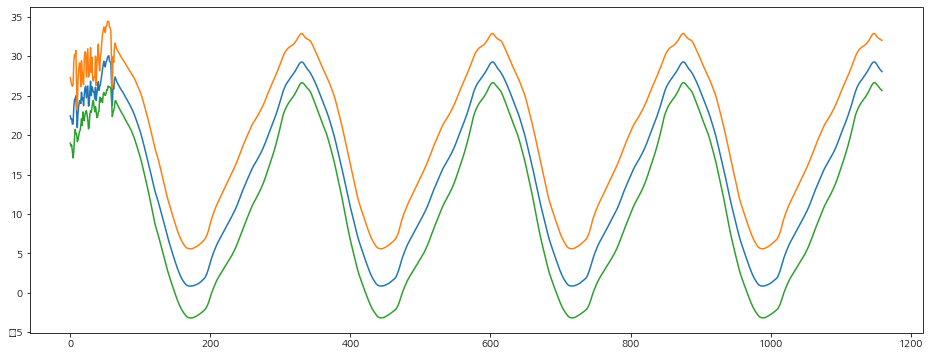

In [42]:
fig, axe = plt.subplots(figsize = (16, 6))
axe.plot(test_pred)